# 0.0 Imports

In [1]:
import sys
import os

# create a path that points to the parent directory of the current directory
module_path = os.path.abspath(os.path.join('..'))

# check if the absolute path of the parent directory has been added to the system module search path
if module_path not in sys.path:
    sys.path.append(module_path)

os.chdir(module_path)

In [2]:
import pandas          as pd
import seaborn         as sns
import numpy           as np
import plotly.express  as px
import scikitplot as skplt
import warnings
import joblib

from catboost                  import CatBoostClassifier
from sqlalchemy                import create_engine, text
from matplotlib                import pyplot     as plt
from matplotlib.artist         import Artist     as art

from sklearn.model_selection   import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from IPython.display           import HTML
from sklearn.ensemble          import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.preprocessing     import MinMaxScaler, StandardScaler
from sklearn.pipeline          import Pipeline
from sklearn.compose           import ColumnTransformer
from sklearn.metrics           import precision_score
from sklearn.impute            import SimpleImputer
from xgboost                   import XGBClassifier
from lightgbm                  import LGBMClassifier

import pipeline #próprio
from firststeps                    import FirstSteps as fs
from src                           import Credentials
from src                           import Profit
from src                           import project as pj
from bayesian                      import BayesianSearchCV



In [3]:
fs.jupyter_settings()

## 0.2 Colecting Data

In [4]:
# import the class with the credentials
#from src import Credentials

cr = Credentials()

# acessa as credenciais para conexão com o BD
credentials = cr.connection()

# conecta com o BD
link = create_engine(credentials)
conn = link.connect()

#query
query = """
        select *
        from pa004.users u 
            left join pa004.vehicle v on (u.id=v.id)
            left join pa004.insurance i on (u.id=i.id)
        """

dataframe = pd.read_sql_query(text(query), con = conn)

conn.close()

dataframe = dataframe.loc[:, ~dataframe.columns.duplicated()]

dataframe.to_csv('dataset/health_insurance.csv', index=False)

### 0.2.1 Load Data

In [4]:
df = pd.read_csv('dataset/health_insurance.csv')

## 0.3 Data Split

In [5]:
train, test = train_test_split(df, test_size=0.2, stratify=df.response, shuffle=True, random_state=25)

In [6]:
train.shape

(304887, 12)

In [7]:
train.to_csv('dataset/train.csv', index=False)

In [8]:
test.shape

(76222, 12)

In [9]:
test.to_csv('dataset/test.csv', index=False)

# 1.0 Data description

|Nome | Significado |
| -- | -- |   
|id|ID único por cliente|
|gender|Gênero do cliente|
|age|Idade|
|region_code|Código da região|
|policy_sales_channel|Codigo para os canais de contato com o cliente|
|driving_license|Se o cliente possui habilitação|
|vehicle_age|Idade do veículo|
|vehicle_damage|Se o veículo já foi danificado|
|previously_insured|Se o cliente já possui seguro de carro|
|annual_premium|Valor anual do seguro de saúde do cliente|
|vintage|Número de dias em que o cliente tem o seguro de saúde|
|response|Resposta do cliente em relação ao interesse no seguro de veículos|

In [10]:
df1 = train.copy()

## 1.1 Data Dimensions

In [12]:
print(f'The dataframe has {df.shape[0]} rows')
print(f'The dataframe has {df.shape[1]} columns')

The dataframe has 381109 rows
The dataframe has 12 columns


In [11]:
df1.vehicle_damage = df1.vehicle_damage.apply(lambda x:0 if x == 'No' else 1)
    
df1.vehicle_age = df1.vehicle_age.apply(lambda x:1 if x == '< 1 Year' else 2 if x == '1-2 Year' else 3)

gender = {'Male': 1, 'Female': 0}
df1.gender = df1.gender.map(gender)

## 1.2 Data Types and check NA

In [14]:
fs.type_na(df1)
#type_na(df1)

,features,type,soma_nulos,perc_nulos
0,id,int64,0,0.0
1,gender,int64,0,0.0
2,age,int64,0,0.0
3,region_code,float64,0,0.0
4,policy_sales_channel,float64,0,0.0
5,driving_license,int64,0,0.0
6,vehicle_age,int64,0,0.0
7,vehicle_damage,int64,0,0.0
8,previously_insured,int64,0,0.0
9,annual_premium,float64,0,0.0


## 1.3 Data Descriptive - Estatística Descritiva

In [15]:
fs.num_statistic(df1)
#num_statistic(df1)

,attributes,count,range,min,25%,50%,75%,max,mean,std,skew,kurtosis
0,id,304887.0,381108.0,1.0,95243.5,190705.0,285882.5,381109.0,190592.530921,110062.190068,-0.001029,-1.199533
1,gender,304887.0,1.0,0.0,0.0,1.0,1.0,1.0,0.540728,0.498338,-0.163457,-1.973295
2,age,304887.0,65.0,20.0,25.0,36.0,49.0,85.0,38.829619,15.514235,0.672687,-0.565478
3,region_code,304887.0,52.0,0.0,15.0,28.0,35.0,52.0,26.394425,13.237314,-0.115939,-0.868324
4,policy_sales_channel,304887.0,162.0,1.0,26.0,131.0,152.0,163.0,111.981826,54.225698,-0.897996,-0.974788
5,driving_license,304887.0,1.0,0.0,1.0,1.0,1.0,1.0,0.997894,0.045840,-21.723458,469.911705
6,vehicle_age,304887.0,2.0,1.0,1.0,2.0,2.0,3.0,1.610088,0.567482,0.252063,-0.791466
7,vehicle_damage,304887.0,1.0,0.0,0.0,1.0,1.0,1.0,0.504748,0.499977,-0.018992,-1.999652
8,previously_insured,304887.0,1.0,0.0,0.0,0.0,1.0,1.0,0.458291,0.498257,0.167420,-1.971984
9,annual_premium,304887.0,537535.0,2630.0,24420.0,31661.0,39408.0,540165.0,30574.862785,17239.995107,1.765403,33.285061


* Don't have any feature with NA values;
* 3 features with binary data;
* The feature "driving_license" has a big negative skew, indicating that the distribution is dislocated by right. This is one of the binaries features, so the high kurtosis indicates that the data is concentrated on the class 1. Looking the percentile, on 25% the data already is on the class 1.
* The feature "annual_premium" has  a positive skew, that indicates the distribution is dislocated by left, and the kustoses, indicating that the distribution has long tail.

# 2.0 Exploratory Data Analysis

## 2.1 Univariate Analysis

### 2.1.1 Response Variable

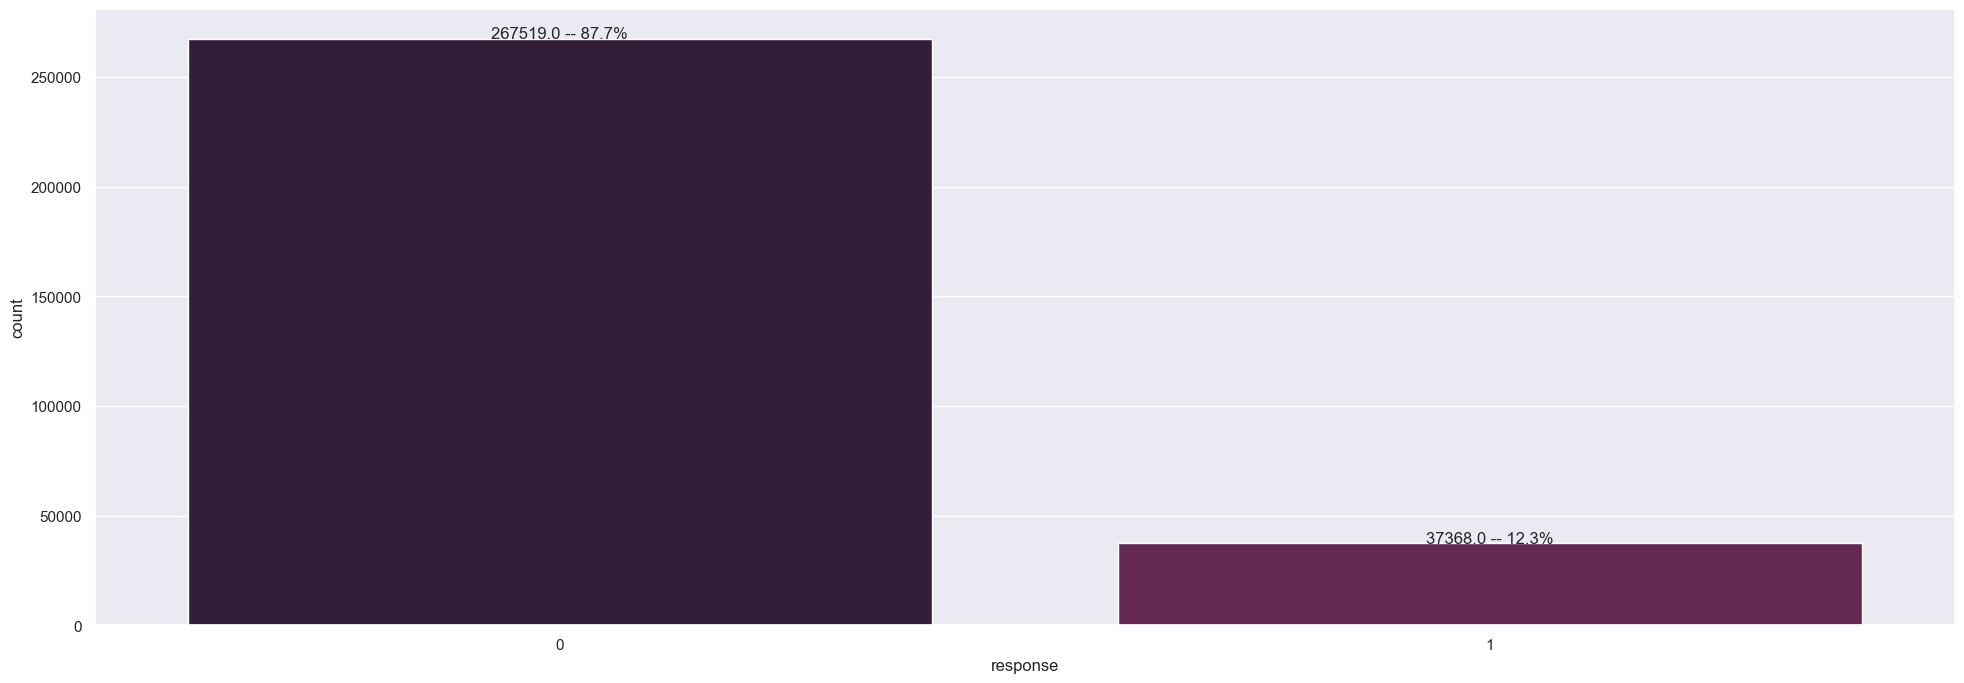

In [16]:
fig, ax = plt.subplots()
sns.countplot(data = df1, x='response', ax = ax);

for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x() + (p.get_width()/2), h , f'{h} -- {round(h/len(df1)*100, 1)}%', ha='center')


* 12.3% of the customers is interested on Vehicle Insurance

### 2.1.2 Numeric Variable

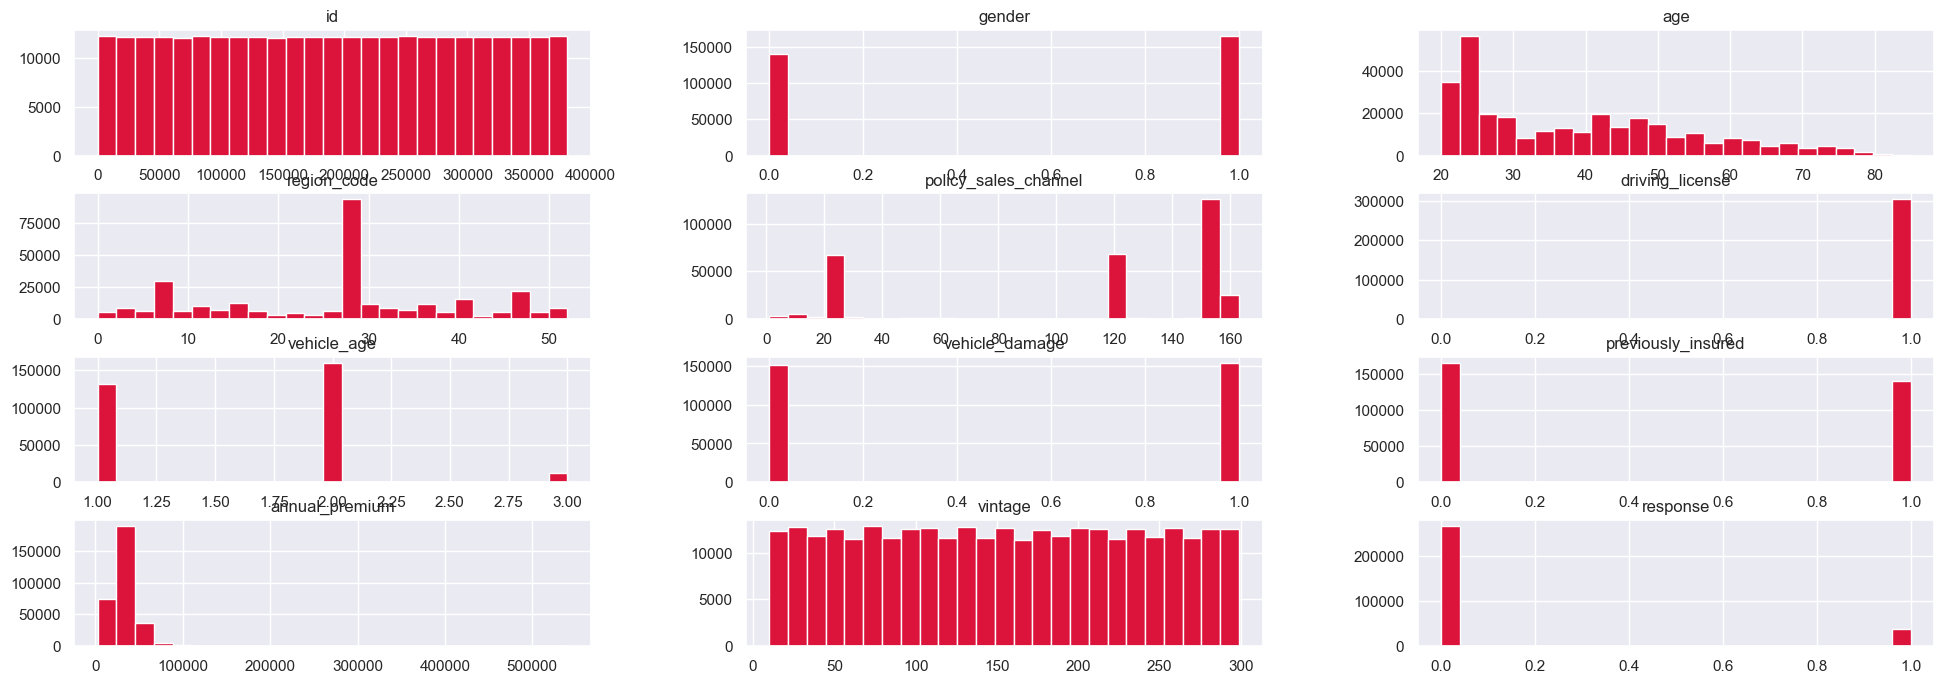

In [17]:
fs.num_features_plot(df1)
#num_features_plot(df1)

### 2.1.3 Categorical Variable

In [18]:
fs.cat_features_plots(df1)
#cat_features_plots(df1)

## 2.2 Bivariate Analysis

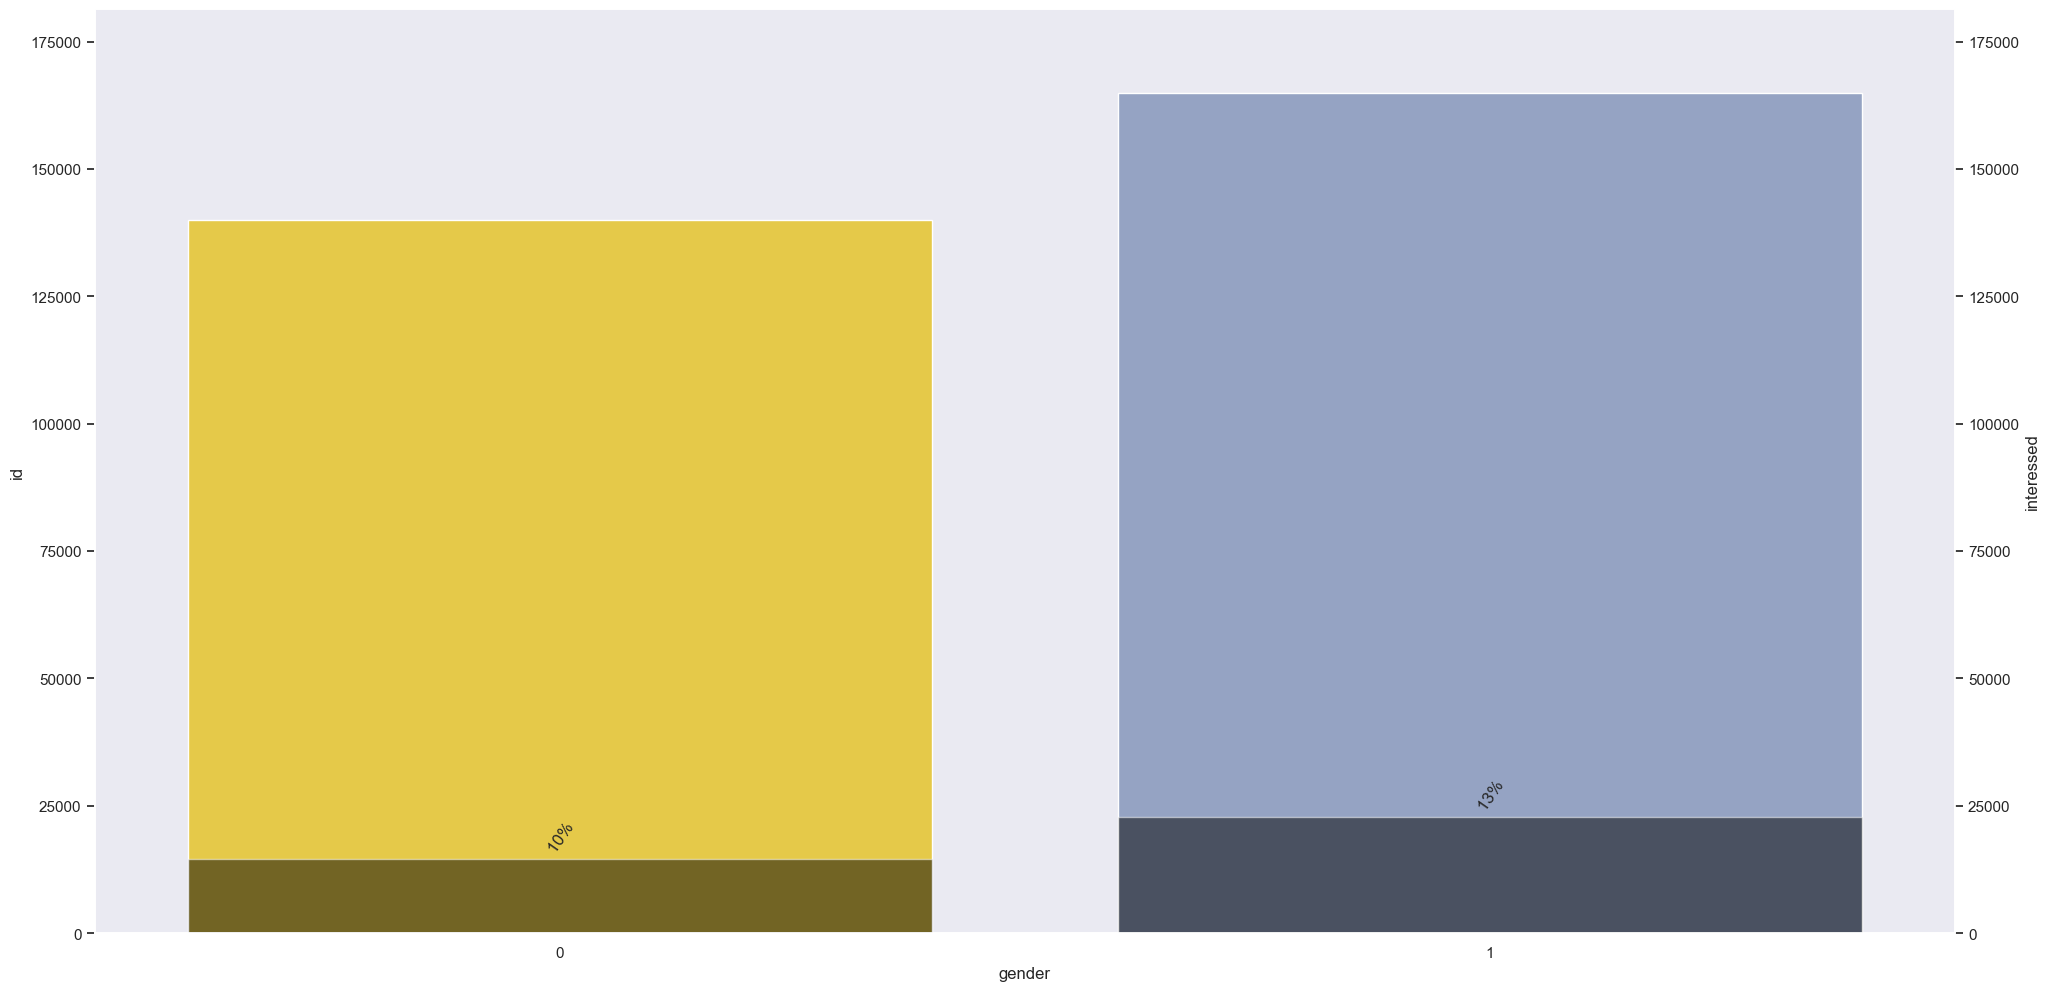

In [12]:
# conversão por genero
fs.convertion_plots(df1, 'gender')
#convertion_plots(df1, 'gender')

* Of 164861 male clients, 13% was converted 
* Of 140026 female clients, 10% was converted

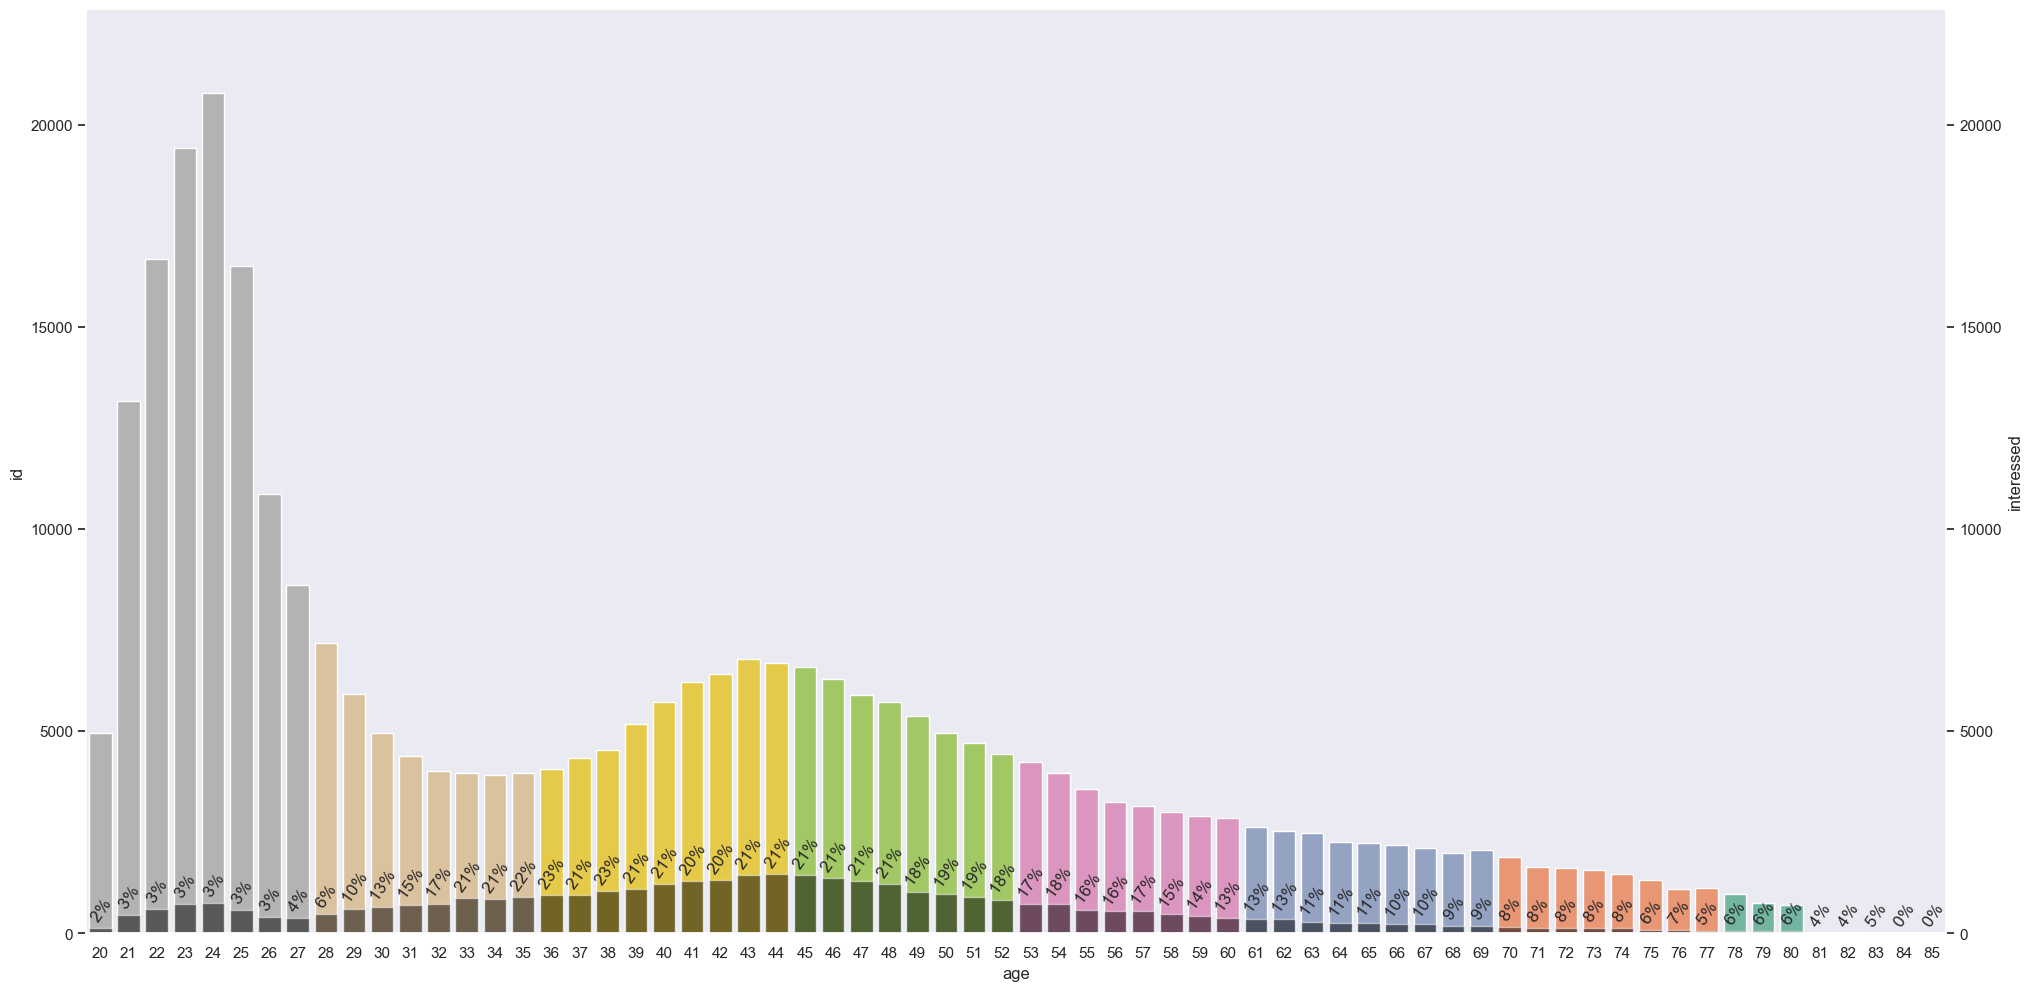

In [13]:
fs.convertion_plots(df1, 'age')
#convertion_plots(df1, 'age')

* The range of age 32 to 53 years old has more convertion

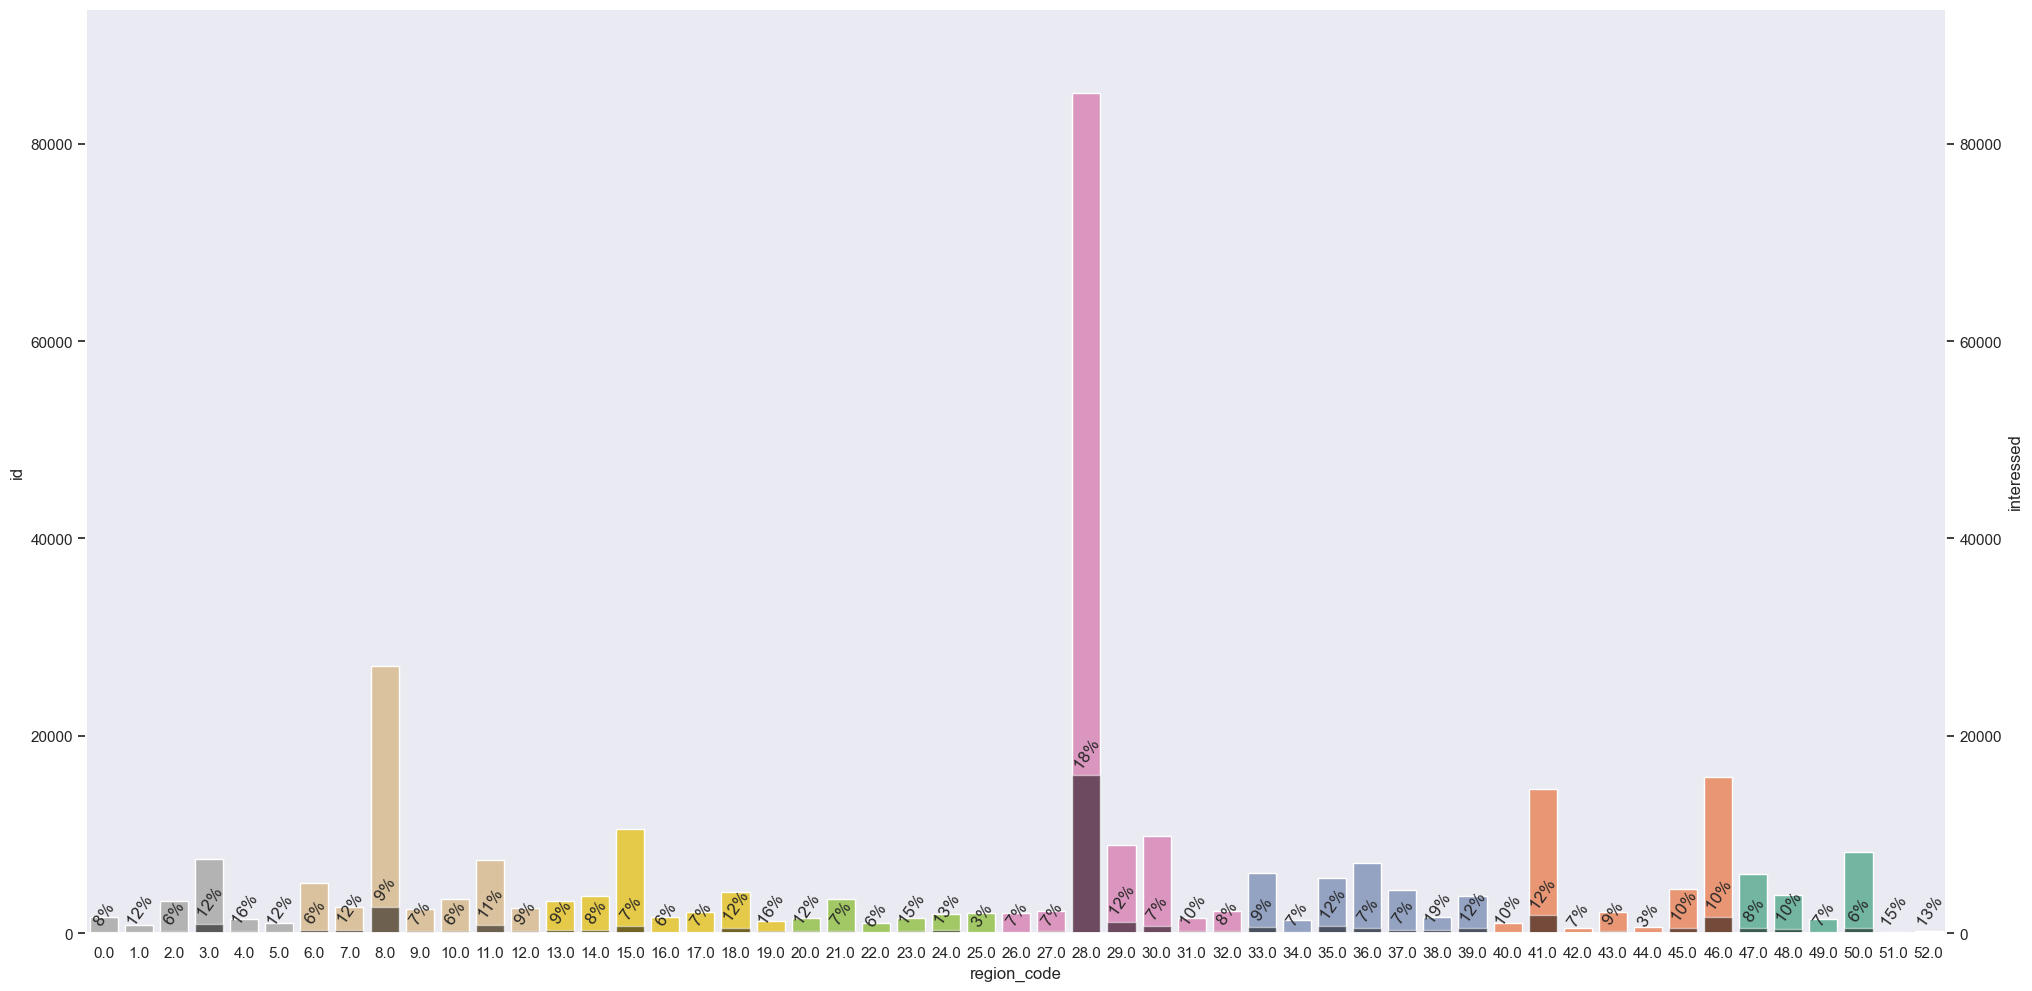

In [14]:
fs.convertion_plots(df1, 'region_code')
#convertion_plots(df1, 'region_code')

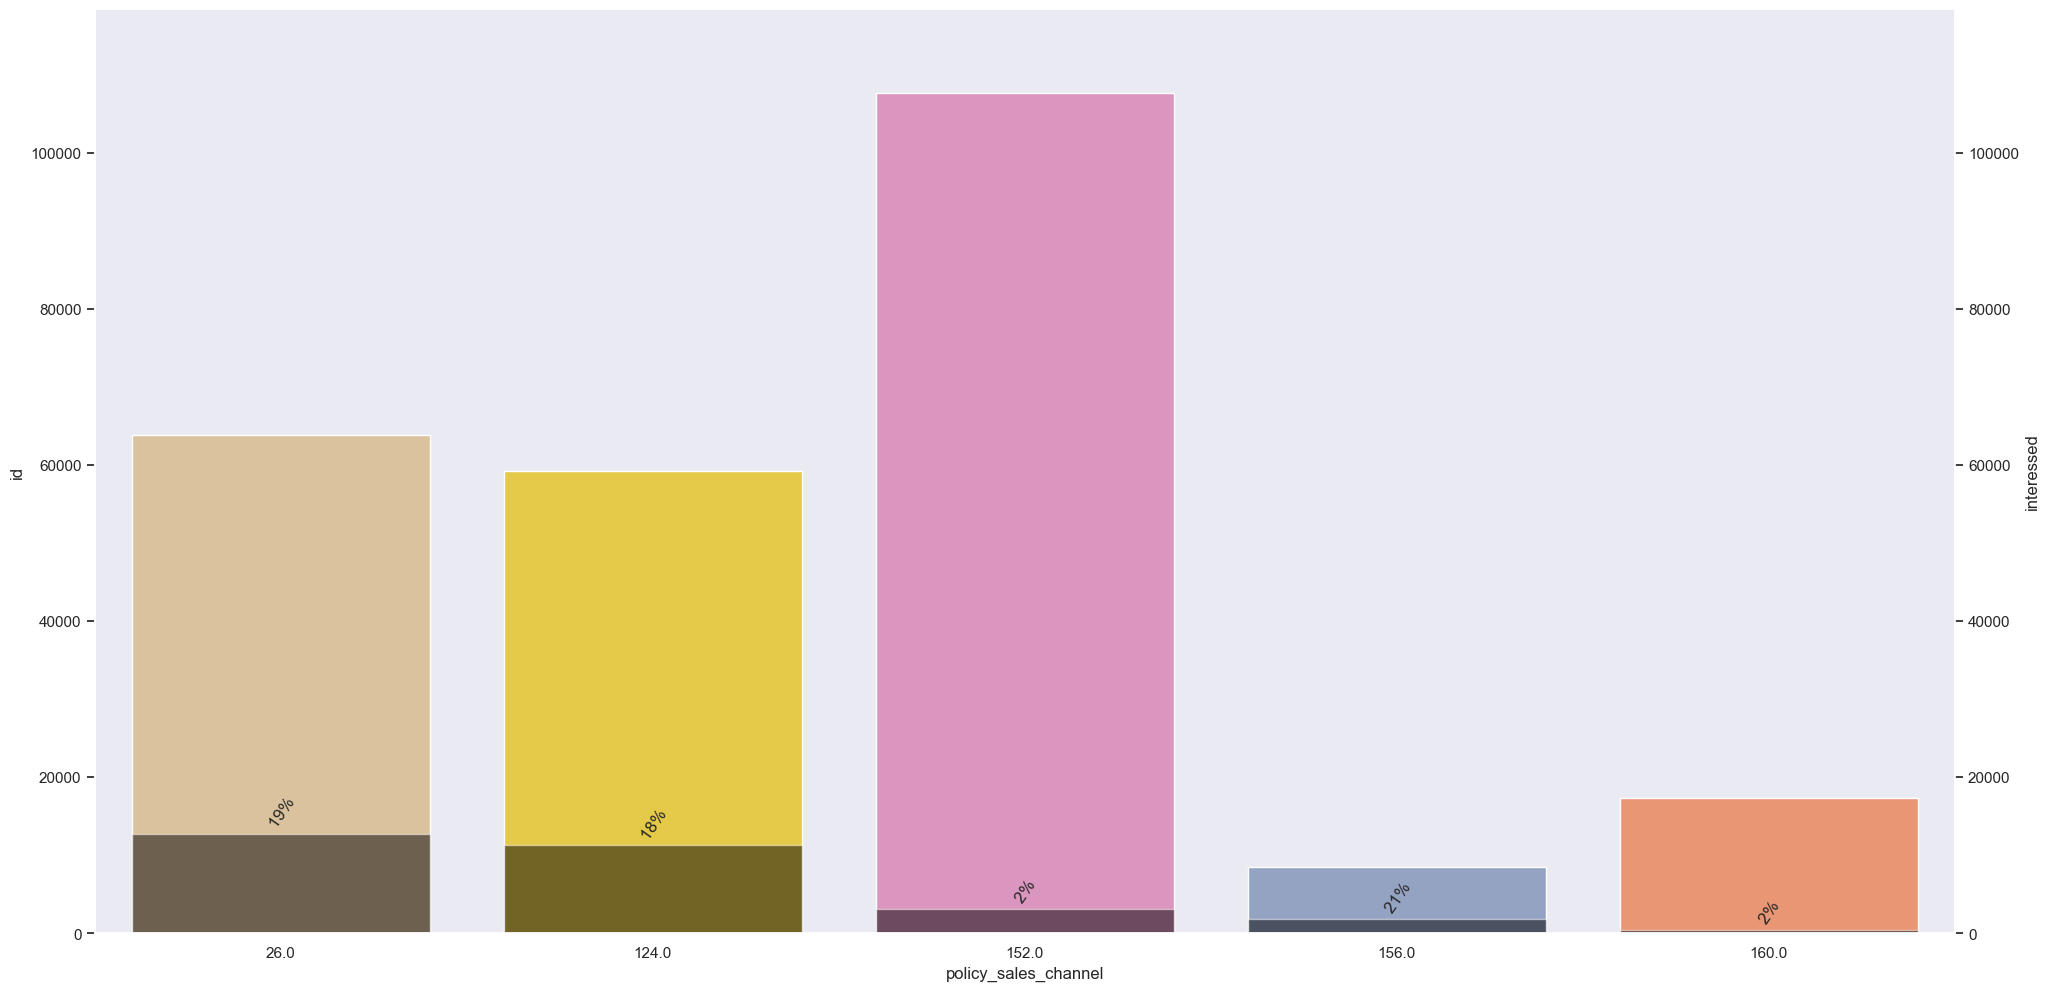

In [15]:
top10 = df1.policy_sales_channel.value_counts().head(5).index

df_top10 = df1.query('policy_sales_channel in @top10')

fs.convertion_plots(df_top10, 'policy_sales_channel')


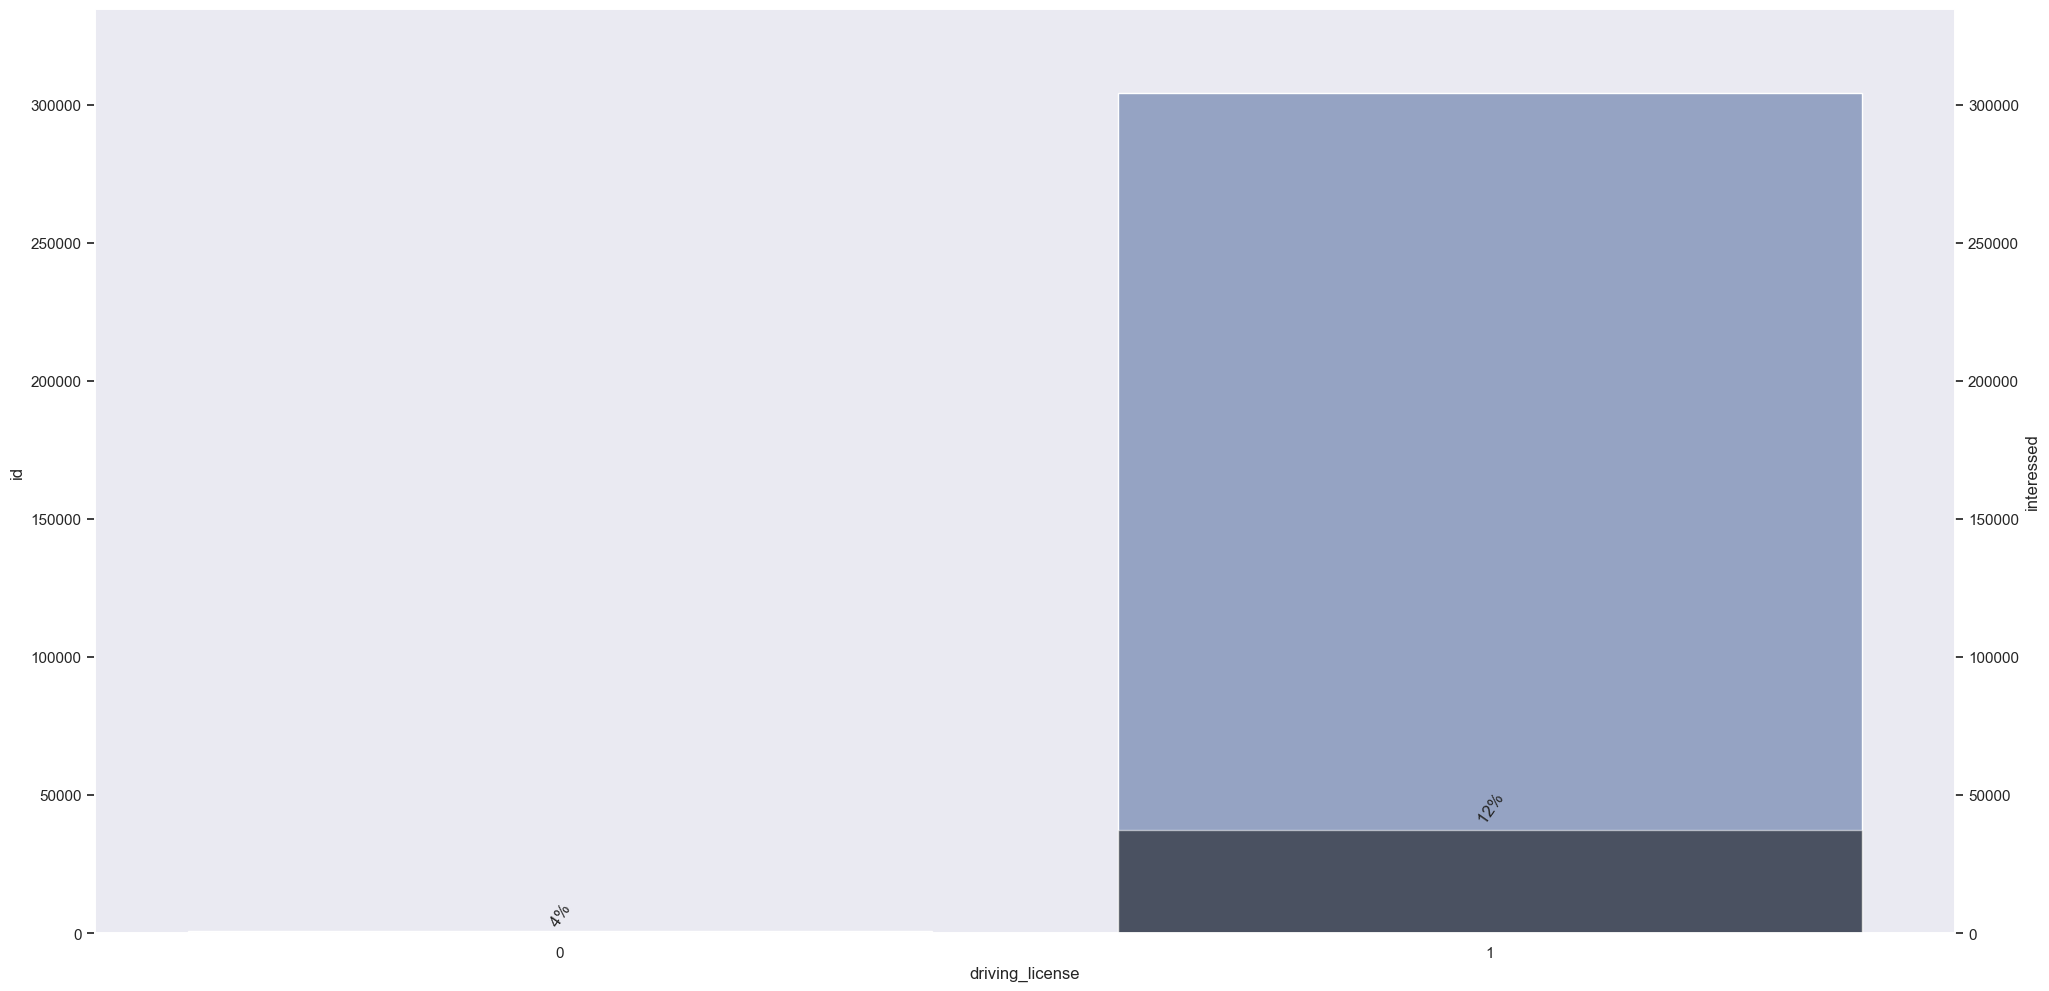

In [16]:
fs.convertion_plots(df1, 'driving_license')
#convertion_plots(df1, 'driving_license')

* Clients without driving license convert an inexpressible percentage

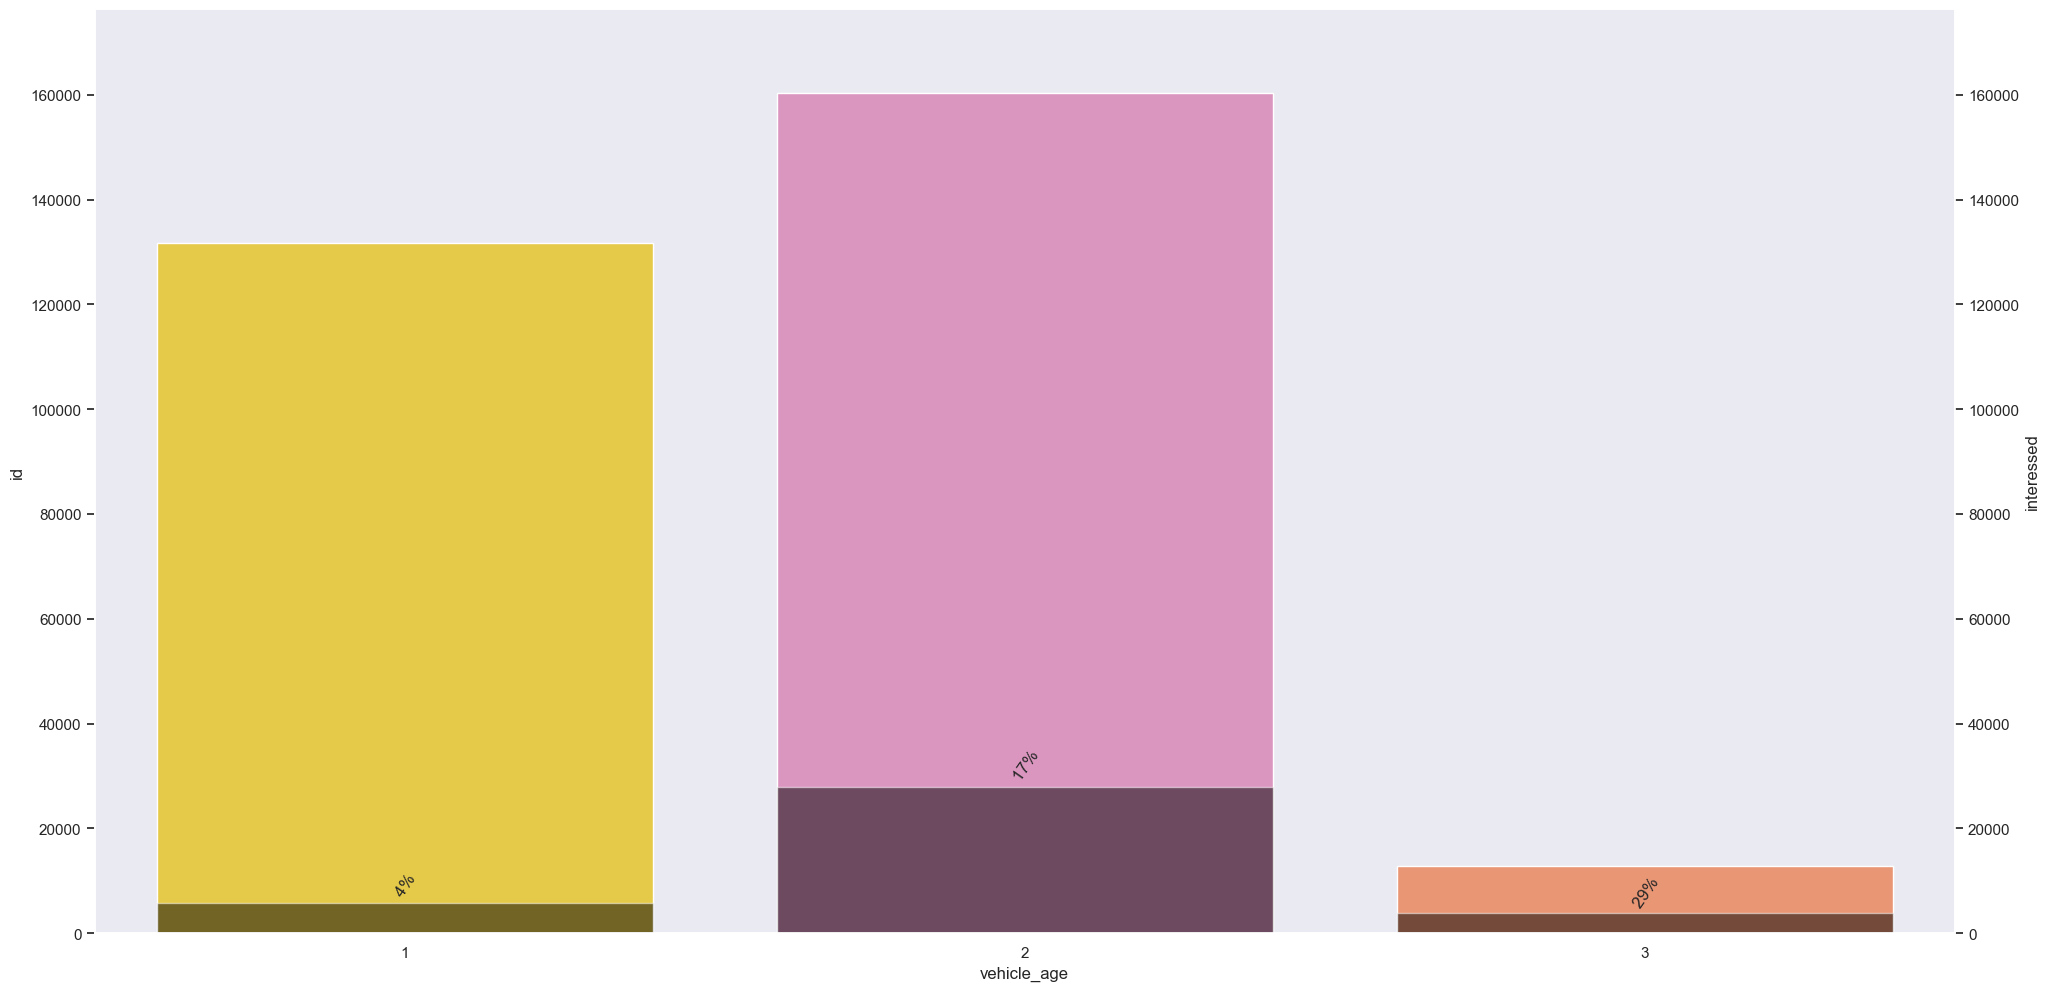

In [17]:
fs.convertion_plots(df1, 'vehicle_age')
#convertion_plots(df1, 'vehicle_age')

*  Car between 1 and 2 years old convert more than others

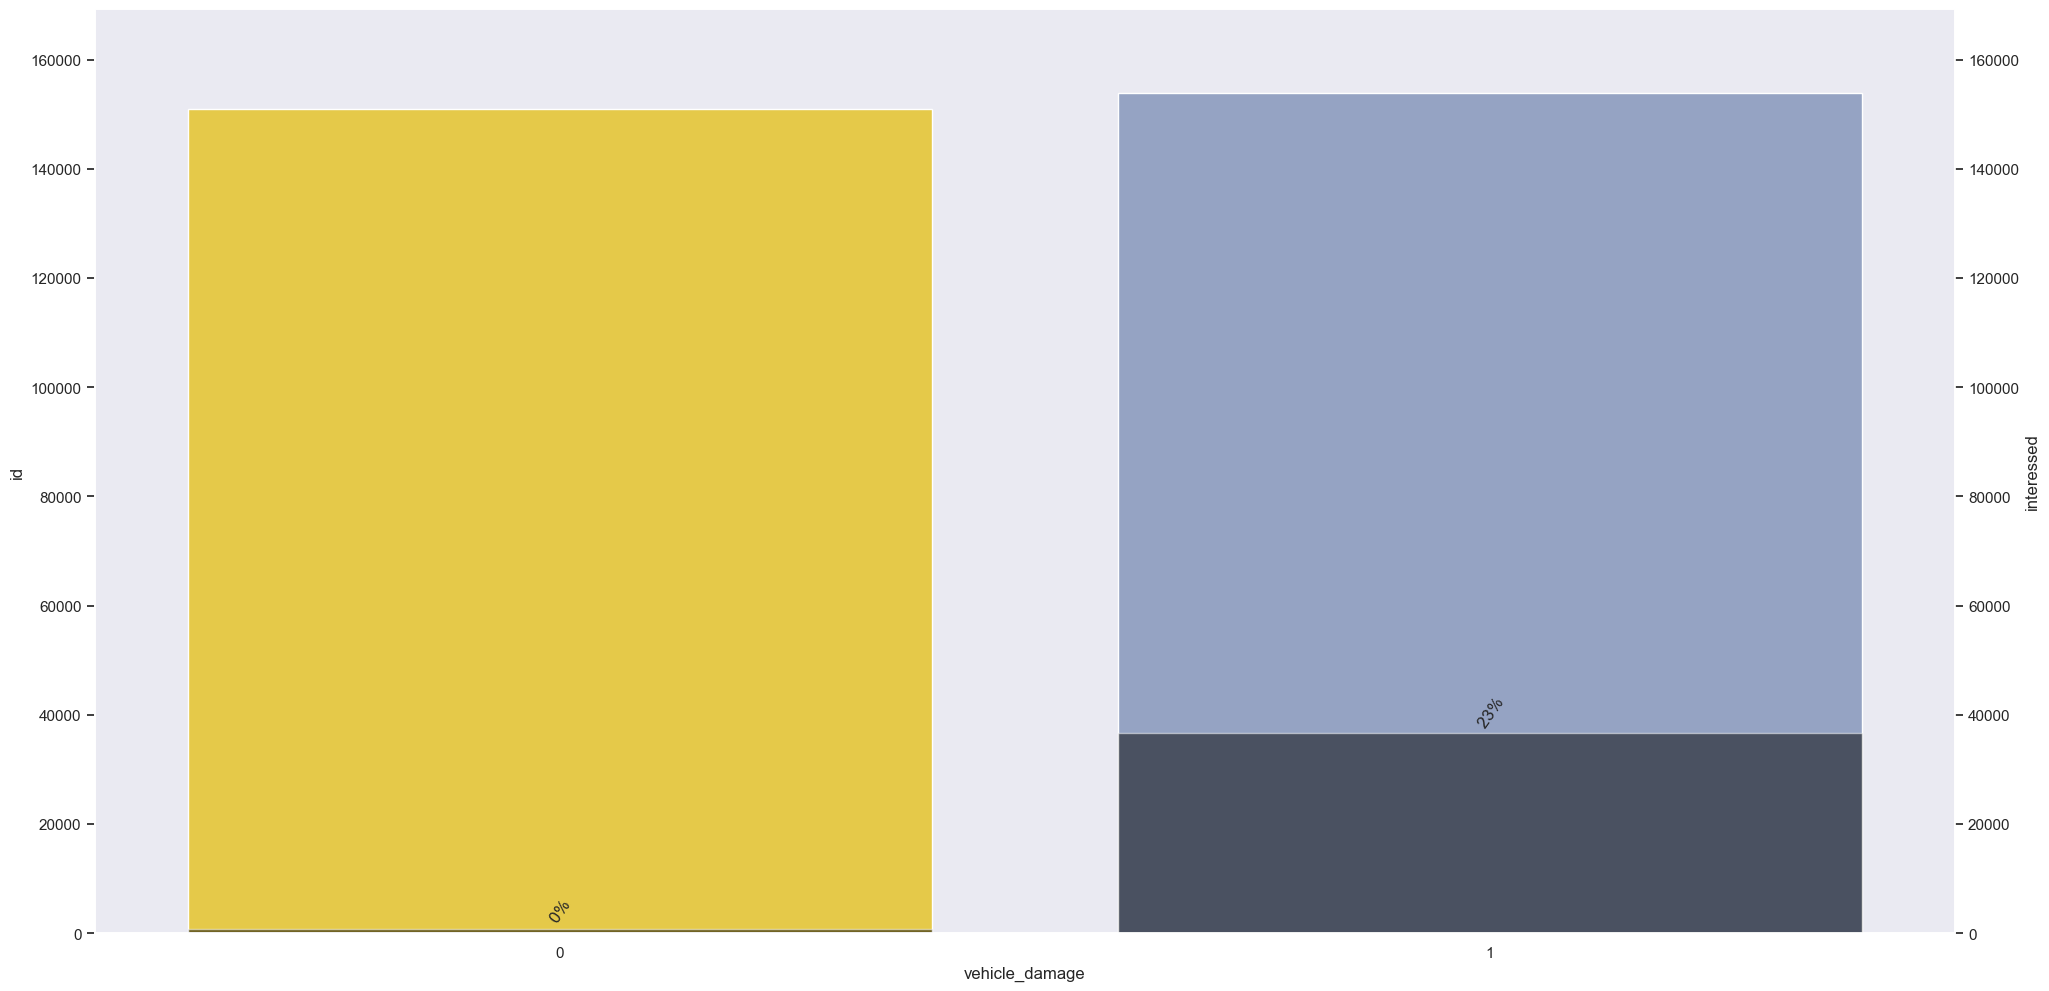

In [18]:
fs.convertion_plots(df1, 'vehicle_damage')
#convertion_plots(df1, 'vehicle_damage')

* Cars without previous damage convert an inexpressible percentage

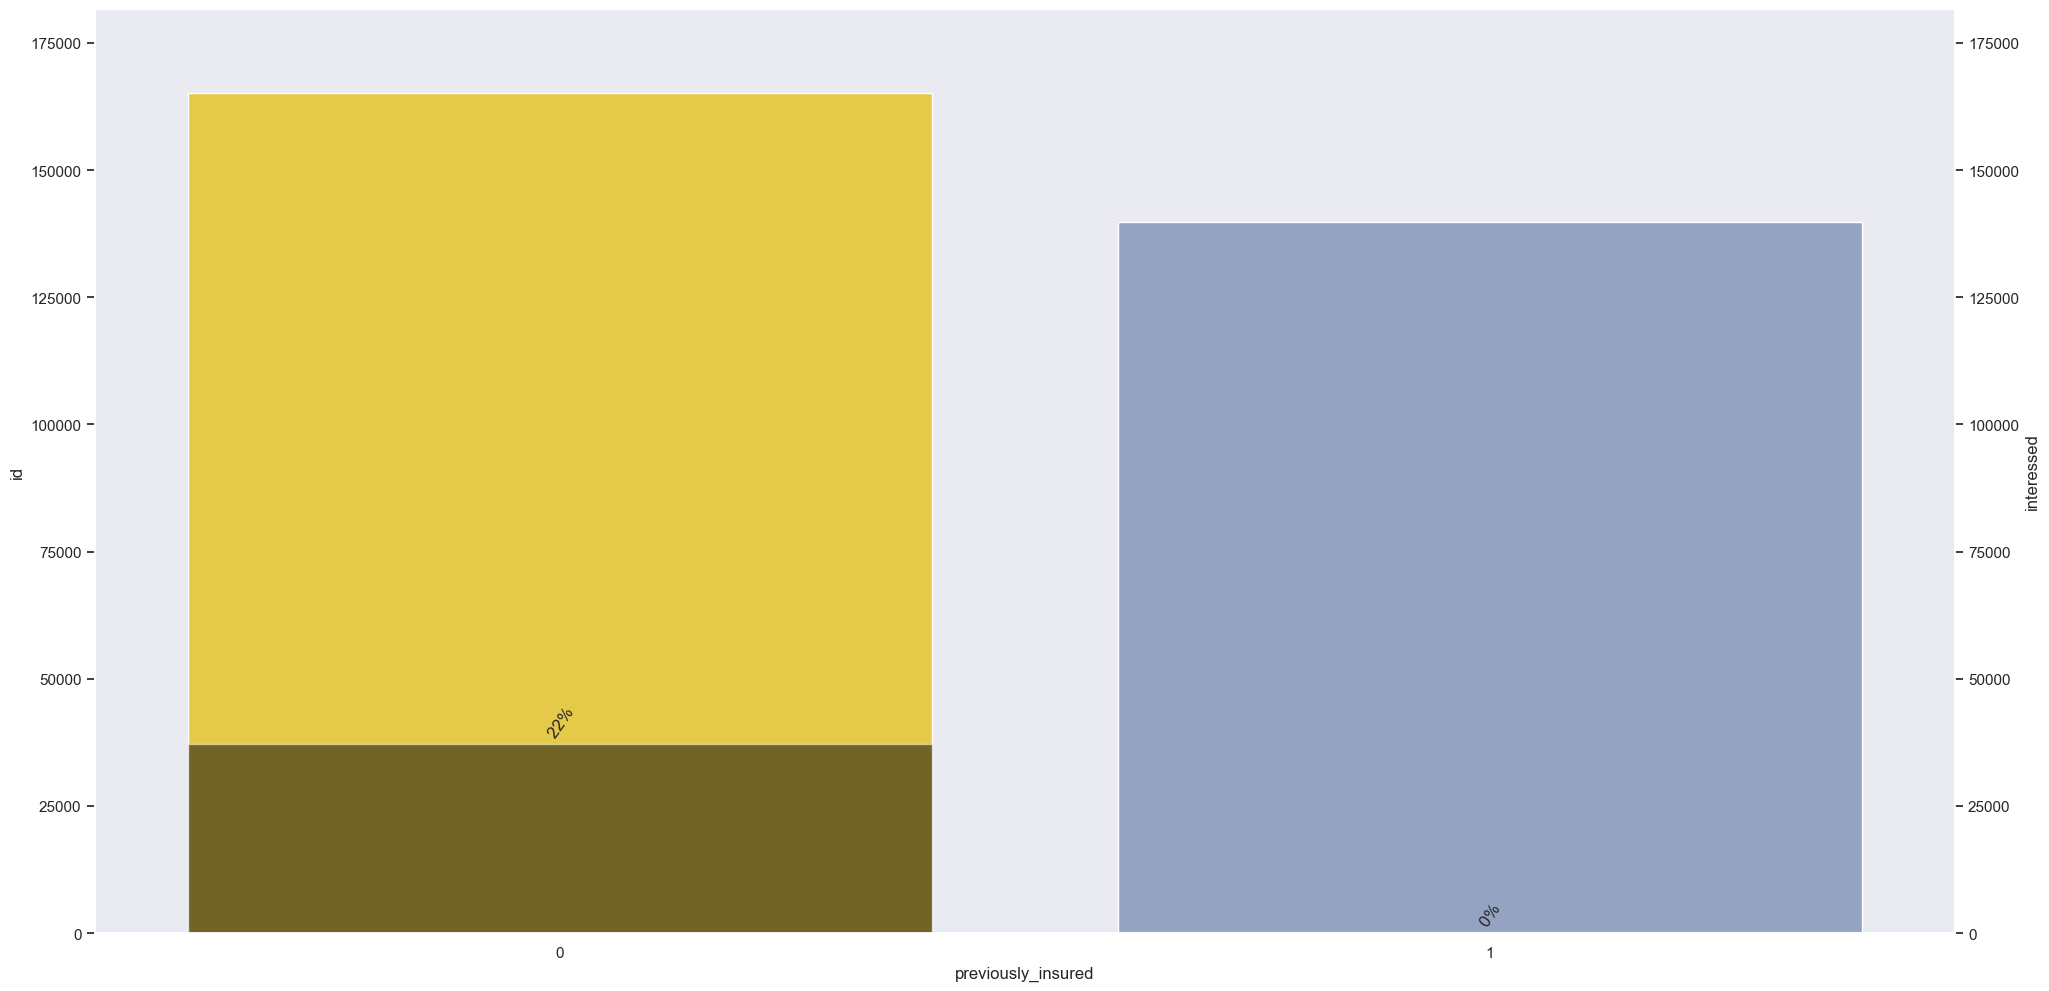

In [19]:
fs.convertion_plots(df1, 'previously_insured')
#convertion_plots(df1, 'previously_insured')

* Clients that already have an insurance convert an inexpressible percentage

## 2.3 Multivariable Analysis

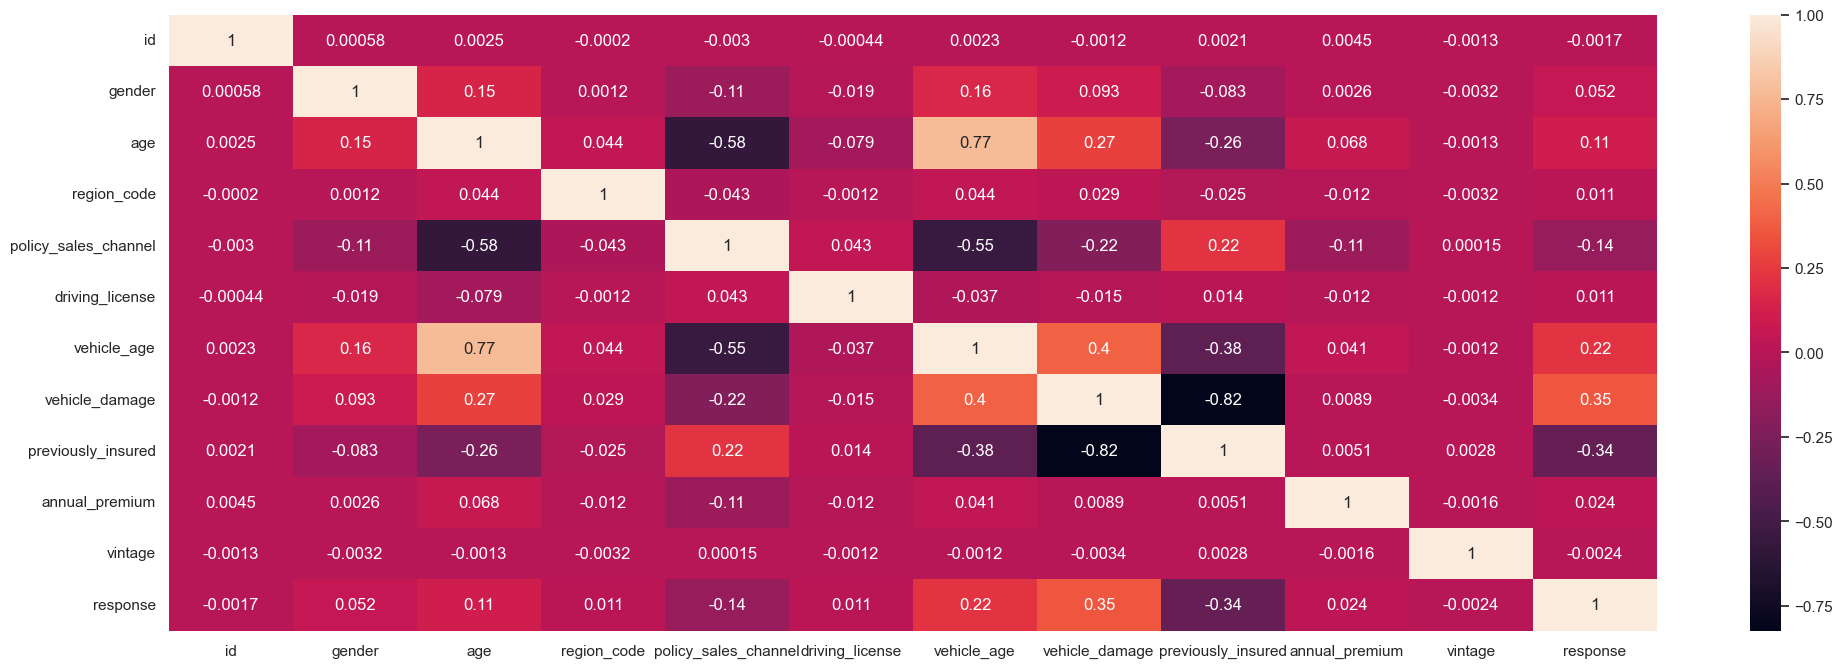

In [27]:
num = df1.select_dtypes(include=['int64', 'float64'])

corr = num.corr(method='pearson')
sns.heatmap(corr, annot=True, cmap=sns.color_palette('rocket',as_cmap=True));

## 2.4 Hypotheses

### <span style="color:red"> Women are the most interested group in car insurance </span> 


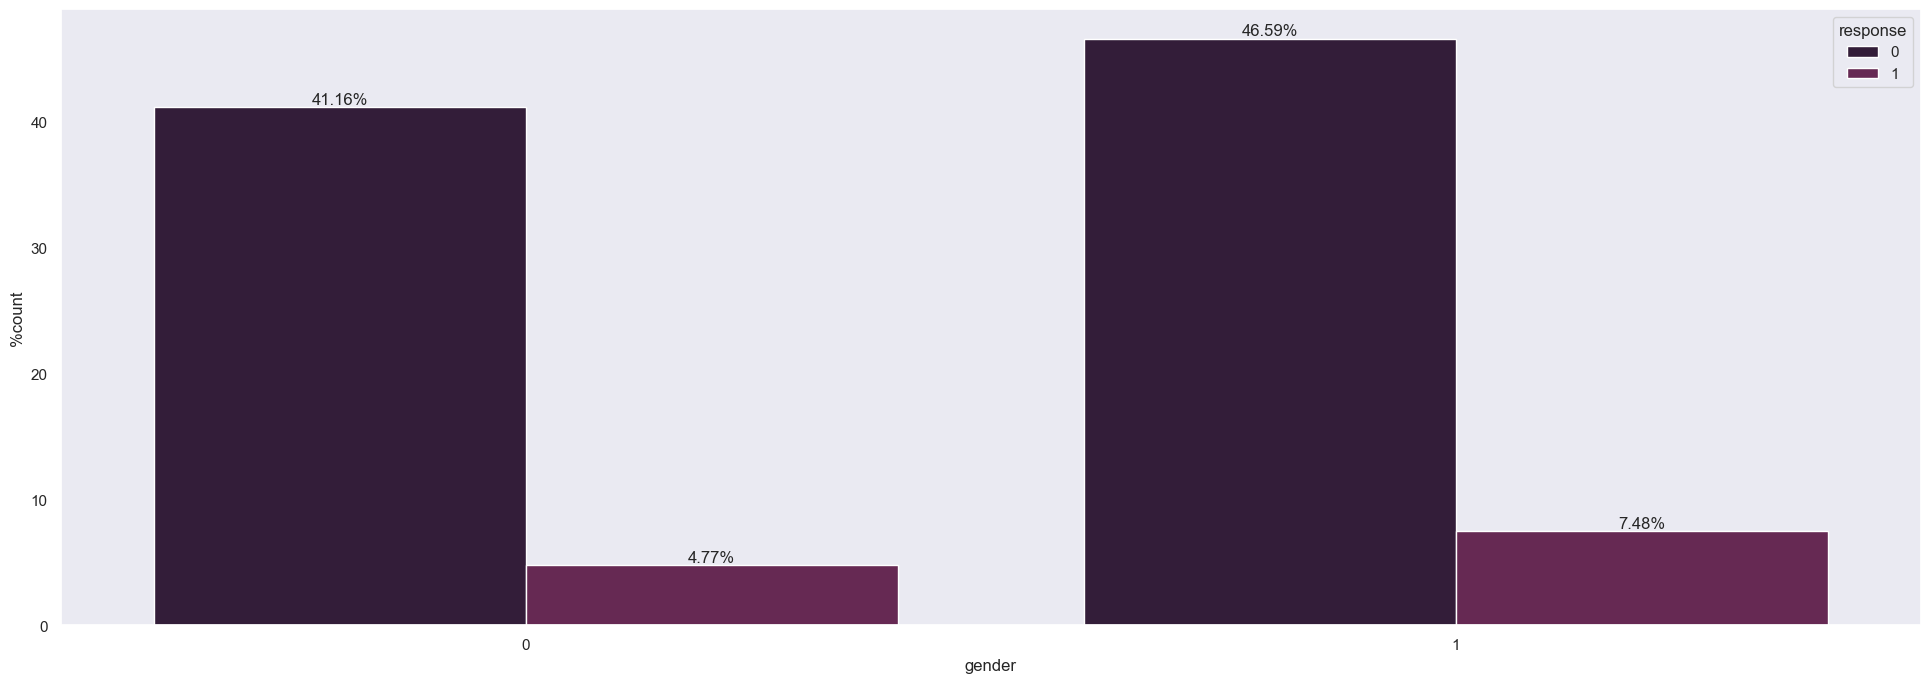

In [28]:
aux = df1[['gender', 'response']].value_counts().reset_index()

aux['%count'] = (aux[0]/len(train)*100).round(2) # calcula o % com relação a todo o DF

ax = sns.barplot(aux, x='gender', y='%count', hue='response');
for i in ax.containers:
    ax.bar_label(i,fmt='%.2f%%')


### <span style="color:lightgreen"> People older than 40 are more interested in car insurance </span>


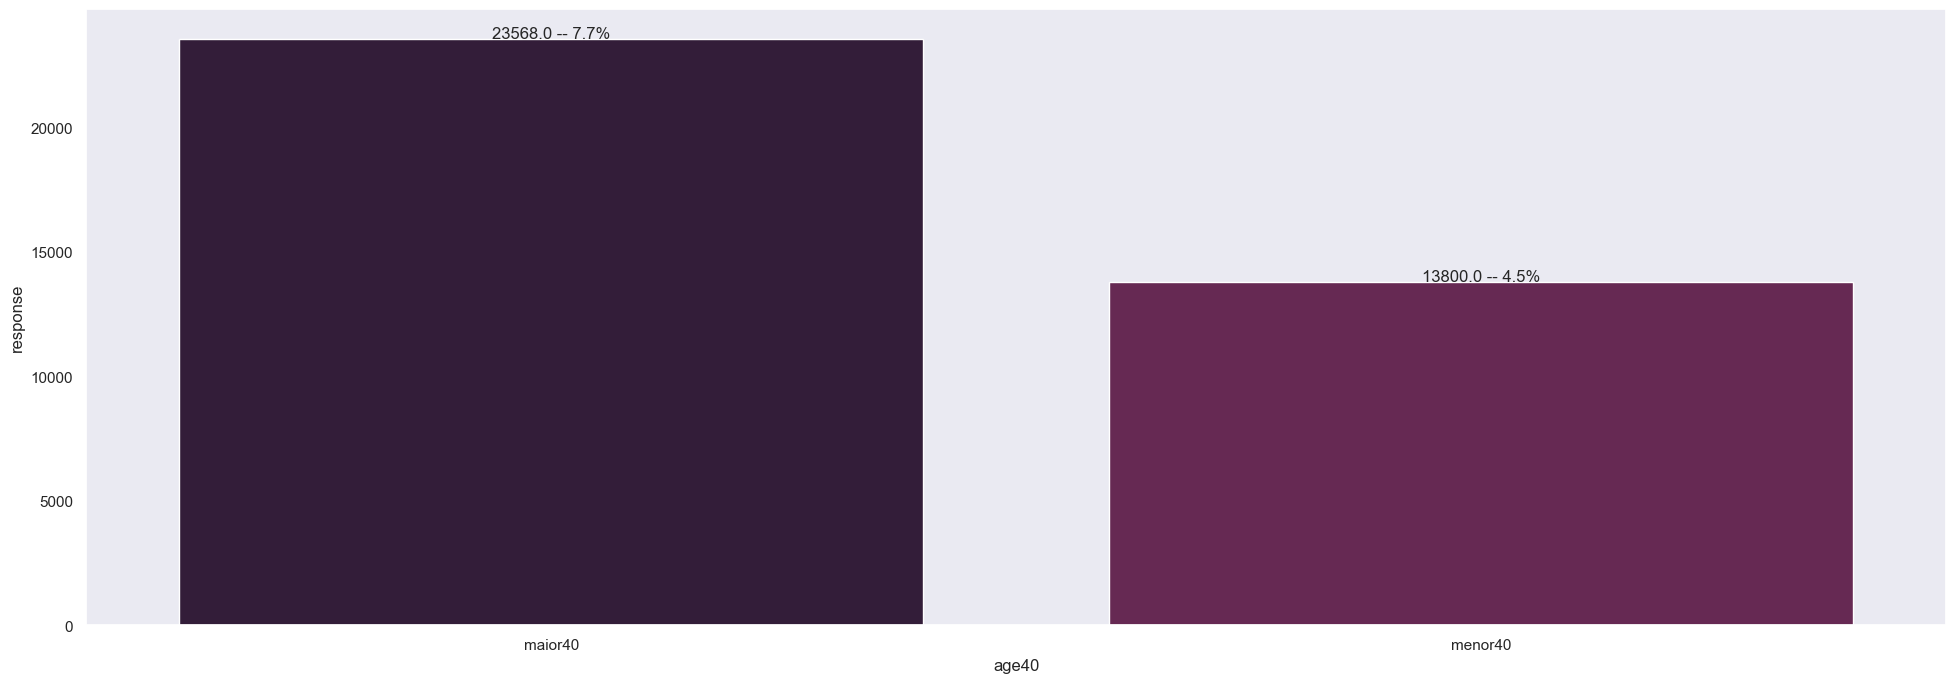

In [31]:
df1['age40'] = df1.age.apply(lambda x:'under40' if x < 40 else 'over40' )

aux1 = (df1[['age40', 'response']].groupby('age40')
                                  .sum()
                                  .reset_index()
                                  .sort_values('response', ascending=False))

fig,ax = plt.subplots()
sns.barplot(aux1, x='age40', y='response', ax=ax);

for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x() + (p.get_width()/2), h , f'{h} -- {round(h/len(df1.age40)*100, 1)}%', ha='center')


In [32]:
df1.age40.value_counts()

menor40    167467
maior40    137420
Name: age40, dtype: int64

In [33]:
df1.groupby('age40')[['response']].sum()

,response
age40,
maior40,23568
menor40,13800


### <span style="color:lightgreen"> People without driver license aren't interested in car insurance </span>


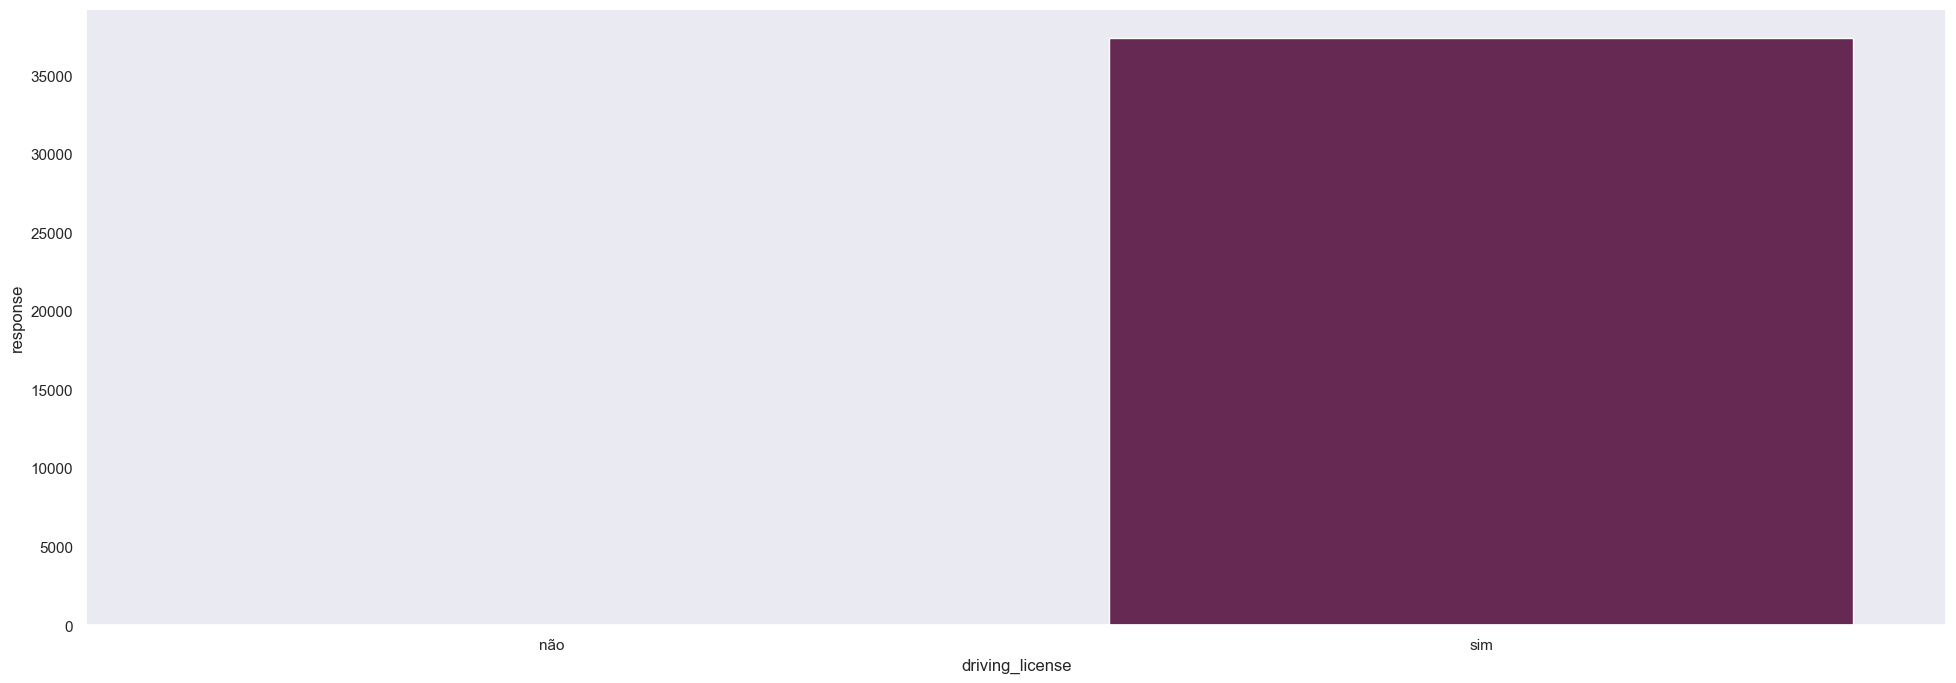

In [34]:
aux = df1[['driving_license', 'response']].groupby('driving_license').sum().reset_index()

aux.driving_license = aux.driving_license.apply(lambda x: 'não' if x == 0 else 'sim'  )

sns.barplot(aux, x='driving_license', y='response');

### <span style="color:red"> Clients with cars older than 2 years are more interested in car insurance </span>


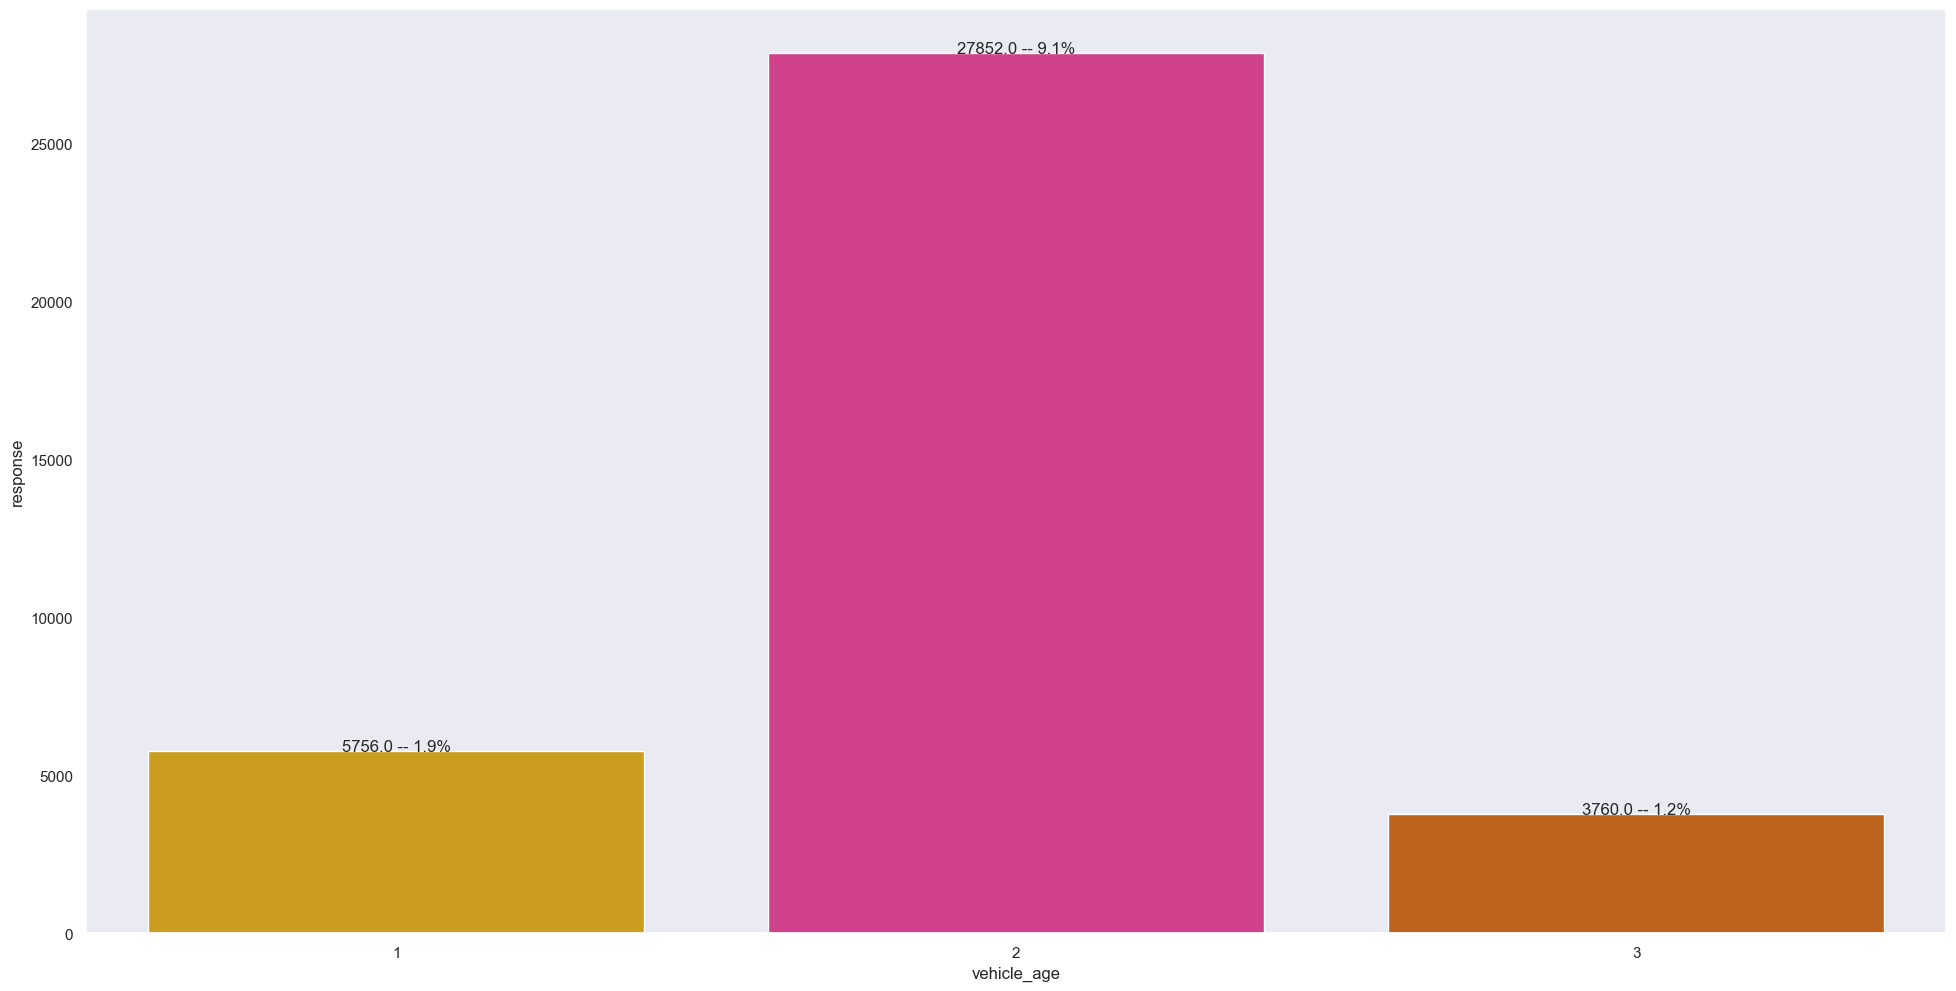

In [21]:
aux = df1[['vehicle_age', 'response']].groupby('vehicle_age').sum().reset_index()

fig,ax = plt.subplots()
sns.barplot(aux, x='vehicle_age', y='response', ax=ax, palette='Dark2_r' );

for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x() + (p.get_width()/2), h , f'{h} -- {round(h/len(df1.vehicle_age)*100, 1)}%', ha='center')


### <span style="color:lightgreen"> Clients with health insurance more than 150 days are more interested in car insurance </span>


In [36]:
df1['vintage150'] = df1.vintage.apply(lambda x: 'maior150' if x >= 150 else 'menor150')

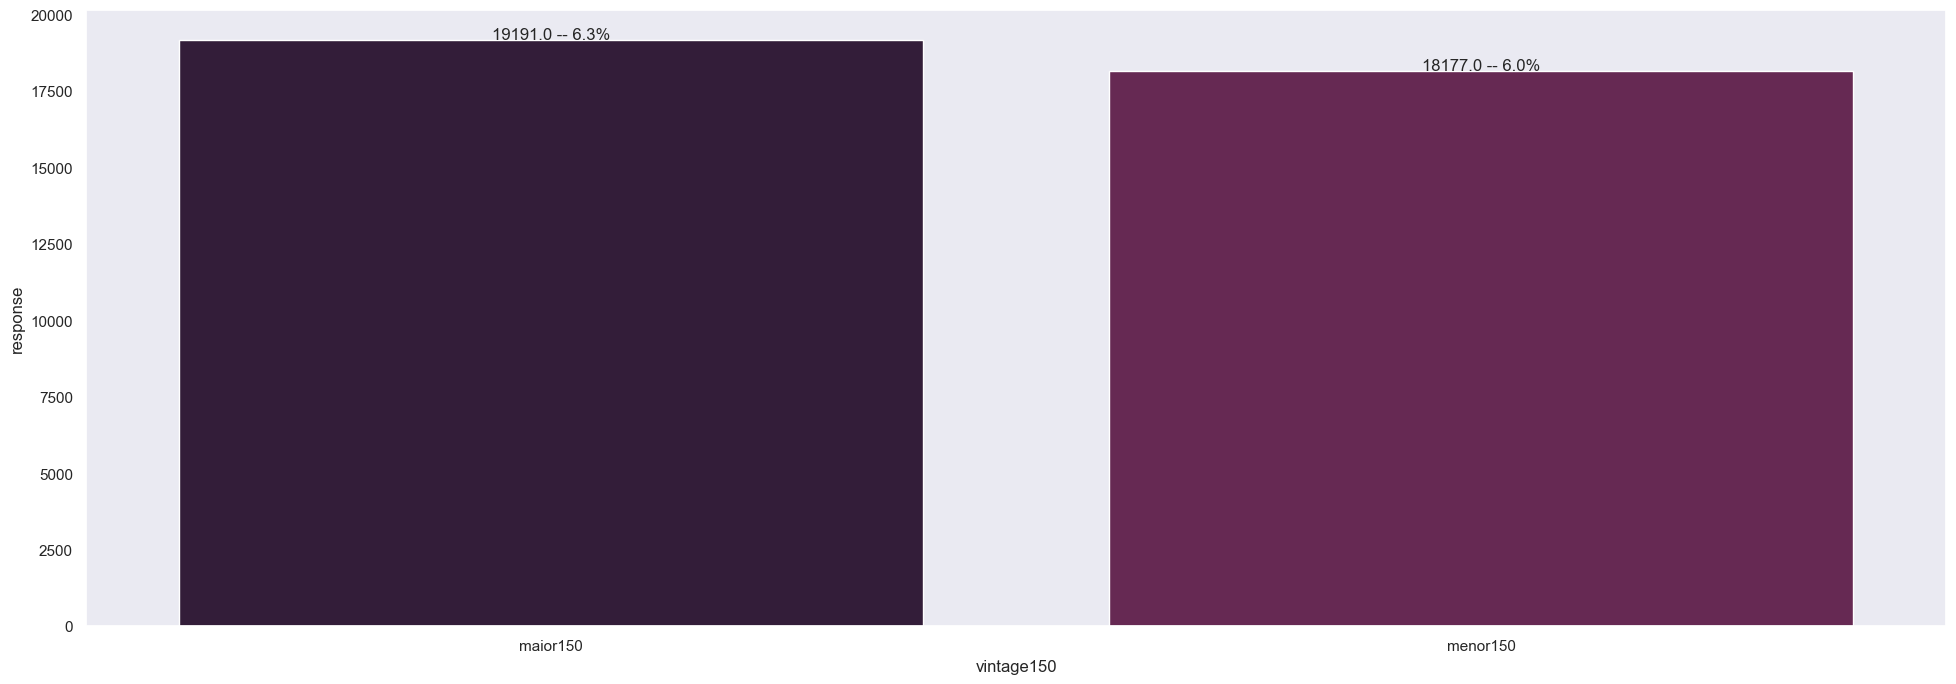

In [37]:
aux1 = df1[['vintage150', 'response']].groupby('vintage150').sum().reset_index()

fig,ax = plt.subplots()
sns.barplot(aux1, x='vintage150', y='response', ax=ax);

for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x() + (p.get_width()/2), h , f'{h} -- {round(h/len(df1.vintage150)*100, 1)}%', ha='center')

In [38]:
df1.vintage.max()

299

### <span style="color:lightgreen"> Clients that have car insurance in another company, are less interested in a new car insurance </span>


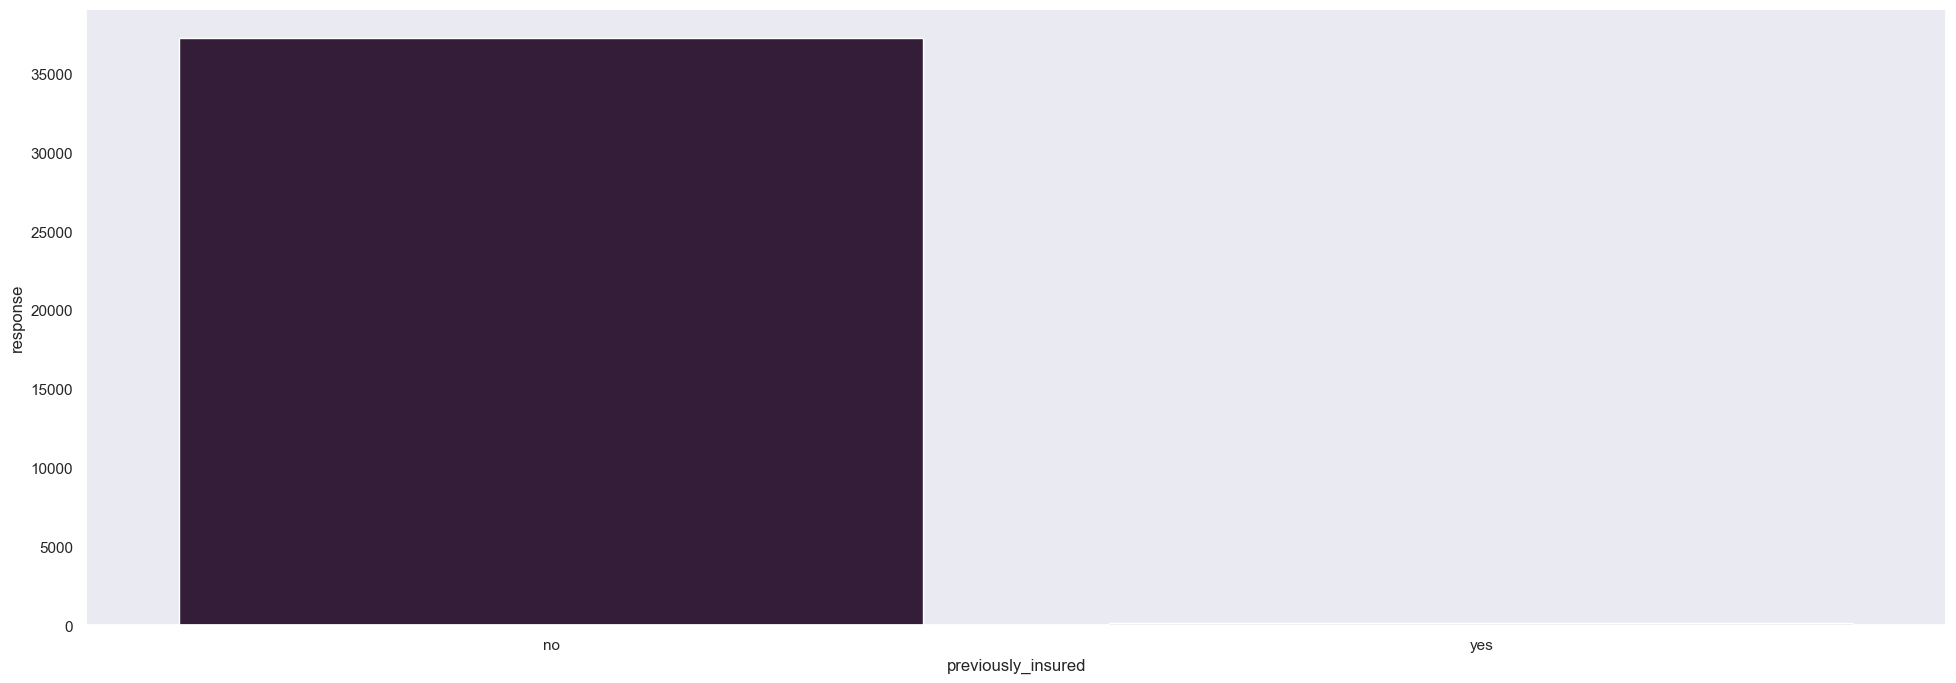

In [39]:
aux = df1[['previously_insured', 'response']].groupby('previously_insured').sum().reset_index()

aux.previously_insured = aux.previously_insured.apply(lambda x: 'no' if x == 0 else 'yes')

sns.barplot(aux, x='previously_insured', y='response');

### <span style="color:lightgreen"> Customers with a previous vehicle damage are more interested in car insurance </span>


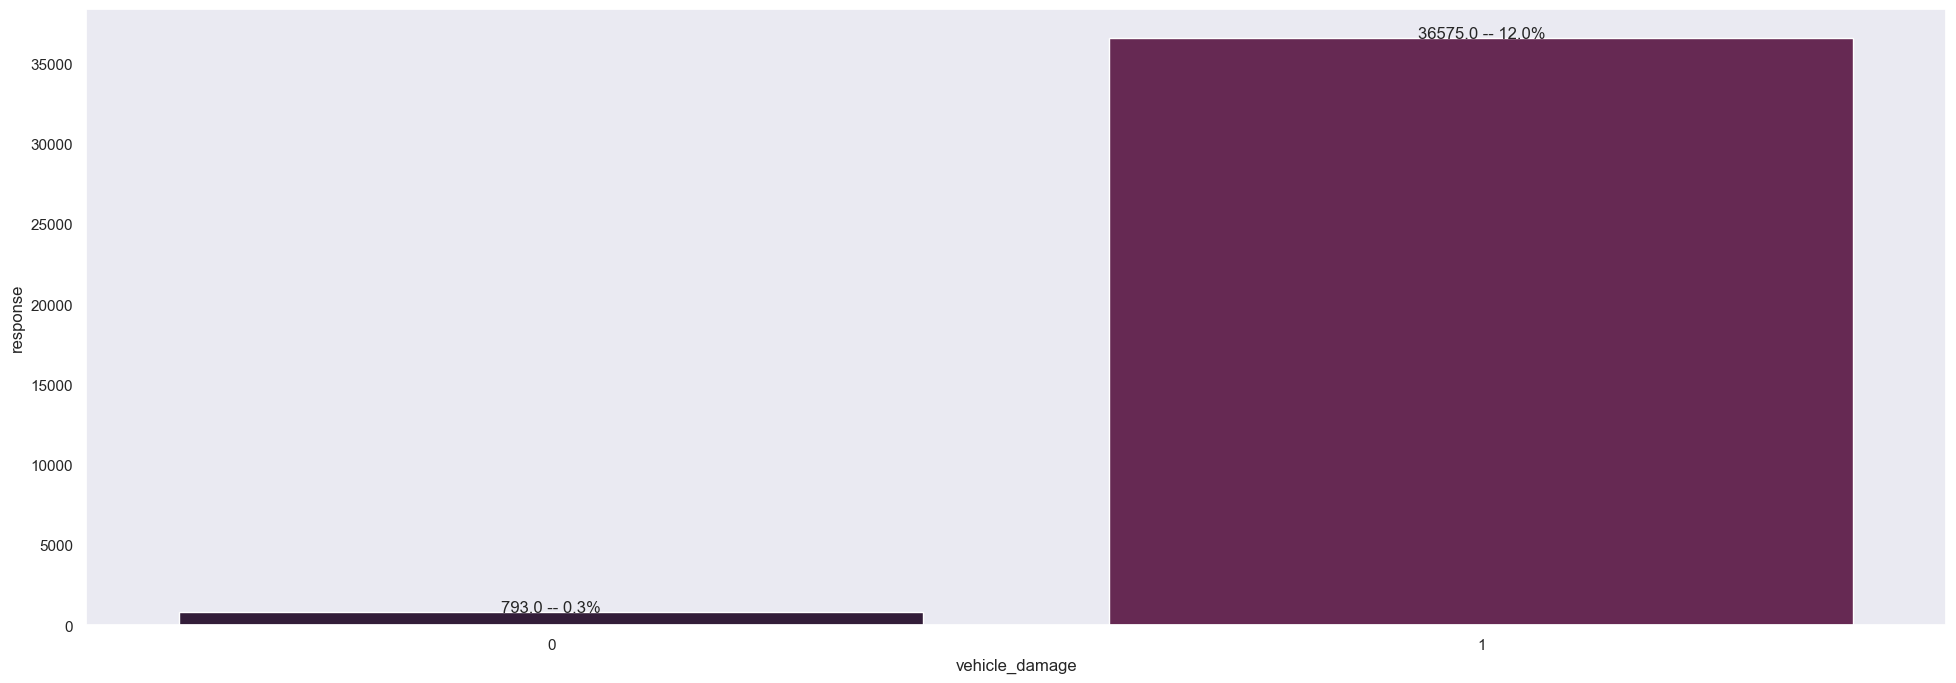

In [40]:
aux = df1[['vehicle_damage', 'response']].groupby('vehicle_damage').sum().reset_index()

fig,ax = plt.subplots()
sns.barplot(aux, x='vehicle_damage', y='response', ax=ax);

for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x() + (p.get_width()/2), h , f'{h} -- {round(h/len(df1.vehicle_damage)*100, 1)}%', ha='center')


### <span style="color:lightgreen"> 20% of the interested customers came from the 5 most used sales chanel </span>

In [13]:
top5 = df1.policy_sales_channel.value_counts().sort_values(ascending=False).index[:5]

df1['top5channel'] = df1.policy_sales_channel.apply(lambda x:'yes' if x in top5 else 'no')

In [14]:
df1.top5channel.value_counts()

yes    256659
no      48228
Name: top5channel, dtype: int64

In [15]:
df1.query('response==1')[['top5channel', 'response']].value_counts().reset_index()

,top5channel,response,0
0,yes,1,29206
1,no,1,8162


(0.0, 282324.9)

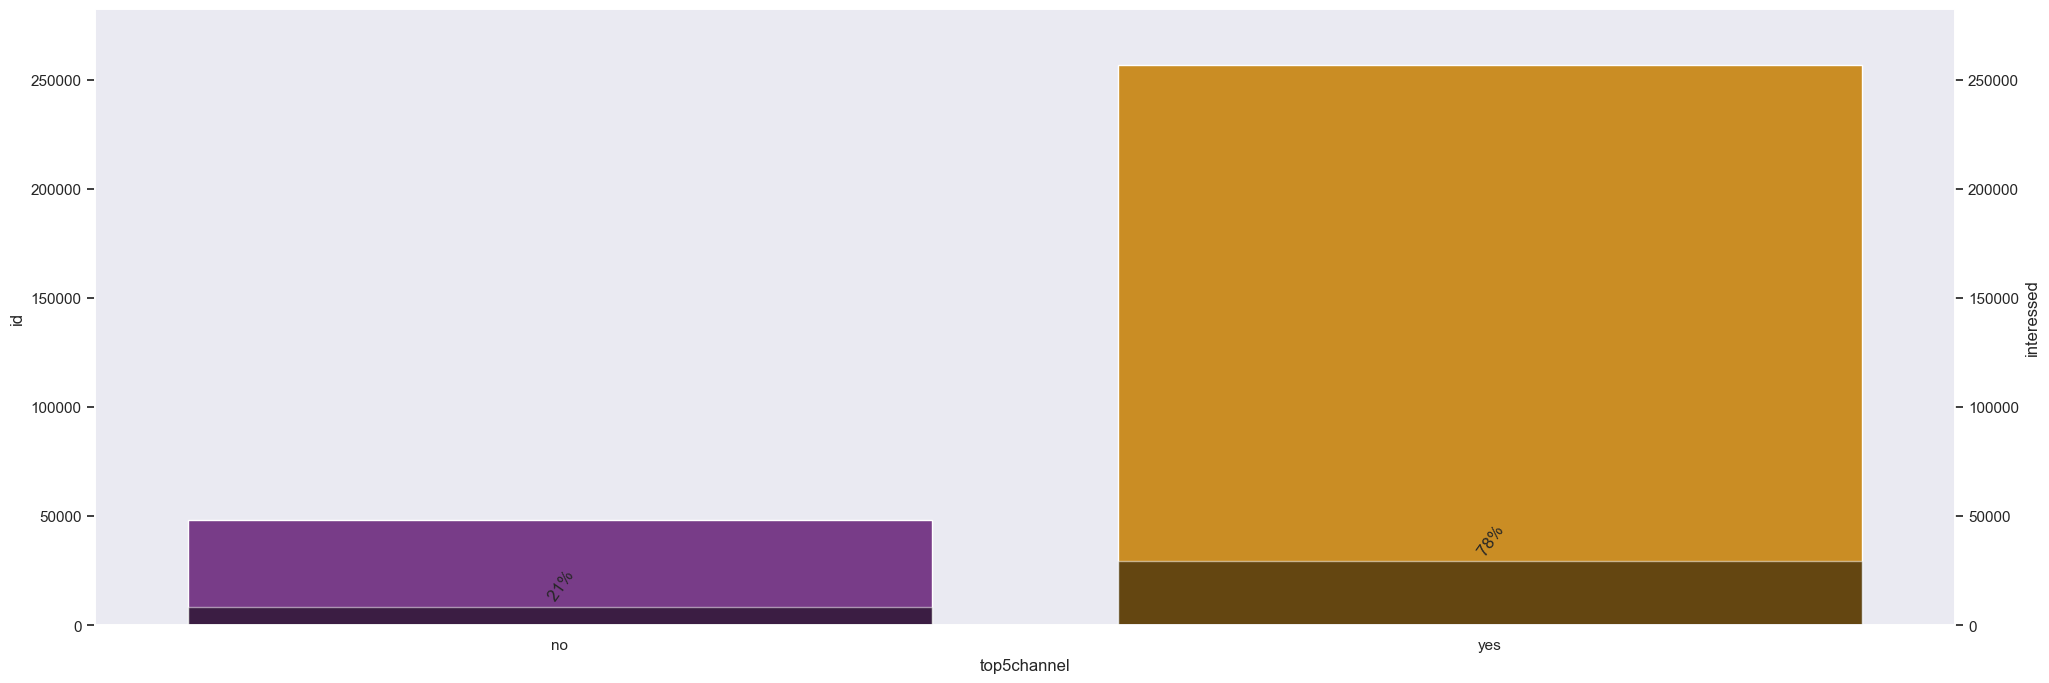

In [20]:
sns.set_style("darkgrid", {'axes.grid' : False})

aux = df1.query('response==1')[['top5channel', 'response']]

total = df1.groupby('top5channel')[['id']].count().reset_index()
response1 = (df1.query('response == 1')
                .groupby('top5channel')[['id']]
                .count()
                .reset_index()
                .rename(columns={'id': 'interessed'}))
total = total.merge(response1, how='left', on='top5channel').fillna(0)
total['perc'] = ((total.interessed/len(aux))*100).astype(int)

max_total = total.id.max() * 1.1

fig, ax = plt.subplots()
sns.barplot(total, x='top5channel', y='id', ax=ax, palette='CMRmap')
plt.ylim(0,max_total)
ax1=ax.twinx()
for i in total.index:
    label = ' ' + str(total.loc[i, 'perc']) + '%'
    y = (total.loc[i, 'interessed'])
    plt.annotate(label, (i,y), ha = 'center', va='bottom', rotation= 55)
    
sns.barplot(total, x='top5channel', y='interessed', ax=ax1, palette=['black'], alpha=0.5);
plt.ylim(0,max_total)


# 3.0 Feature Engineering

In [45]:
# Class responsable for feature engineering - it's inside pipeline directory
#class FeatureEngineering(BaseEstimator, TransformerMixin):
#    
#    def __init__(self):
#        pass
#    
#    def fit(self, X, y=None):
#        return self
#    
#    def transform(self, X, y=None):
#        X = self.feature_engineering(X)
#        return X
#    
#    def feature_engineering(self, data):
#        data.vehicle_damage = data.vehicle_damage.apply(lambda x:0 if x == 'No' else 1)
#        
#        data.vehicle_age = data.vehicle_age.apply(lambda x:1 if x == '< 1 Year' else 2 if x == '1-2 Year' else 3)
#        
#        gender = {'Male': 1, 'Female': 0}
#        data.gender = data.gender.map(gender)
#        
#        data['premium_vintage'] = data.annual_premium/data.vintage
#        
#        data['saleschannel_region'] = data.policy_sales_channel / (data.region_code + 1)
#        
#        data['age_vintage'] = data.age / data.vintage
#        
#        data['premium_age'] = data.annual_premium / data.age
#             
#        return data

NameError: name 'BaseEstimator' is not defined

In [46]:
df3 = train.copy()

In [47]:
pipefeat = Pipeline([('Feature Engineering', pipeline.FeatureEngineering())])
pipefeat

Pipeline(steps=[('Feature Engineering', FeatureEngineering())])

In [48]:
df3= pipefeat.fit_transform(df3)
df3

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,premium_vintage,saleschannel_region,age_vintage,premium_age
198181,58251,0,20,28.0,160.0,1,1,0,1,2630.0,30,0,87.666667,5.517241,0.666667,131.500000
275116,292797,0,24,21.0,152.0,1,1,0,1,25390.0,74,0,343.108108,6.909091,0.324324,1057.916667
72052,193860,0,50,8.0,124.0,1,2,0,1,45245.0,250,0,180.980000,13.777778,0.200000,904.900000
26783,213963,0,26,6.0,152.0,1,1,0,1,2630.0,158,0,16.645570,21.714286,0.164557,101.153846
285215,372929,0,24,11.0,152.0,1,1,0,1,28527.0,10,0,2852.700000,12.666667,2.400000,1188.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106622,88956,1,25,45.0,26.0,1,1,1,0,15544.0,20,0,777.200000,0.565217,1.250000,621.760000
61607,110766,0,48,28.0,26.0,1,2,0,1,48987.0,98,0,499.867347,0.896552,0.489796,1020.562500
253524,120192,0,27,30.0,152.0,1,1,0,1,2630.0,43,0,61.162791,4.903226,0.627907,97.407407
197513,53005,0,44,41.0,12.0,1,2,1,0,29704.0,161,0,184.496894,0.285714,0.273292,675.090909


# 4.0 Feature Selection

In [49]:
X = df3.drop(columns=['id','response'])
y = df3.response

In [50]:
randomforest = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=42)

randomforest.fit(X, y)

RandomForestClassifier(n_jobs=-1, random_state=42)

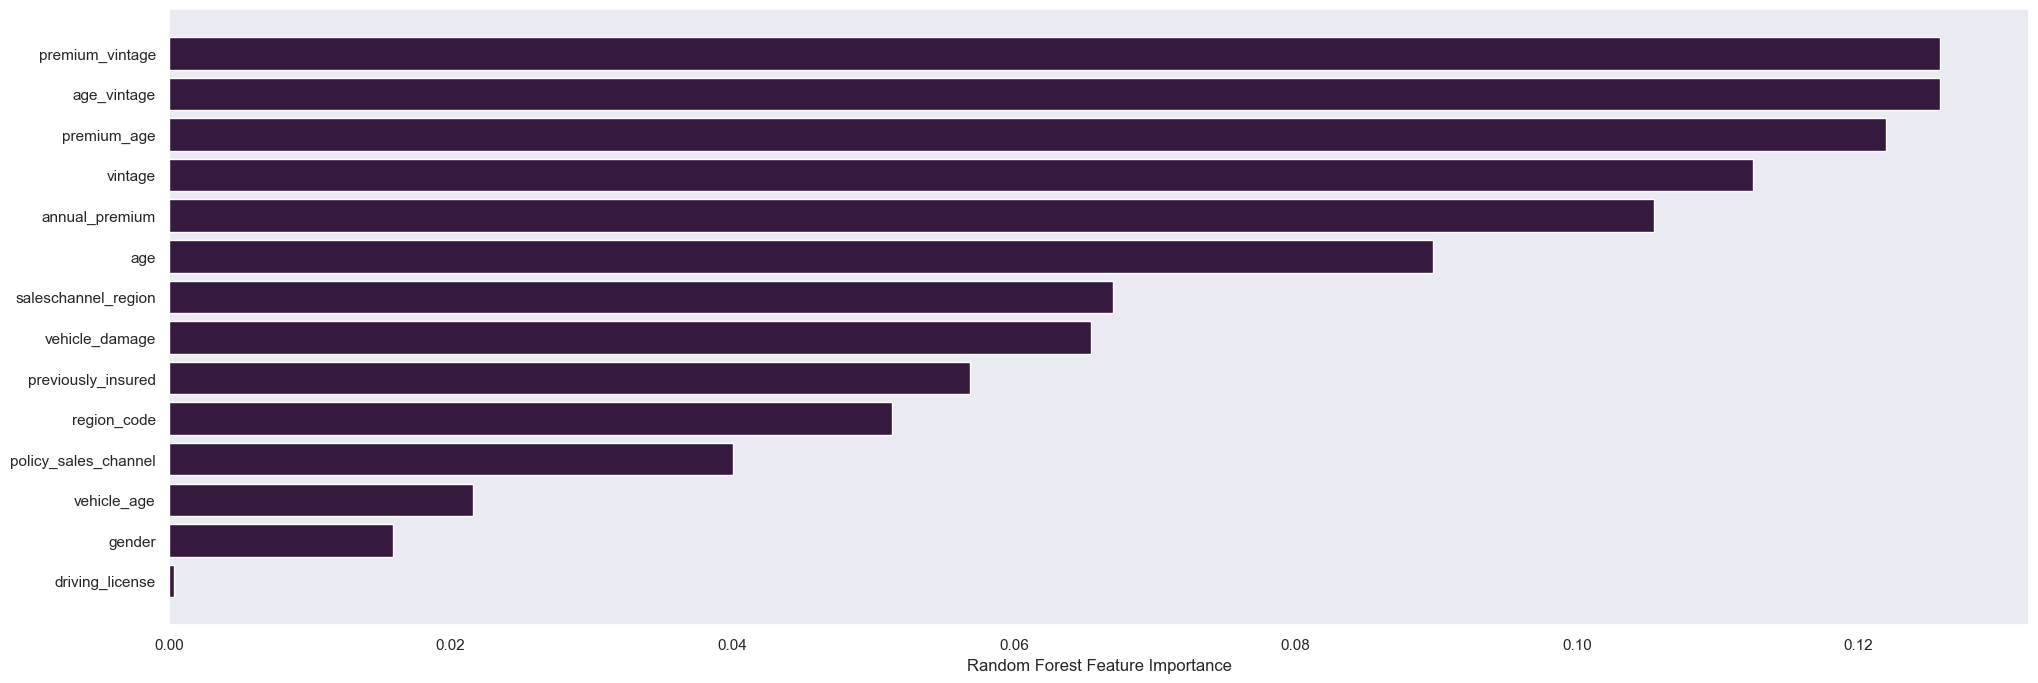

In [51]:
# Display feature importance by Random Forest Classifier ≈
sorted_idx = randomforest.feature_importances_.argsort()
plt.barh(X.iloc[:, sorted_idx].columns, randomforest.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

# 5.0 Pipeline

In [52]:
numpipe = Pipeline([('Numerical Imputer', SimpleImputer(missing_values=np.nan, strategy='median'))])
                    

In [53]:
X_cols = ['gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'premium_vintage',
       'saleschannel_region', 'age_vintage', 'premium_age']

column_transf = ColumnTransformer([('Numerical Transformations', numpipe, X_cols)])

column_transf

ColumnTransformer(transformers=[('Numerical Transformations',
                                 Pipeline(steps=[('Numerical Imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['gender', 'age', 'region_code',
                                  'policy_sales_channel', 'driving_license',
                                  'vehicle_age', 'vehicle_damage',
                                  'previously_insured', 'annual_premium',
                                  'vintage', 'premium_vintage',
                                  'saleschannel_region', 'age_vintage',
                                  'premium_age'])])

In [102]:
pipetransf = Pipeline([('Feature Engineering',pipefeat), 
                       ('Preprocessing', column_transf)])
pipetransf

Pipeline(steps=[('Feature Engineering',
                 Pipeline(steps=[('Feature Engineering',
                                  FeatureEngineering())])),
                ('Preprocessing',
                 ColumnTransformer(transformers=[('Numerical Transformations',
                                                  Pipeline(steps=[('Numerical '
                                                                   'Imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['gender', 'age',
                                                   'region_code',
                                                   'policy_sales_channel',
                                                   'driving_license',
                                                   'vehicle_age',
                                                   'vehicle_damage',
                                                   'previously_insured',
                                                   'annual_premium', 'vintage',
                                                   'premium_vintage',
                                                   'saleschannel_region',
                                                   'age_vintage',
                                                   'premium_age'])]))])

# 6.0 Models

In [55]:
df_train, val = train_test_split(train, shuffle=True, stratify=train.response, random_state=25)

In [56]:
X_train = df_train.drop(columns=['id', 'response'])
y_train = df_train.response

In [57]:
X_val = val.drop(columns=['id', 'response'])
y_val = val.response

In [58]:
X_train = pipetransf.fit_transform(X_train)

X_val = pipetransf.transform(X_val)

## 6.1 Perfect Model

In [59]:
y_perf = []
for i in y_val:
    if i == 0:
        y_perf.append([1,0])
    else:
        y_perf.append([0,1])


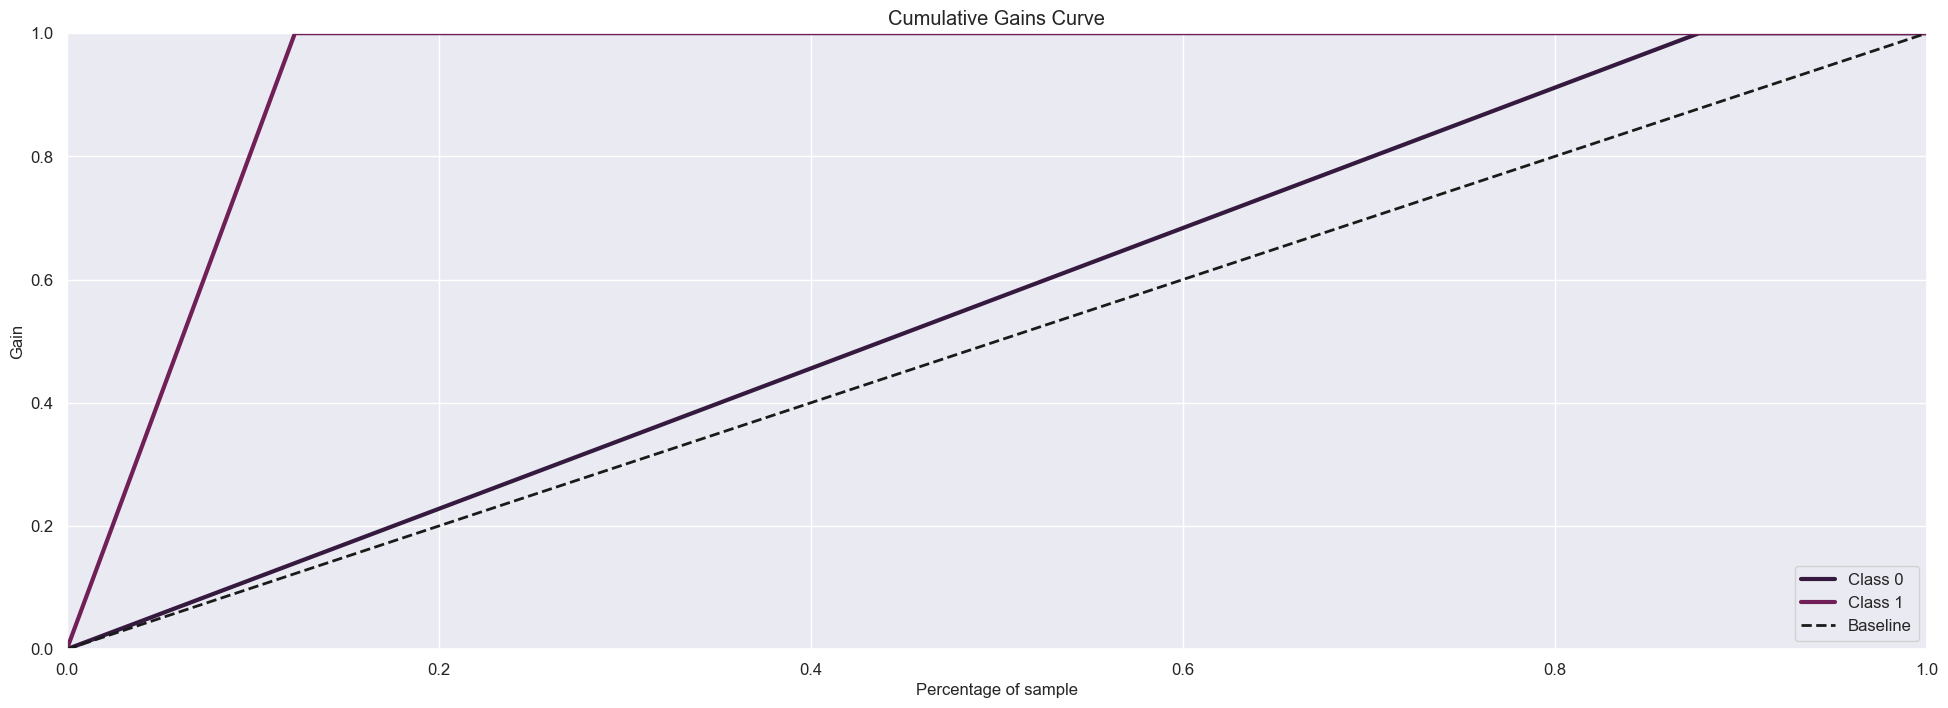

In [60]:
skplt.metrics.plot_cumulative_gain(y_val, y_perf);

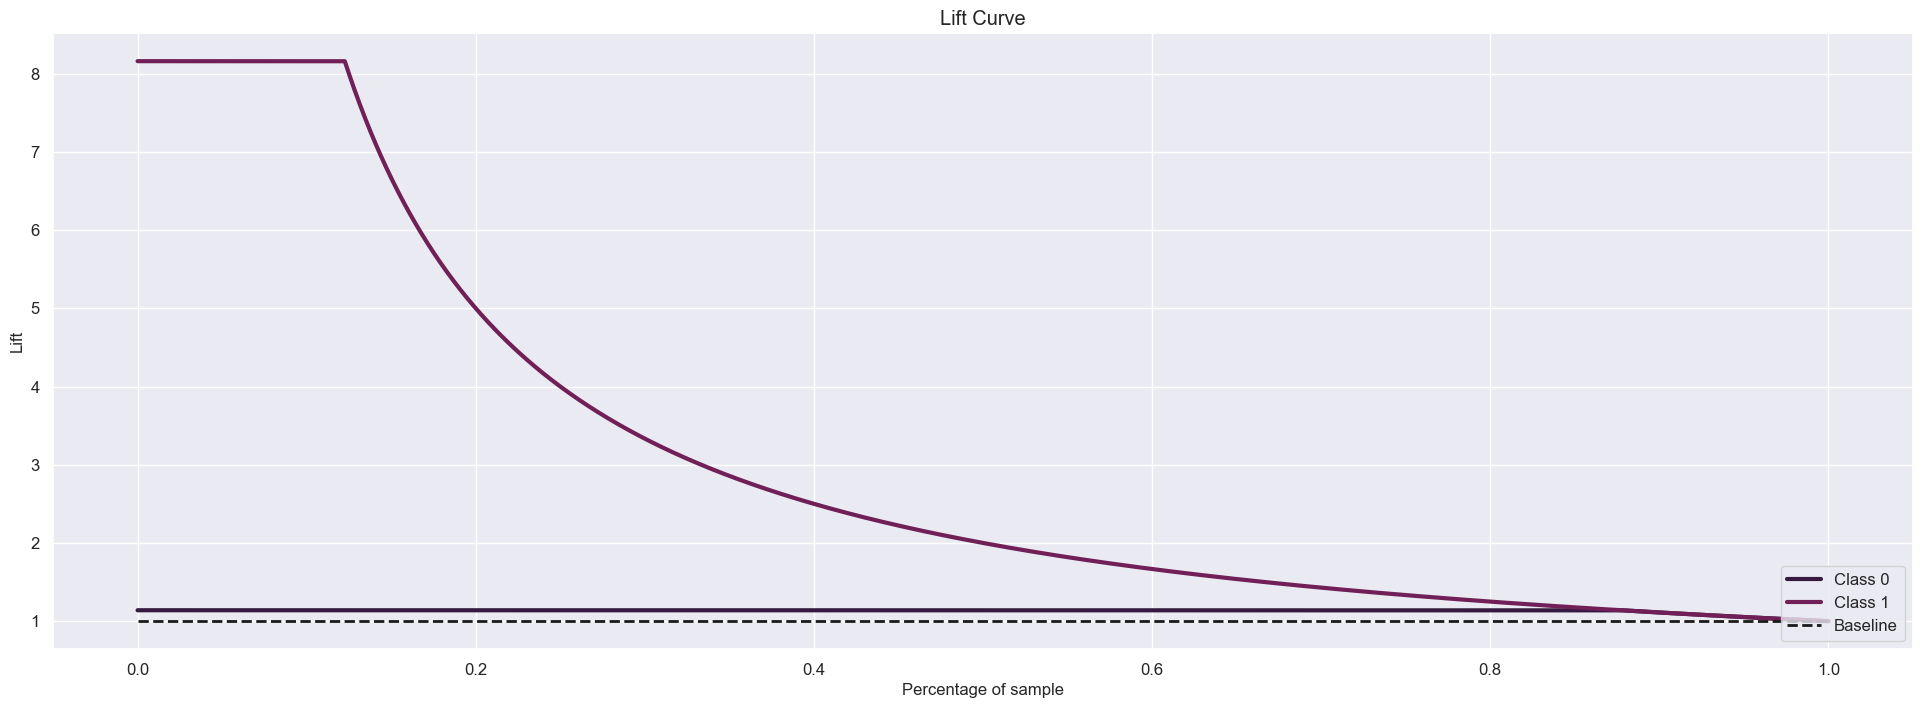

In [61]:
skplt.metrics.plot_lift_curve(y_val, y_perf);

## 6.2 Random Forest

In [62]:
rf = RandomForestClassifier(n_jobs=-1, random_state=25)

rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=25)

In [63]:
y_pred_rf = rf.predict_proba(X_val)

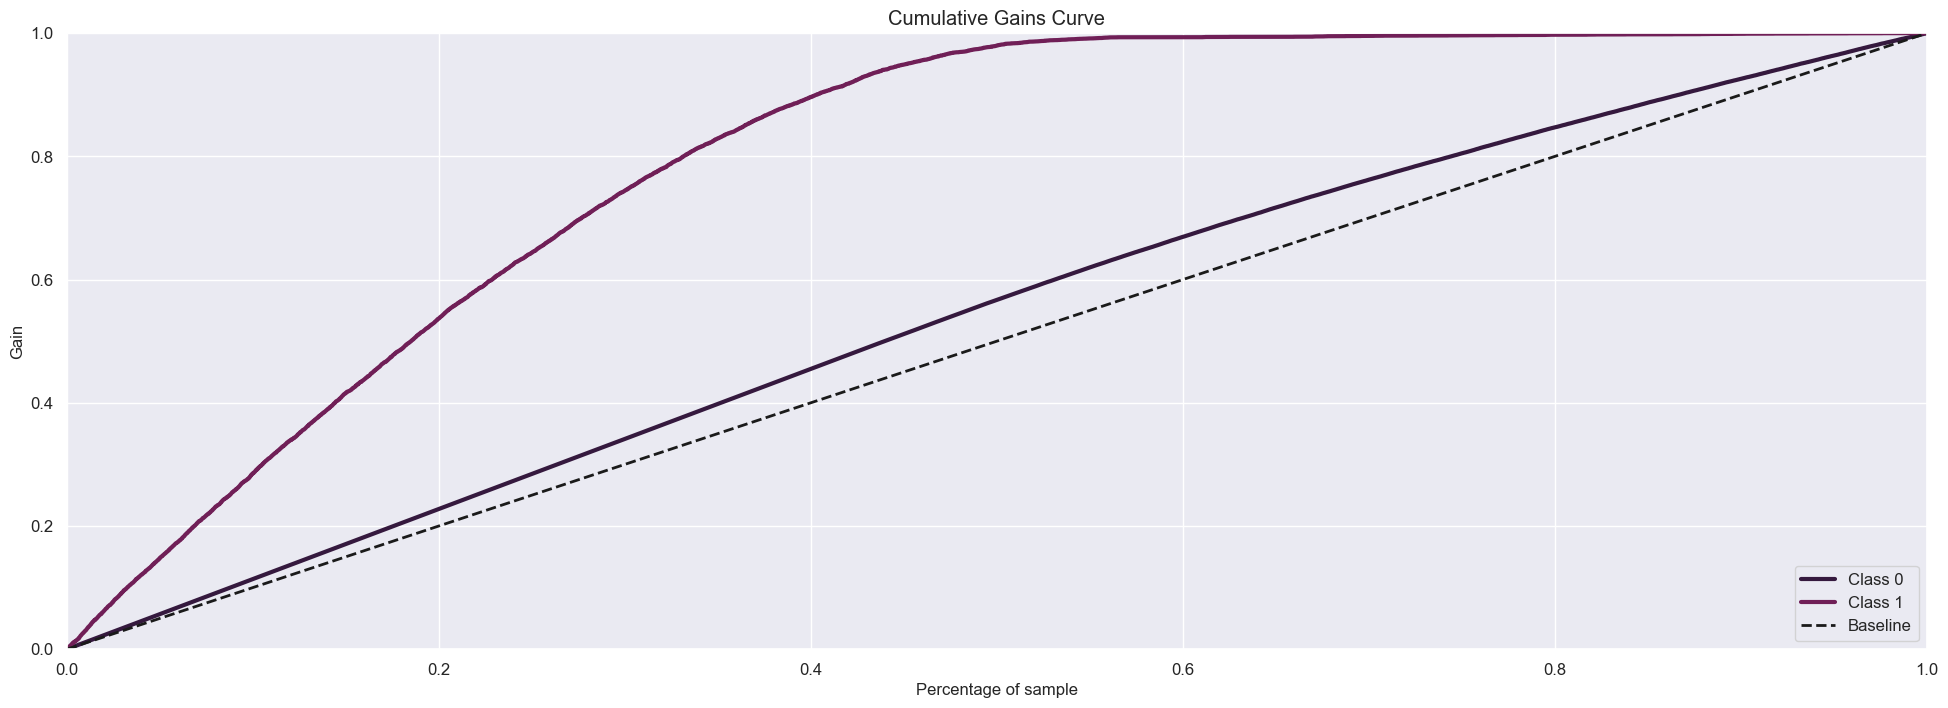

In [64]:
skplt.metrics.plot_cumulative_gain(y_val, y_pred_rf);

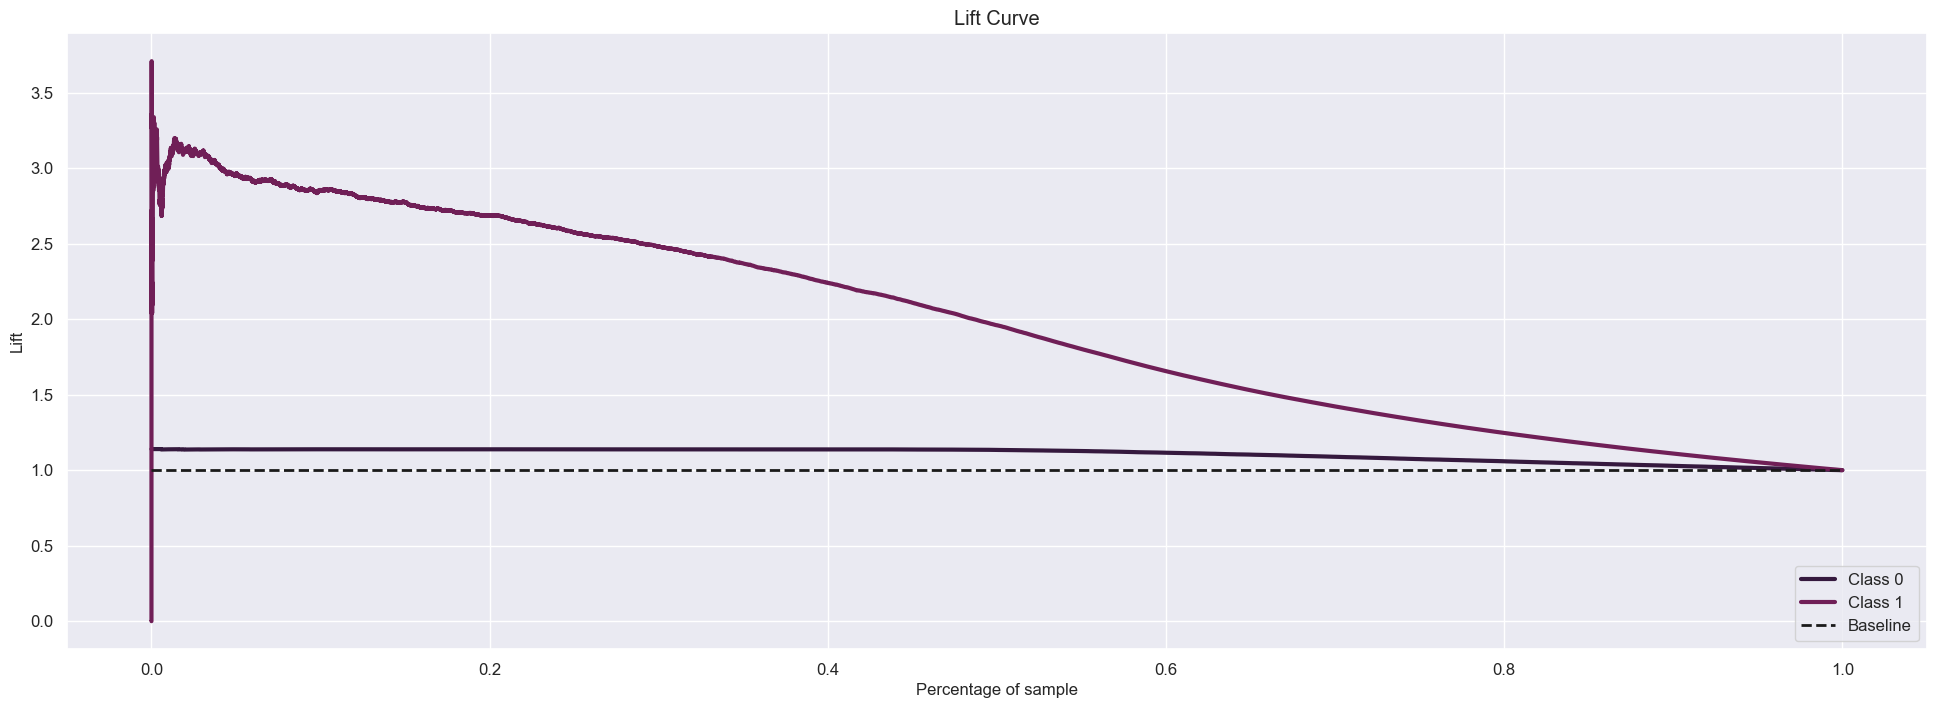

In [65]:
#quanto o modelo é melhor que o baseline
skplt.metrics.plot_lift_curve(y_val, y_pred_rf);

## 6.3 Extra Tree

In [66]:
et = ExtraTreesClassifier(n_jobs=-1, random_state=25)

et.fit(X_train, y_train)

ExtraTreesClassifier(n_jobs=-1, random_state=25)

In [67]:
y_pred_et = et.predict_proba(X_val) 

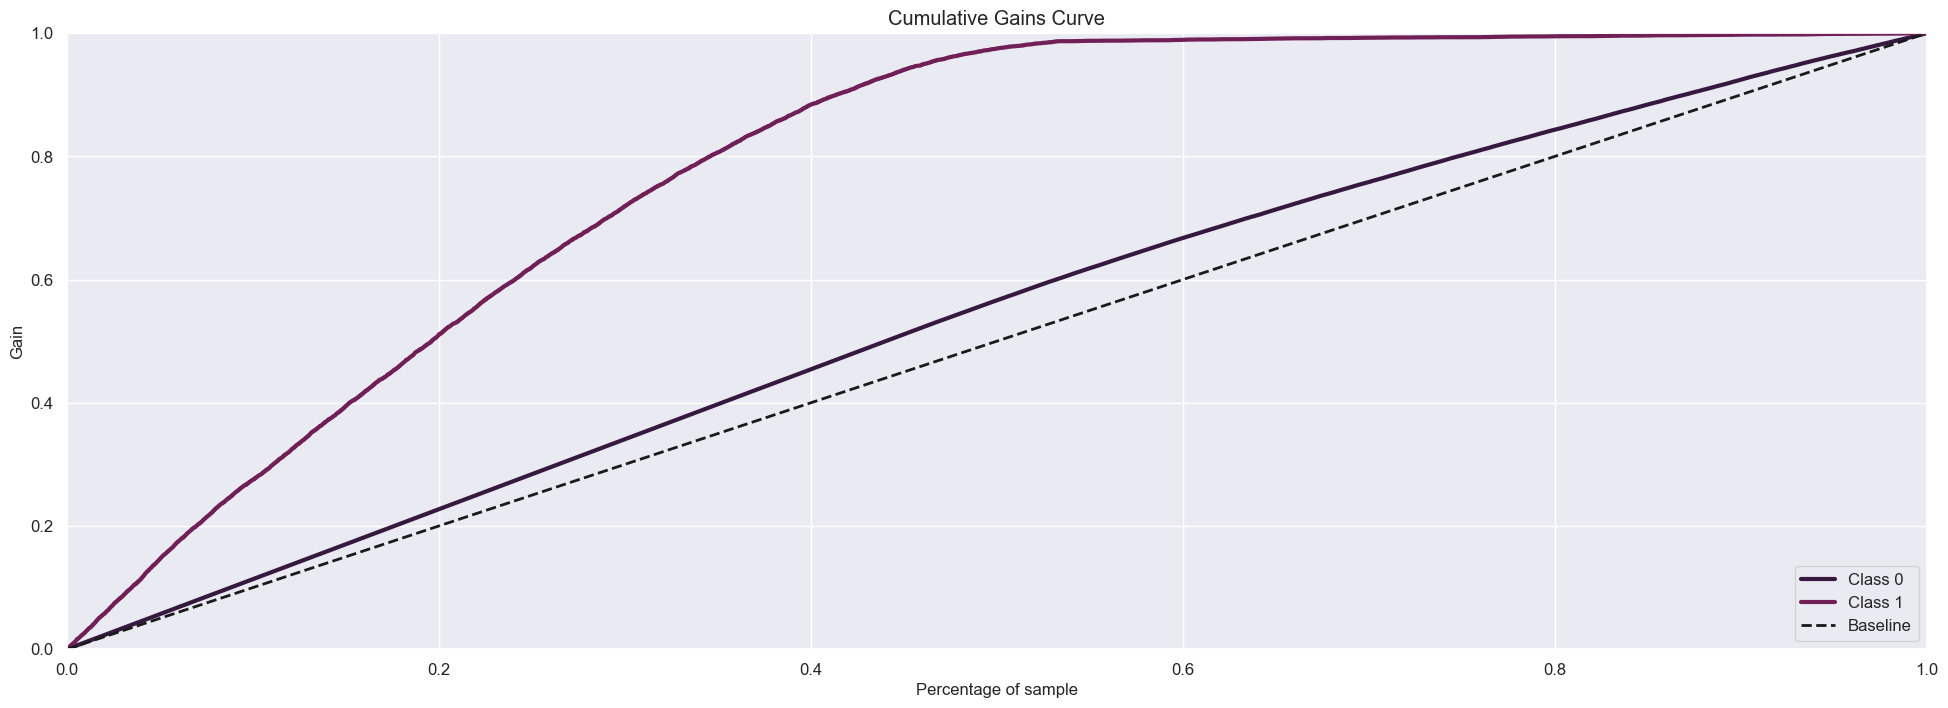

In [68]:
skplt.metrics.plot_cumulative_gain(y_val, y_pred_et);

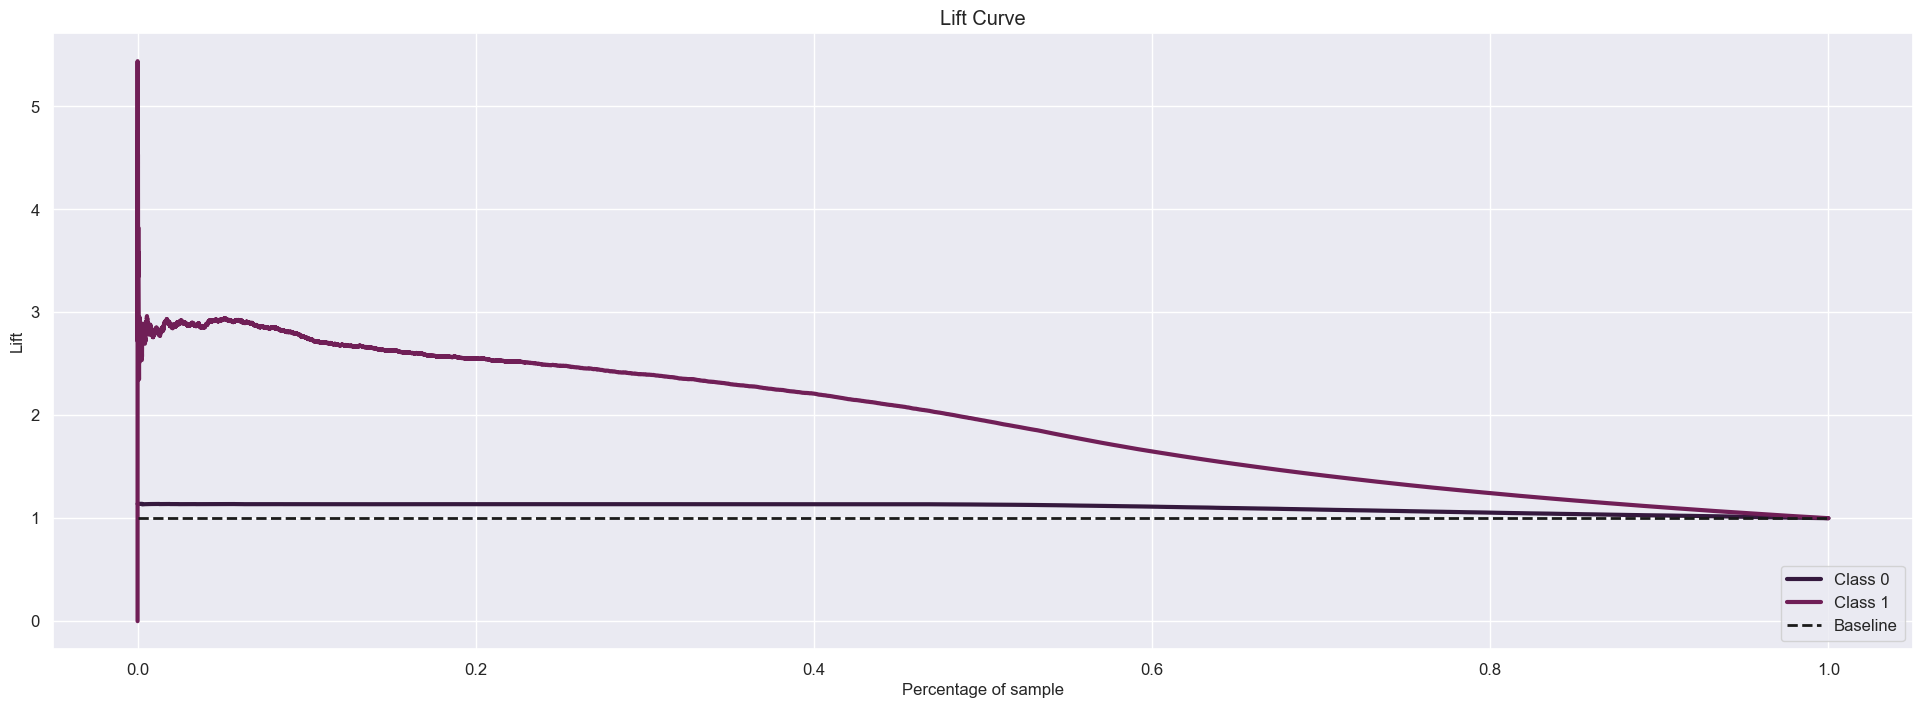

In [69]:
skplt.metrics.plot_lift_curve(y_val, y_pred_et);

## 6.4 KNN Classifier 

In [70]:
knn = KNeighborsClassifier(n_jobs=-1)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [71]:
y_pred_knn = knn.predict_proba(X_val)

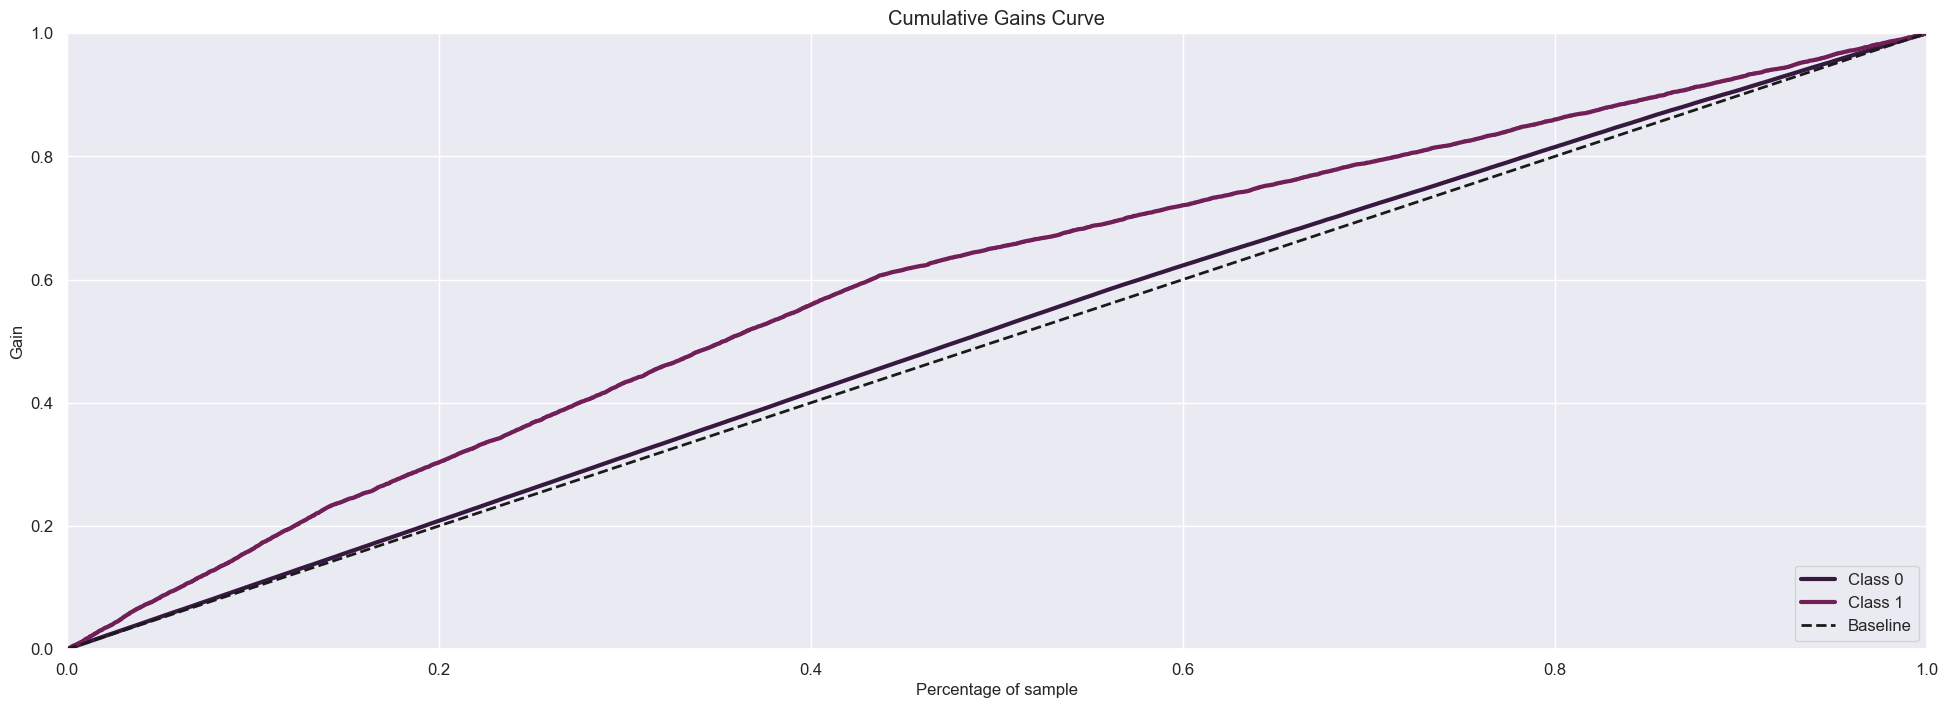

In [72]:
skplt.metrics.plot_cumulative_gain(y_val, y_pred_knn);

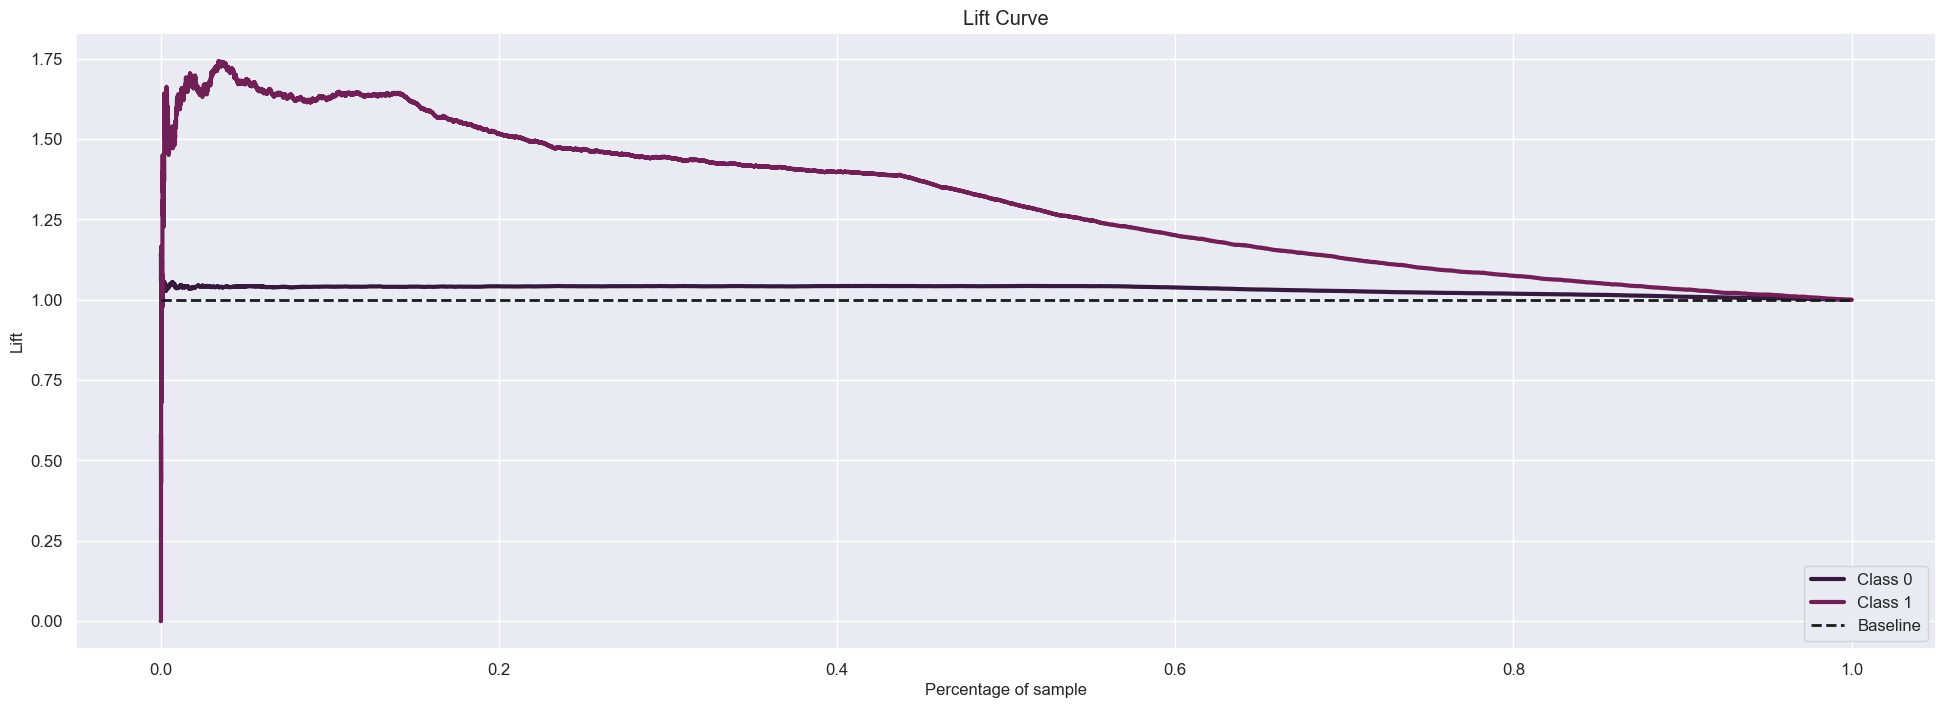

In [73]:
skplt.metrics.plot_lift_curve(y_val, y_pred_knn);

## 6.5 Logistic Regression

In [74]:
lr = LogisticRegression(n_jobs=-1, random_state=25)

lr.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=25)

In [75]:
y_pred_lr = lr.predict_proba(X_val)

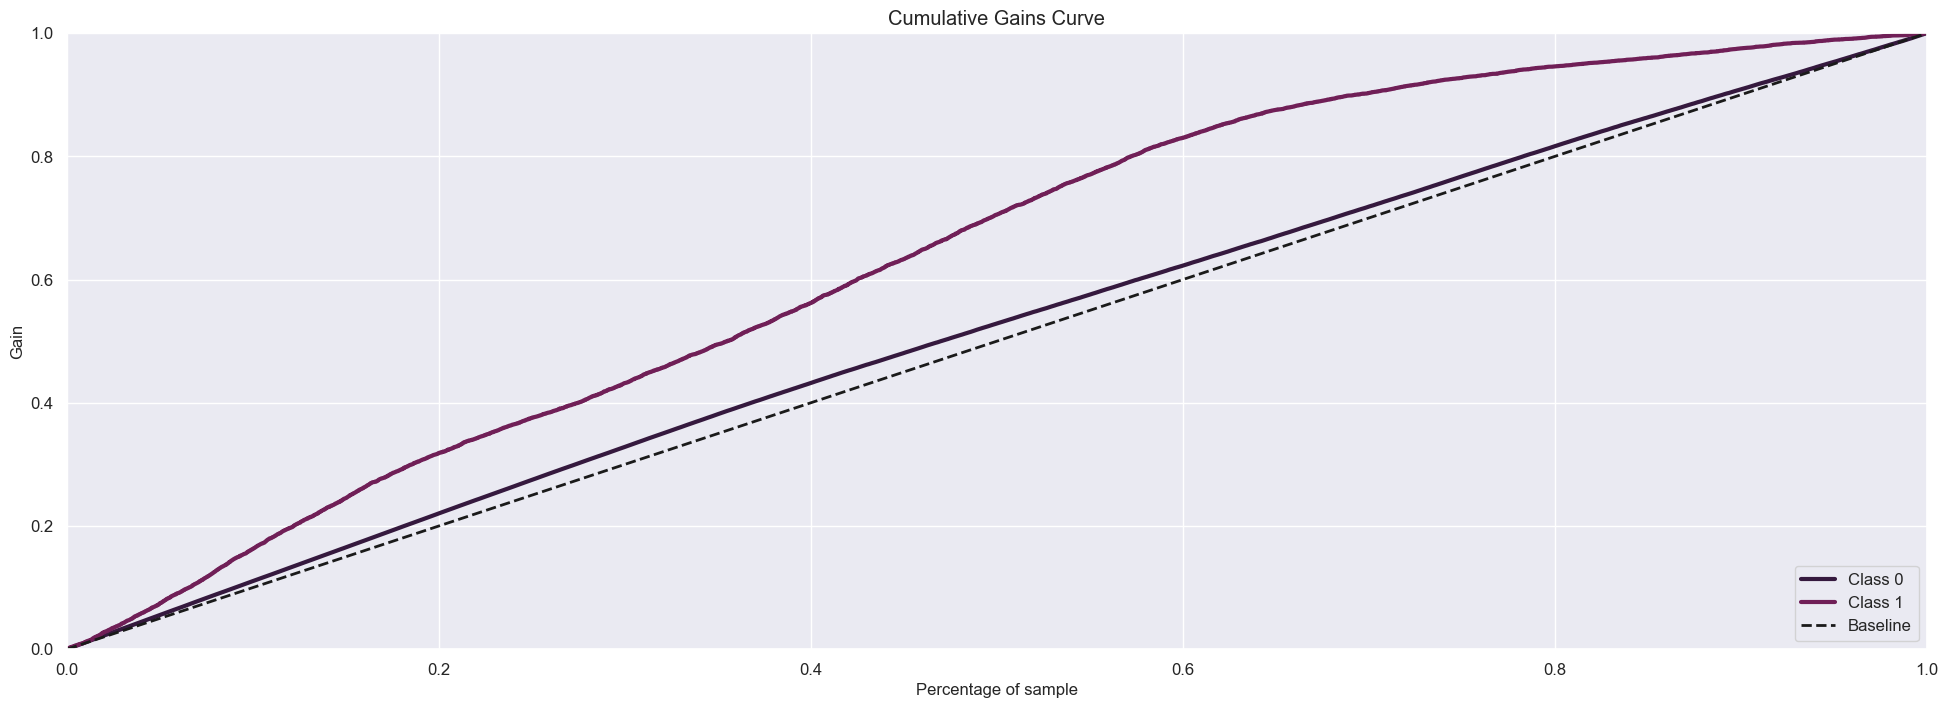

In [76]:
skplt.metrics.plot_cumulative_gain(y_val, y_pred_lr);

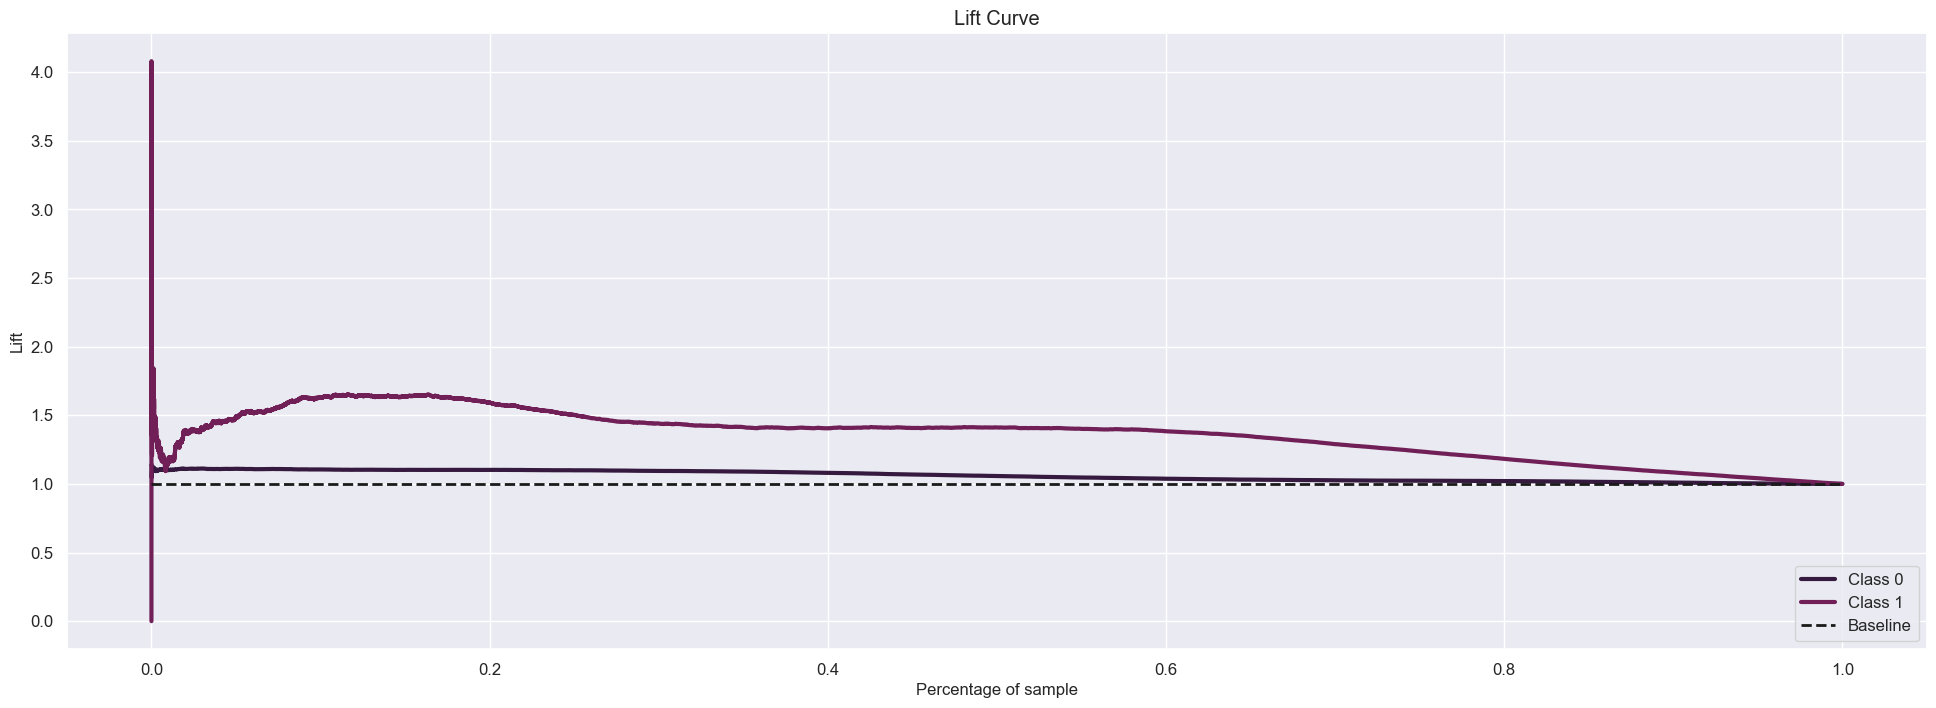

In [77]:
skplt.metrics.plot_lift_curve(y_val, y_pred_lr);

## 6.6 XGBoost 

In [78]:
xgb = XGBClassifier(n_jobs=-1, random_state=25)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=25, ...)

In [79]:
y_pred_xgb = xgb.predict_proba(X_val)

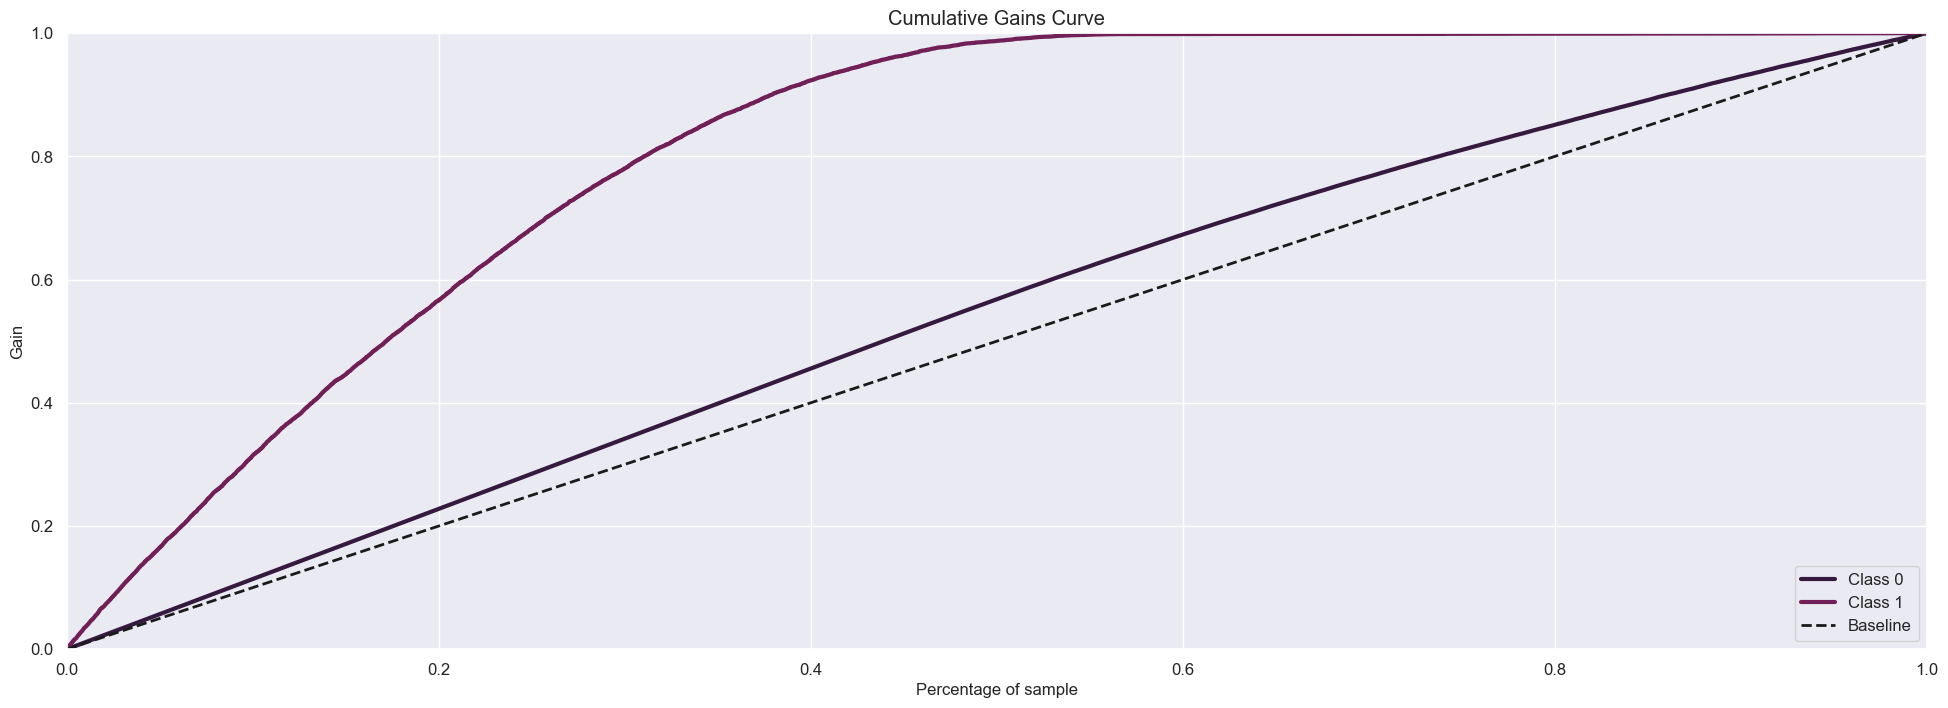

In [80]:
skplt.metrics.plot_cumulative_gain(y_val, y_pred_xgb);

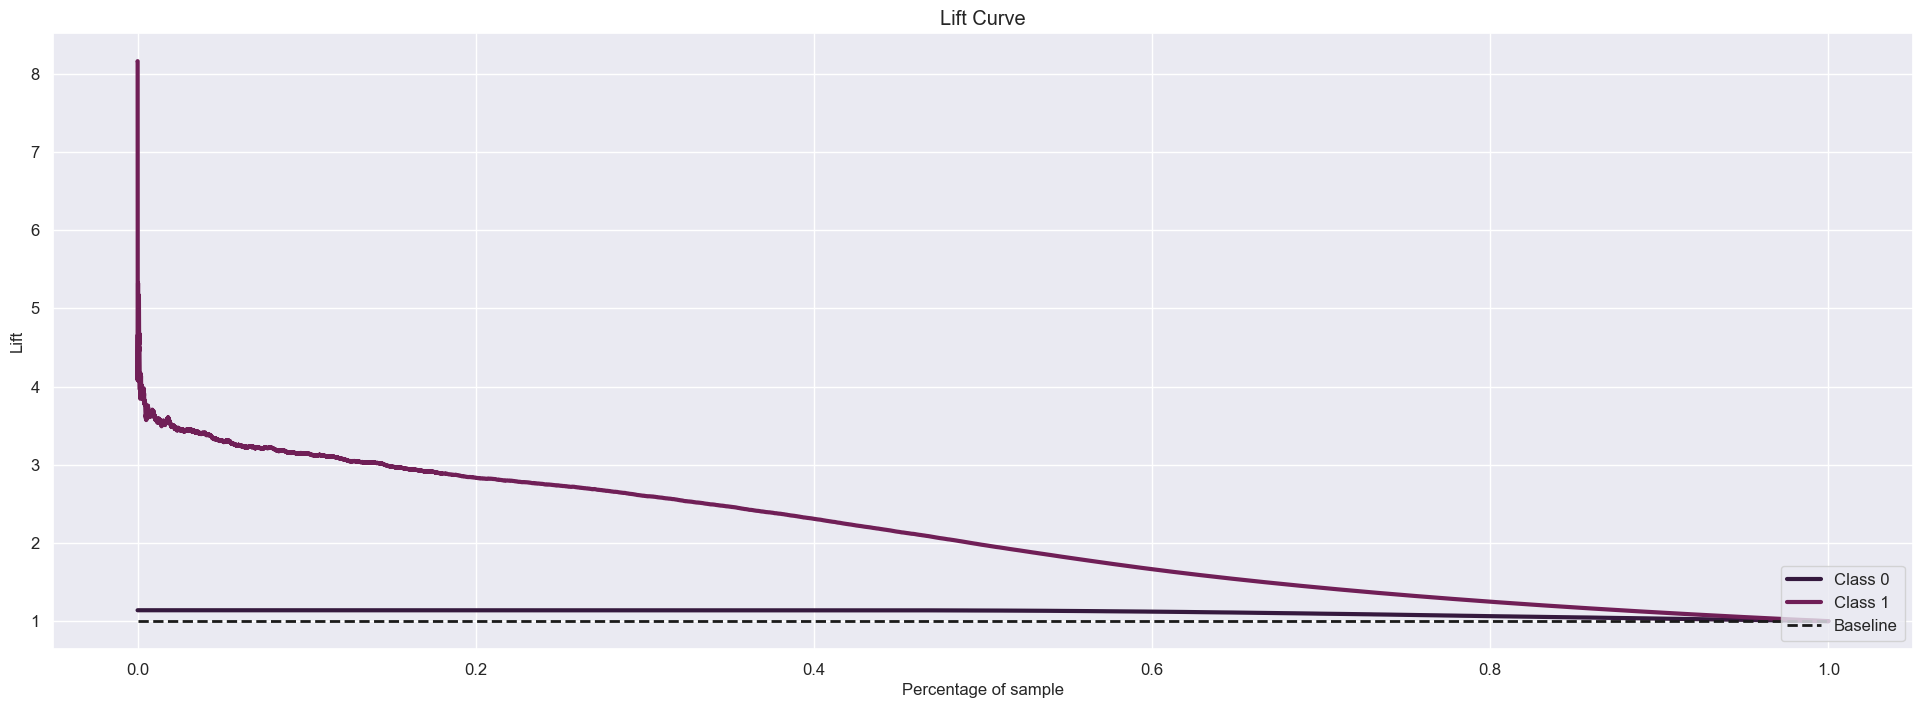

In [81]:
skplt.metrics.plot_lift_curve(y_val, y_pred_xgb);

## 6.7 LGBM 

In [82]:
lgbm = LGBMClassifier(n_jobs=-1, random_state=25)

lgbm.fit(X_train, y_train)

LGBMClassifier(random_state=25)

In [83]:
y_pred_lgbm = lgbm.predict_proba(X_val)

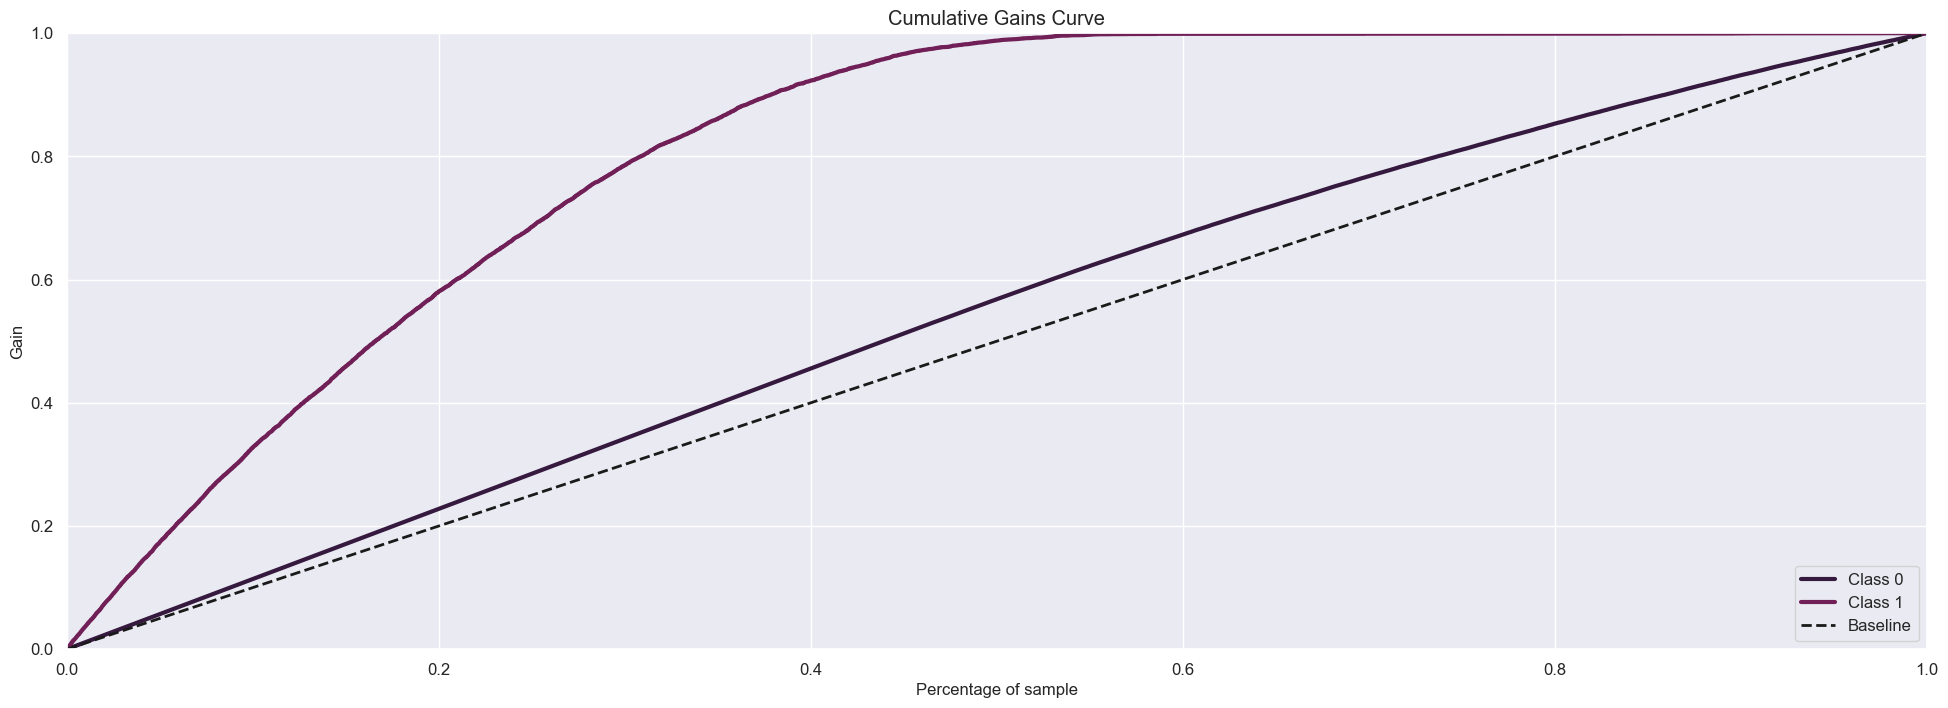

In [84]:
skplt.metrics.plot_cumulative_gain(y_val, y_pred_lgbm);

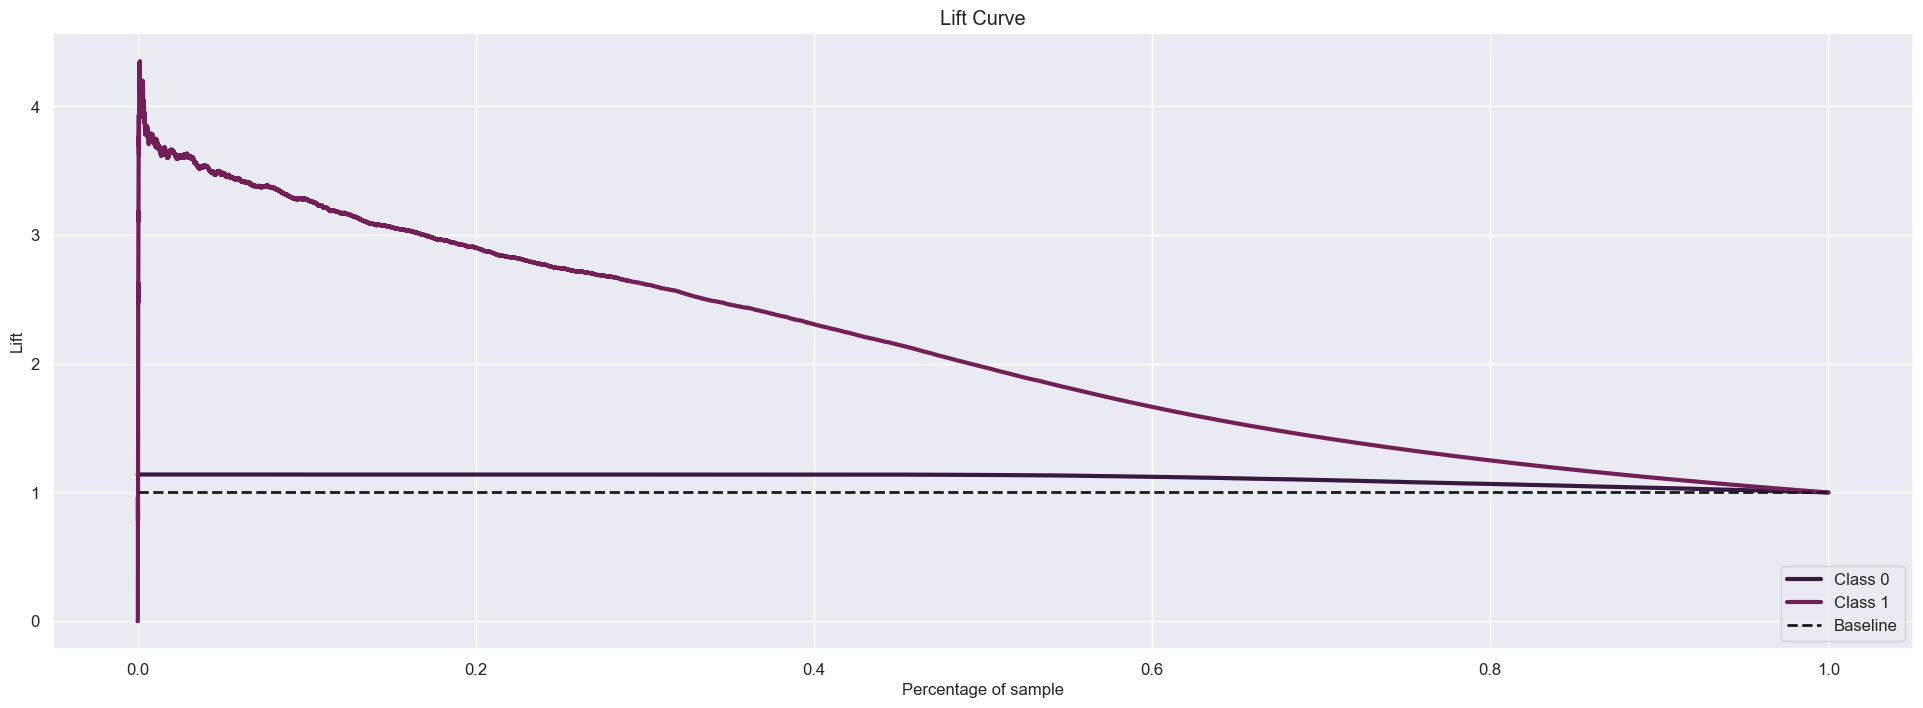

In [85]:
skplt.metrics.plot_lift_curve(y_val, y_pred_lgbm);

## 6.8 CatBoost

In [86]:
cat = CatBoostClassifier(verbose=False, random_seed=25)

cat.fit(X_train, y_train)

In [87]:
y_pred_cat = cat.predict_proba(X_val)

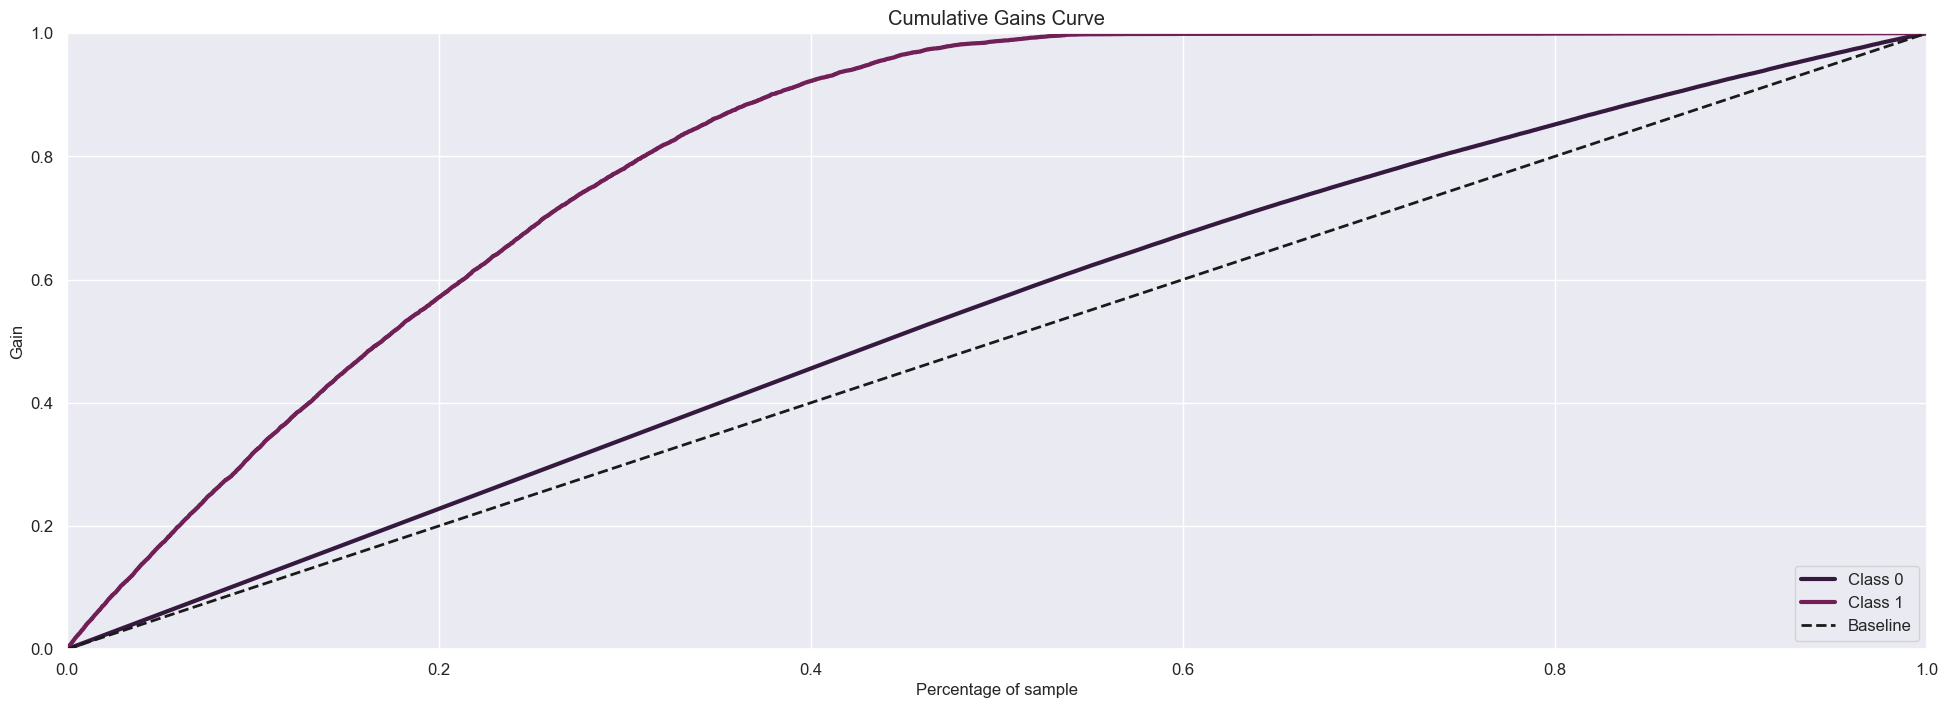

In [88]:
skplt.metrics.plot_cumulative_gain(y_val, y_pred_cat);

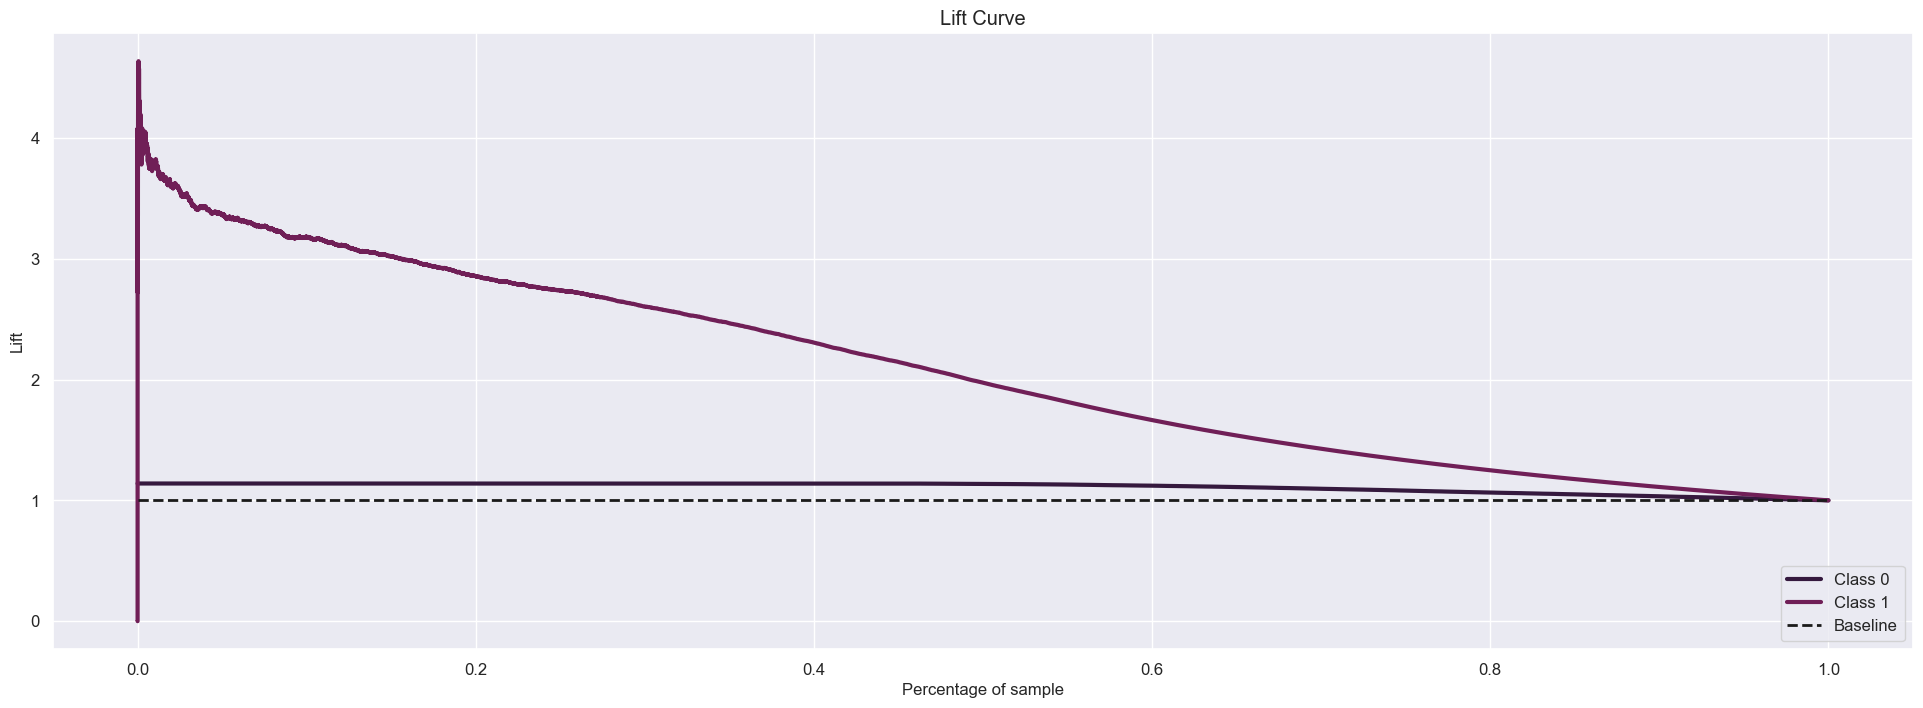

In [89]:
skplt.metrics.plot_lift_curve(y_val, y_pred_cat);

## 6.9 Compare Gains and Lift Curve

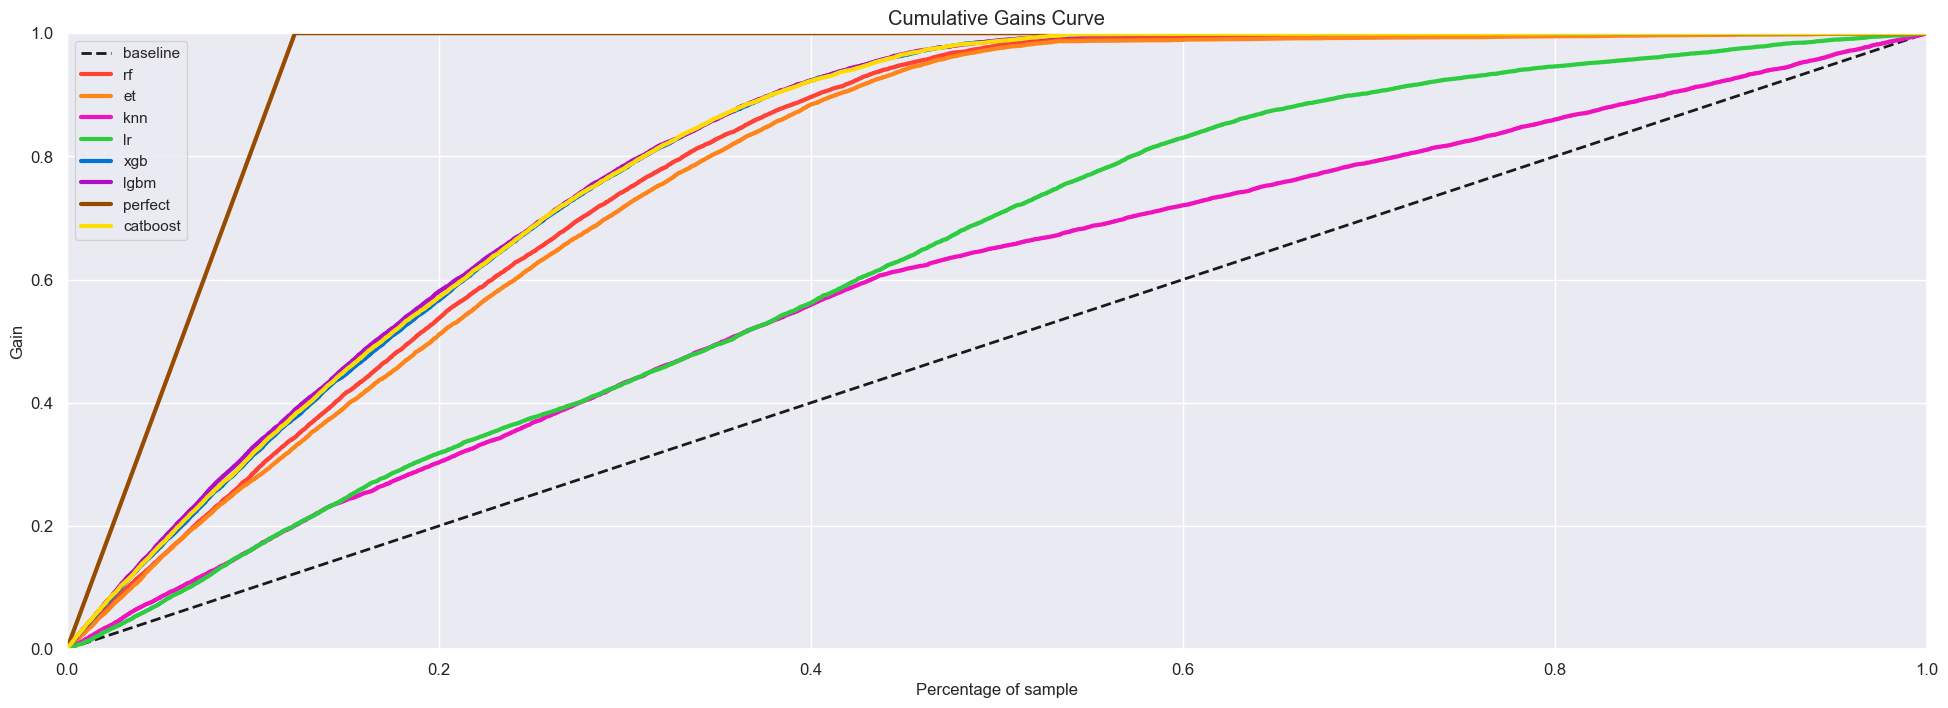

In [90]:
colors = ['#FF4136', '#FF4136', '#FF851B', '#FF851B', '#F012BE', '#F012BE',  '#2ECC40', '#2ECC40', '#0074D9', 
          '#0074D9', '#B10DC9', '#B10DC9', '#964B00', '#964B00', '#FFDC00', '#FFDC00' , '#AAAAAA', '#AAAAAA']

sns.set_theme(palette = colors)
ax = skplt.metrics.plot_cumulative_gain(y_val, y_pred_rf);
art.remove(ax.lines[0])

ax1 = skplt.metrics.plot_cumulative_gain(y_val, y_pred_et, ax=ax);
art.remove(ax.lines[2])
art.remove(ax.lines[3])

ax2 = skplt.metrics.plot_cumulative_gain(y_val, y_pred_knn, ax=ax1);
art.remove(ax.lines[5])
art.remove(ax.lines[3])

ax3 = skplt.metrics.plot_cumulative_gain(y_val, y_pred_lr, ax=ax2);
art.remove(ax.lines[6])
art.remove(ax.lines[4])

ax4 = skplt.metrics.plot_cumulative_gain(y_val, y_pred_xgb, ax=ax3);
art.remove(ax.lines[7])
art.remove(ax.lines[5])

ax5 = skplt.metrics.plot_cumulative_gain(y_val, y_pred_lgbm, ax=ax4);
art.remove(ax.lines[8])
art.remove(ax.lines[6])

ax6 = skplt.metrics.plot_cumulative_gain(y_val, y_perf, ax=ax5);
art.remove(ax.lines[9])
art.remove(ax.lines[7])

ax7 = skplt.metrics.plot_cumulative_gain(y_val, y_pred_cat, ax=ax6);
art.remove(ax.lines[10])
art.remove(ax.lines[8])

ax7.legend([ax7.lines[1],ax7.lines[0],ax7.lines[2],ax7.lines[3],ax7.lines[4],ax7.lines[5],ax7.lines[6],ax7.lines[7], ax7.lines[8]],
           ['baseline','rf','et','knn','lr','xgb','lgbm', 'perfect', 'catboost'])

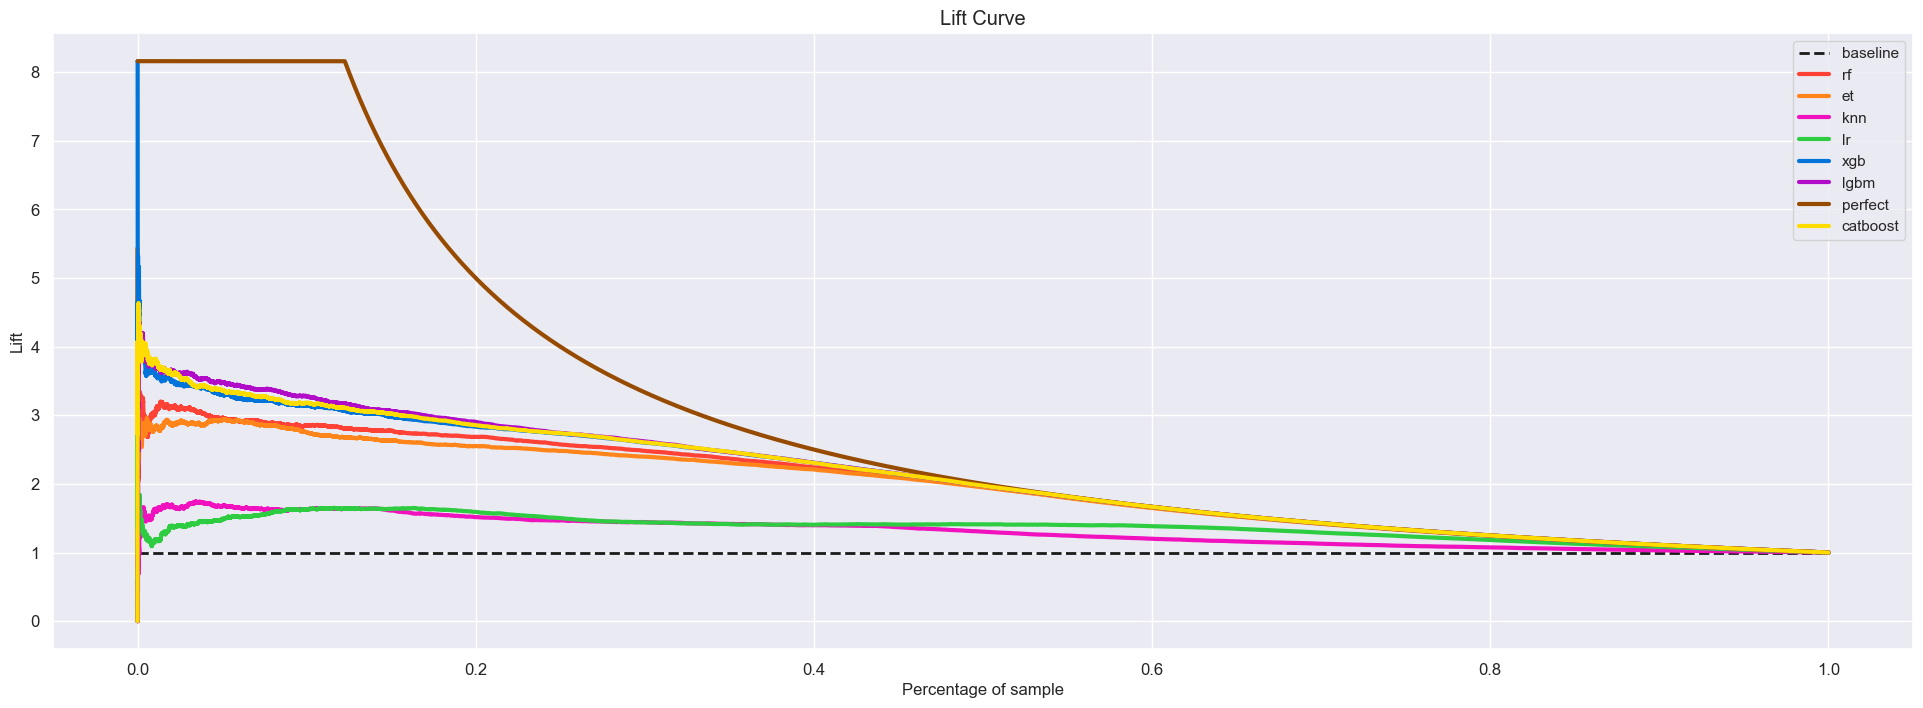

In [91]:
sns.set_theme(palette = colors)
ax = skplt.metrics.plot_lift_curve(y_val, y_pred_rf);
art.remove(ax.lines[0])

ax1 = skplt.metrics.plot_lift_curve(y_val, y_pred_et, ax=ax);
art.remove(ax.lines[2])
art.remove(ax.lines[3])

ax2 = skplt.metrics.plot_lift_curve(y_val, y_pred_knn, ax=ax1);
art.remove(ax.lines[5])
art.remove(ax.lines[3])

ax3 = skplt.metrics.plot_lift_curve(y_val, y_pred_lr, ax=ax2);
art.remove(ax.lines[6])
art.remove(ax.lines[4])

ax4 = skplt.metrics.plot_lift_curve(y_val, y_pred_xgb, ax=ax3);
art.remove(ax.lines[7])
art.remove(ax.lines[5])

ax5 = skplt.metrics.plot_lift_curve(y_val, y_pred_lgbm, ax=ax4);
art.remove(ax.lines[8])
art.remove(ax.lines[6])

ax6 = skplt.metrics.plot_lift_curve(y_val, y_perf, ax=ax5);
art.remove(ax.lines[9])
art.remove(ax.lines[7])

ax7 = skplt.metrics.plot_lift_curve(y_val, y_pred_cat, ax=ax6);
art.remove(ax.lines[10])
art.remove(ax.lines[8])

ax7.legend([ax7.lines[1],ax7.lines[0],ax7.lines[2],ax7.lines[3],ax7.lines[4],ax7.lines[5],ax7.lines[6],ax7.lines[7], ax7.lines[8]],
           ['baseline','rf','et','knn','lr','xgb','lgbm', 'perfect', 'catboost'])

## 6.10 Metrics

In [92]:
#prec_at_k = [prec_at_k_rf, prec_at_k_et, prec_at_k_knn, prec_at_k_lr, prec_at_k_xgb, 
#             prec_at_k_lgbm, prec_at_k_cat]
#models = ['Random Forest', 'Extra Trees', 'Knn', 'Logistic Regression', 'XGBoost', 'LGBM', CatBoost]
#
#pd.DataFrame({'models': models,
#              'Precision at 5000': prec_at_k}).sort_values('Precision at 5000', ascending=False)

NameError: name 'prec_at_k_rf' is not defined

# 7.0 Cross Validation

In [93]:
cross_validation = StratifiedKFold(n_splits=5, shuffle=False)

In [117]:
metric = pj()
metric.metrics_cv(cat, train, cross_validation, 0.4, pipetransf)

,fold,precision_train,precision_test,recall_train,recall_test
0,1,0.291122,0.283905,0.950124,0.926545
1,2,0.291470,0.281773,0.951261,0.919588
2,3,0.291139,0.284244,0.950159,0.927740
3,4,0.291395,0.282112,0.950995,0.920781
4,5,0.291293,0.282563,0.950692,0.922130
5,mean,0.291284,0.282919,0.950646,0.923357


In [118]:
metric.metrics_cv(lgbm, train, cross_validation, 0.4, pipetransf)

,fold,precision_train,precision_test,recall_train,recall_test
0,1,0.286479,0.283782,0.934970,0.926144
1,2,0.288385,0.282142,0.941192,0.920792
2,3,0.286978,0.283875,0.936578,0.926536
3,4,0.288075,0.283178,0.940157,0.924261
4,5,0.287070,0.283260,0.936910,0.924405
5,mean,0.287397,0.283247,0.937962,0.924427


Ensemble XGB + LGBM através de problabilidades, para compor a performance.

# 8.0 Hyperparameter Finetuning

In [119]:
X,y = train.drop(columns=['response', 'id']), train.response

In [120]:
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, random_state=25, stratify=y)

In [121]:
X_train = pipetransf.fit_transform(X_train)
X_val = pipetransf.transform(X_val)

## LGBM

In [122]:
space = [
         [None, 'balanced'],# class_weight
         (1e-3, 1e-1, 'log-uniform'), # learning_rate
         (2, 128), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0), # colsample bytree
         (1000, 2500) #n_estimators
        ] 

In [123]:
def space_model(params):
    class_weight = params[0]
    learning_rate = params[1]
    num_leaves = params[2]
    min_child_samples = params[3]
    subsample = params[4] 
    colsample_bytree = params[5] 
    n_estimators = params[6]

    mdl = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, class_weight= class_weight,
                         min_child_samples=min_child_samples, subsample=subsample, 
                         colsample_bytree=colsample_bytree, random_state=25, subsample_freq=1,
                         n_estimators=n_estimators, n_jobs=-1)
    return mdl

In [124]:
bayesian = BayesianSearchCV(cross_validation, pipetransf, space, space_model, n_calls= 15 )

In [125]:
bayesian.fit(X, y)


Fold: 1

Fold: 2

Fold: 3

Fold: 4

Fold: 5


In [126]:
bayesian.cv_results_

,boosting_type,class_weight,colsample_bytree,importance_type,learning_rate,max_depth,min_child_samples,min_child_weight,min_split_gain,n_estimators,n_jobs,num_leaves,objective,random_state,reg_alpha,reg_lambda,silent,subsample,subsample_for_bin,subsample_freq,train_score,test_score
0,gbdt,None,0.361748,split,0.012536,-1,90,0.001,0.0,2426,-1,61,None,25,0.0,0.0,warn,0.763726,200000,1,0.298112,0.284806
1,gbdt,balanced,0.583636,split,0.010989,-1,72,0.001,0.0,2138,-1,88,None,25,0.0,0.0,warn,0.602919,200000,1,0.303565,0.283044
2,gbdt,balanced,0.684951,split,0.010803,-1,43,0.001,0.0,2221,-1,25,None,25,0.0,0.0,warn,0.563762,200000,1,0.291713,0.284449
3,gbdt,balanced,0.188342,split,0.005442,-1,18,0.001,0.0,1838,-1,115,None,25,0.0,0.0,warn,0.925907,200000,1,0.292861,0.283711
4,gbdt,None,0.453506,split,0.003510,-1,81,0.001,0.0,2254,-1,62,None,25,0.0,0.0,warn,0.505978,200000,1,0.288864,0.284285


In [127]:
bayesian.best_parameters_

,column,mean_or_mode
0,boosting_type,gbdt
1,class_weight,balanced
2,colsample_bytree,0.454437
3,importance_type,split
4,learning_rate,0.008656
5,max_depth,-1
6,min_child_samples,60
7,min_child_weight,0.001
8,min_split_gain,0.0
9,n_estimators,2175


In [128]:
lgbm = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', colsample_bytree=0.740105,importance_type='split', 
                      learning_rate=0.013875, max_depth=-1, min_child_samples=73,min_child_weight=0.001,min_split_gain=0.0,
                      n_estimators=1296, n_jobs=-1, num_leaves=55, objective=None,random_state=25, reg_alpha=0.0,
                      reg_lambda=0.0, silent='warn', subsample=0.913048, subsample_for_bin=200000, subsample_freq=1)

In [129]:
lgbm_pipe = Pipeline([('LGBM Classifier', lgbm)])
lgbm_pipe

Pipeline(steps=[('LGBM Classifier',
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.740105,
                                learning_rate=0.013875, min_child_samples=73,
                                n_estimators=1296, num_leaves=55,
                                random_state=25, subsample=0.913048,
                                subsample_freq=1))])

In [130]:
lgbm_pipe.fit(X_train, y_train)

y_pred_lgbm = lgbm_pipe.predict_proba(X_val)

In [157]:
metric.make_score(y_val, y_pred_lgbm)

,k,precision_at_k,recall_at_k,score
0,0.05,0.426660,0.174053,0.812515
1,0.10,0.401207,0.327339,0.786882
2,0.15,0.376891,0.461250,0.761100
3,0.20,0.355943,0.580818,0.734491
4,0.25,0.337339,0.688075,0.696404
5,0.30,0.321044,0.785806,0.642390
6,0.35,0.302733,0.864483,0.568049
7,0.40,0.283193,0.924213,0.468892
8,0.45,0.263244,0.966495,0.327099
9,0.50,0.242266,0.988332,0.147888


## CATBOOST

In [132]:
space = [
         (500, 2000), # iterations
         (0.0001, 1.0, 'log-uniform'), # learning_rate
         (4, 10), # depth
         (2, 30), # l2_leaf_rega
         (0.0001, 1.0), # bagging_temperature
         (1, 50), # min_data_in_leaf
         (1, 255), # border_count
         (0.01, 1.0, 'uniform'), # scale_pos_weight
]

In [133]:
def space_model(params):
    iterations = params[0]
    learning_rate = params[1]
    depth = params[2]
    l2_leaf_reg = params[3]
    bagging_temperature = params[4]
    min_data_in_leaf = params[5]
    border_count = params[6]
    scale_pos_weight = params[7]

    mdl = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, 
                             bagging_temperature=bagging_temperature, min_data_in_leaf=min_data_in_leaf, border_count=border_count, 
                             scale_pos_weight=scale_pos_weight, random_seed=0, verbose=False)
    return mdl


In [134]:
bayesian_cat = BayesianSearchCV(cross_validation, pipetransf, space, space_model, n_calls= 15 )

In [135]:
bayesian_cat.fit(X, y)


Fold: 1

Fold: 2

Fold: 3

Fold: 4

Fold: 5


In [136]:
bayesian_cat.cv_results_

,iterations,learning_rate,depth,l2_leaf_reg,border_count,random_seed,verbose,bagging_temperature,scale_pos_weight,min_data_in_leaf,train_score,test_score
0,1022,0.047831,7,24,233,0,False,0.614298,0.406223,4,0.286591,0.283987
1,1581,0.021285,7,23,48,0,False,0.105997,0.739549,24,0.287278,0.282019
2,525,0.091615,8,19,216,0,False,0.669102,0.544268,3,0.288618,0.284285
3,1581,0.021285,7,23,48,0,False,0.105997,0.739549,24,0.286783,0.283260
4,1581,0.021285,7,23,48,0,False,0.105997,0.739549,24,0.286763,0.284039


In [137]:
bayesian_cat.best_parameters_

,column,mean_or_mode
0,iterations,1258
1,learning_rate,0.04066
2,depth,7
3,l2_leaf_reg,22
4,border_count,118
5,random_seed,0
6,bagging_temperature,0.320278
7,scale_pos_weight,0.633828
8,min_data_in_leaf,15


In [139]:
cat = CatBoostClassifier(iterations=1258, learning_rate=0.04066, depth=7, l2_leaf_reg=22, 
                             bagging_temperature=0.320278, min_data_in_leaf=15, border_count=118, 
                             scale_pos_weight=0.633828, random_seed=0, verbose=False)

In [140]:
cat_pipe = Pipeline([('CatBoost', cat)])
cat_pipe

Pipeline(steps=[('CatBoost',
                 <catboost.core.CatBoostClassifier object at 0x000001880EBF1AF0>)])

In [141]:
cat_pipe.fit(X_train, y_train)

y_pred_cat = cat_pipe.predict_proba(X_val)

In [156]:
metric.make_score(y_val, y_pred_cat)

,k,precision_at_k,recall_at_k,score
0,0.05,0.422986,0.172554,0.289385
1,0.10,0.398321,0.324984,0.254769
2,0.15,0.374267,0.458039,0.225241
3,0.20,0.353057,0.576108,0.200838
4,0.25,0.336552,0.686470,0.175140
5,0.30,0.320913,0.785485,0.145074
6,0.35,0.303407,0.866410,0.110623
7,0.40,0.282603,0.922286,0.080625
8,0.45,0.263011,0.965639,0.053005
9,0.50,0.242109,0.987690,0.021046


# 9.0 Pipeline and Model with finetuning

In [143]:
votepipe = VotingClassifier(estimators=[('LGBM', lgbm_pipe),
                                        ('CatBoost', cat_pipe)], voting='soft', n_jobs=-1)
votepipe

VotingClassifier(estimators=[('LGBM',
                              Pipeline(steps=[('LGBM Classifier',
                                               LGBMClassifier(class_weight='balanced',
                                                              colsample_bytree=0.740105,
                                                              learning_rate=0.013875,
                                                              min_child_samples=73,
                                                              n_estimators=1296,
                                                              num_leaves=55,
                                                              random_state=25,
                                                              subsample=0.913048,
                                                              subsample_freq=1))])),
                             ('CatBoost',
                              Pipeline(steps=[('CatBoost',
                                               <catboost.core.CatBoostClassifier object at 0x000001880EBF1AF0>)]))],
                 n_jobs=-1, voting='soft')

# 10.0 Final Pipeline

In [144]:
final_pipe = Pipeline ([('Engineering/Processing', pipetransf), 
                        ('Vote', votepipe)])
final_pipe

Pipeline(steps=[('Engineering/Processing',
                 Pipeline(steps=[('Feature Engineering',
                                  Pipeline(steps=[('Feature Engineering',
                                                   FeatureEngineering())])),
                                 ('Preprocessing',
                                  ColumnTransformer(transformers=[('Numerical '
                                                                   'Transformations',
                                                                   Pipeline(steps=[('Numerical '
                                                                                    'Imputer',
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['gender',
                                                                    'age',
                                                                    'region_code',
                                                                    'policy_sales_channel',
                                                                    '...
                                               Pipeline(steps=[('LGBM '
                                                                'Classifier',
                                                                LGBMClassifier(class_weight='balanced',
                                                                               colsample_bytree=0.740105,
                                                                               learning_rate=0.013875,
                                                                               min_child_samples=73,
                                                                               n_estimators=1296,
                                                                               num_leaves=55,
                                                                               random_state=25,
                                                                               subsample=0.913048,
                                                                               subsample_freq=1))])),
                                              ('CatBoost',
                                               Pipeline(steps=[('CatBoost',
                                                                <catboost.core.CatBoostClassifier object at 0x000001880EBF1AF0>)]))],
                                  n_jobs=-1, voting='soft'))])

In [145]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

In [146]:
X_train = train
y_train = train.response

X_test = test
y_test = test.response


final_pipe.fit(X_train.drop(columns=['id', 'response']), y_train)

y_pred = final_pipe.predict_proba(X_test.drop(columns=['id', 'response']))

In [147]:
X_test['score'] = y_pred[:,1]
X_test = X_test.sort_values('score', ascending=False)

In [155]:
metric.make_score(y_test, y_pred)

,k,precision_at_k,recall_at_k,score
0,0.05,0.422986,0.172554,0.550781
1,0.10,0.389399,0.317705,0.519762
2,0.15,0.369020,0.451616,0.493088
3,0.20,0.356468,0.581674,0.468914
4,0.25,0.341695,0.696960,0.437836
5,0.30,0.325155,0.795868,0.396004
6,0.35,0.303595,0.866945,0.343831
7,0.40,0.283817,0.926247,0.277926
8,0.45,0.263360,0.966924,0.195121
9,0.50,0.242738,0.990259,0.089870


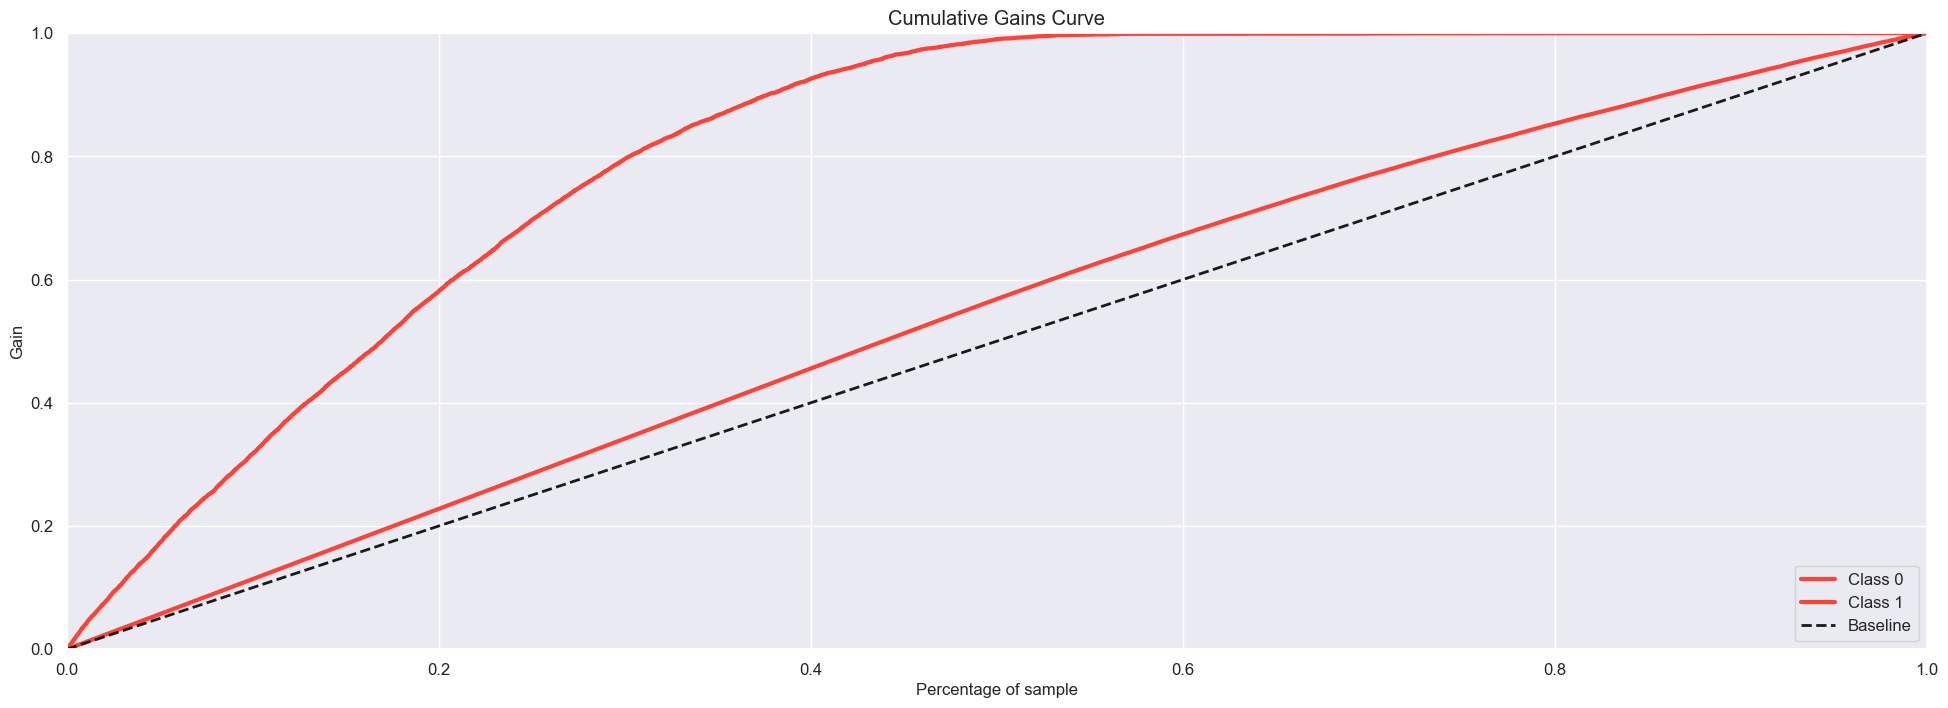

In [158]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred);

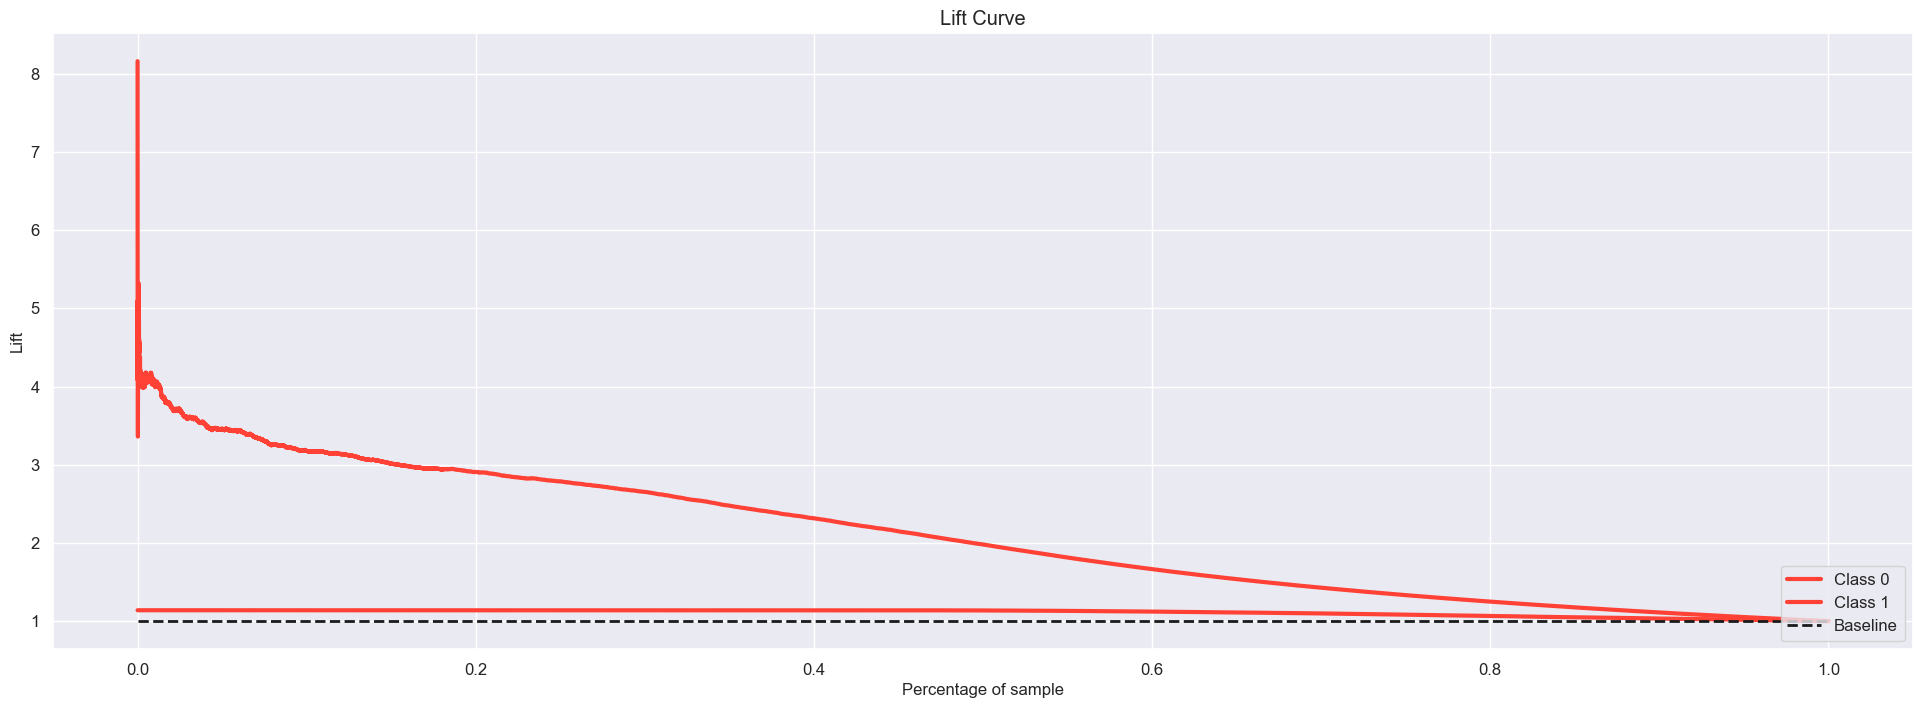

In [159]:
skplt.metrics.plot_lift_curve(y_test, y_pred);

# 11.0 Bussines Performance

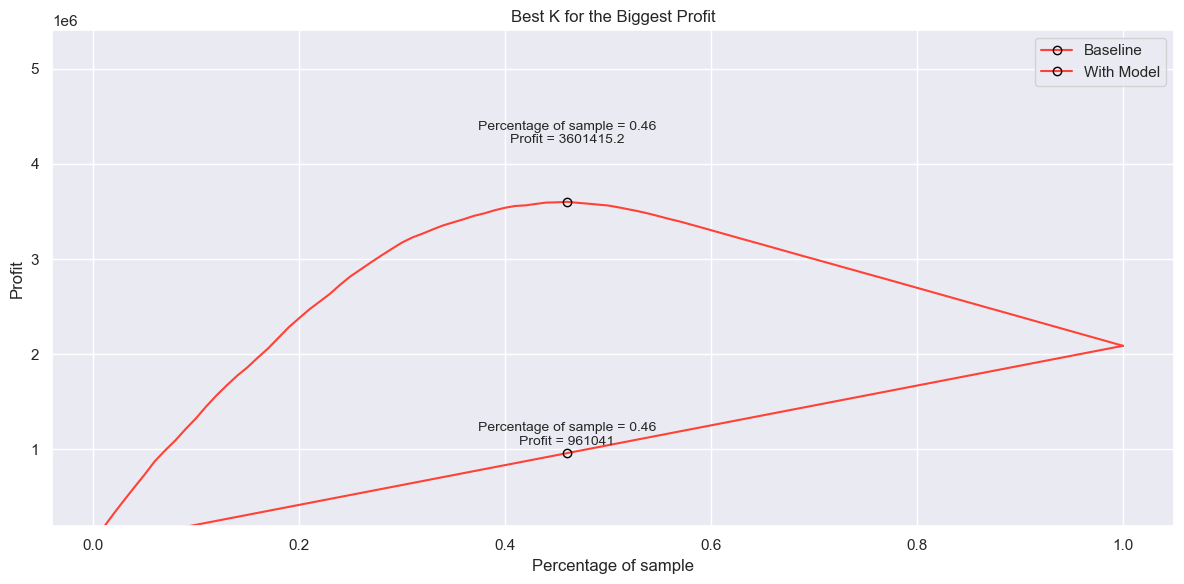

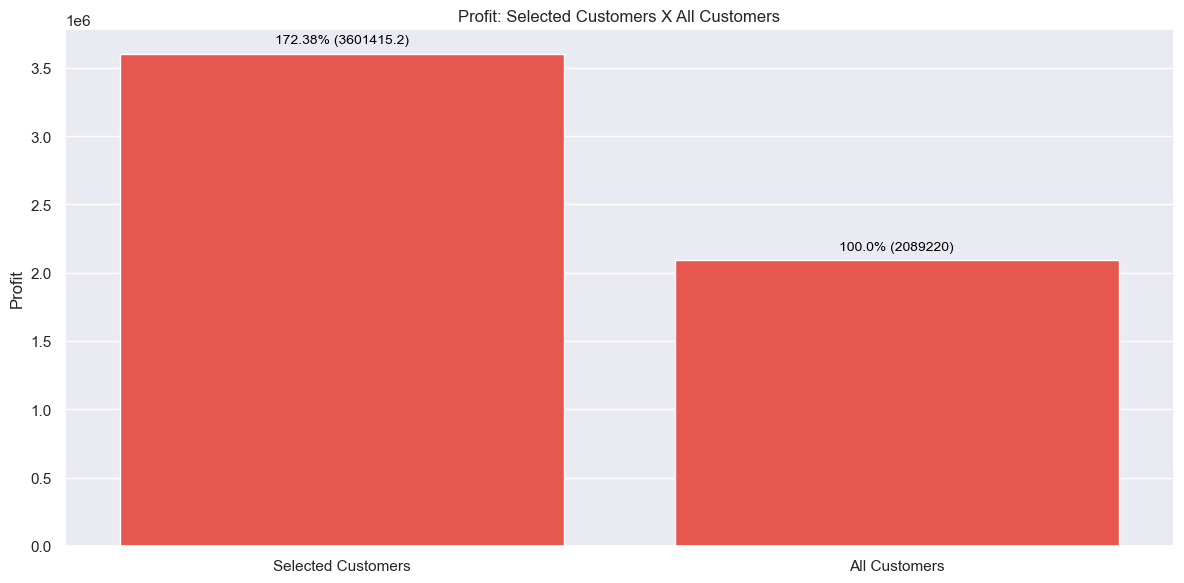

In [161]:
insurance_price = 550
cost = 40

insurance_profit = Profit(X_test, insurance_price, cost)

insurance_profit.profit_dataframe()
insurance_profit.line_profit()
insurance_profit.profit_bar();

# 12.0 Insurance Class to deploy

In [164]:
final_pipe

Pipeline(steps=[('Engineering/Processing',
                 Pipeline(steps=[('Feature Engineering',
                                  Pipeline(steps=[('Feature Engineering',
                                                   FeatureEngineering())])),
                                 ('Preprocessing',
                                  ColumnTransformer(transformers=[('Numerical '
                                                                   'Transformations',
                                                                   Pipeline(steps=[('Numerical '
                                                                                    'Imputer',
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['gender',
                                                                    'age',
                                                                    'region_code',
                                                                    'policy_sales_channel',
                                                                    '...
                                               Pipeline(steps=[('LGBM '
                                                                'Classifier',
                                                                LGBMClassifier(class_weight='balanced',
                                                                               colsample_bytree=0.740105,
                                                                               learning_rate=0.013875,
                                                                               min_child_samples=73,
                                                                               n_estimators=1296,
                                                                               num_leaves=55,
                                                                               random_state=25,
                                                                               subsample=0.913048,
                                                                               subsample_freq=1))])),
                                              ('CatBoost',
                                               Pipeline(steps=[('CatBoost',
                                                                <catboost.core.CatBoostClassifier object at 0x000001880EBF1AF0>)]))],
                                  n_jobs=-1, voting='soft'))])

In [165]:
joblib.dump(final_pipe, 'joblib/finalpipe.joblib')

['joblib/finalpipe.joblib']

In [167]:
pipe_final = joblib.load('joblib/finalpipe.joblib')